In [4]:
import numpy as np
import torch
import torch.distributions as dist

from statsmodels.tsa.stattools import acf

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from tqdm import tqdm_notebook as tqdm

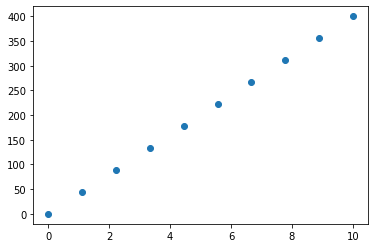

In [413]:
qq = np.linspace(0, 10, 10)
yy = 40 * qq
# yy = 40 40 * qq ** 2
plt.plot(qq, yy, 'o')
plt.show()

In [414]:
class MCMC:
    def __init__(self, distribution, proposal):

        self.distribution = distribution
        self.proposal = proposal
    
    def _step(self, x):
        
#         print('get proposal')

    
        x_prime = self.proposal.sample(x)
        
#         print('get acceptance')
        acceptance_prob = self.acceptance_prob(x_prime, x)
        
        mask = torch.rand(x.shape[0]) < acceptance_prob

        x[mask] = x_prime[mask]
        self._rejected += (~mask).type(torch.float32)
        return x

    def simulate(self, initial_point, n_steps, burn_in):

        xs = []
        x = initial_point.clone()
        self._rejected = 0
        
        dim = initial_point.shape[0]

        sums = np.zeros([1, dim])
        squares_sum = np.zeros([1, dim])
        
        means = []
        variances = []        
        
        for i in tqdm(range(n_steps + burn_in)):
            
#             print('start step')
            x = self._step(x)
#             print('done step')
            xs.append(x.numpy().copy())
            
            sums += xs[-1]
            squares_sum += xs[-1]**2
            
            mean, squares_mean = sums / (i + 1), squares_sum / (i + 1)
            means.append(mean.copy())
            variances.append(squares_mean - mean**2)
        
        xs = np.stack(xs[burn_in:], axis=1)        
        means = np.stack(means[burn_in:], axis=1)
        variances = np.stack(variances[burn_in:], axis=1)
        
        return dict(
            points=xs,
            n_rejected=self._rejected.numpy(),
            rejection_rate=(self._rejected / (n_steps + burn_in)).mean().item(),
            means=means,
            variances=variances
        )
        
    def acceptance_prob(self, x_prime, x):
        
        
        
#         print('MH will ask for density')
        pi_new = self.distribution.log_density(x_prime)
#         print('MH will ask for density')
        pi_old = self.distribution.log_density(x)
        q_new = self.proposal.log_density(x_prime, x)
        q_old = self.proposal.log_density(x, x_prime)
        ratio = torch.exp(pi_new - pi_old + q_new - q_old)
        return ratio.clamp(0., 1.)
#         return 1
    
def simulate(distribution, proposal, initial_point, n_samples, burn_in):
    mcmc = MCMC(distribution, proposal)
    return mcmc.simulate(initial_point, n_samples, burn_in)

In [415]:
class Proposal:
    """Abstract class for proposal"""
    
    def sample(self, x):

        raise NotImplementedError

    def log_density(self, x, x_prime):

        raise NotImplementedError
        
class Langevin(Proposal):
    """Proposal given by q(x' | x) = N(x' | x - 0.5 * eps * \nabla \log \pi(x), eps)"""
    def __init__(self, eps, posterior):
        
        self.d = dist.Normal(loc=0., scale=np.sqrt(eps))
        
        self.posterior = posterior
        
        self.eps = eps
                
    def sample(self, x):
        
#         self.eps *= .99
        
#         print('sample will ask for gradient')
        s = x + 0.5 * self.eps * (self.posterior.grad_log_density(x))\
                + self.d.sample(sample_shape=x.shape)  

        return s   
    
    
    def log_density(self, x, x_prime):
        
#         print('MH asks for gradient')
        xn = x + 0.5 * self.eps * (self.posterior.grad_log_density(x))

        return self.d.log_prob(x_prime - xn).sum(dim=-1)
    
    def __str__(self):
        return f"Langevin eps={self.eps}"

In [416]:
class Normal:
    """Represents normal distribution N(mean, std)"""
    
    def __init__(self, loc, scale):

        self.dist = dist.Normal(loc=loc, scale=scale)

    def log_density(self, x):
        return self.dist.log_prob(x).sum(dim=-1) # it's added because it's given as product of marginals

In [422]:
class Posterior:
    def __init__(self, pvar, lvar, fun, q, y):
        
        self.pvar = pvar
        self.lvar = lvar
        
        self.prior_dist = dist.Normal(loc=0, scale=pvar)
        self.like_dist = dist.Normal(loc=0, scale=lvar)
        
        self.fun = fun
        
        self.q = q   
        self.y = y
              
    def log_density(self, x):
        
        cur_fun = self.fun(x)
          
        list_likes = [-torch.square((yi - cur_fun(qi))).sum(dim=-1) / self.lvar for qi, yi in zip(self.q, self.y)]
        
        list_priors = [-torch.square(xi).sum(dim=-1) / self.pvar for xi in x]
               
#         list_likes = [self.like_dist.log_prob(yi - cur_fun(qi)).sum(dim=-1) for qi, yi in zip(self.q, self.y)]
        

        print(torch.mean(torch.stack(list_likes)).item(), torch.mean(torch.stack(list_priors)).item())
#         print(torch.mean(torch.stack(list_likes)).item(), self.prior_dist.log_prob(x).sum(dim=-1).item())
#         return torch.mean(torch.stack(list_likes)) + self.prior_dist.log_prob(x).sum(dim=-1)
        return torch.mean(torch.stack(list_likes)) + torch.mean(torch.stack(list_priors))
#                 
    def grad_log_density(self, x):
               
        x = x.clone().requires_grad_()
        
#         print('gradient will ask for density')
        logp = self.log_density(x)
        logp.sum().backward()
        
        return x.grad

In [14]:
def fun(x, n):
    if n == 1:
        return lambda q: torch.mul(x, q)
    elif n > 1:
        return lambda q: sum([torch.mul(x[i], q.pow(i)) for i in range(n)])

tensor([86.])


In [441]:
# prior = Normal(loc=0., scale=.3)
# like = Likelihood(loc=0., scale=1.)
# fun = lambda x: lambda q: x[0] + torch.mul(x[1], q) + torch.mul(x[2], torch.square(q))


fun = lambda x: lambda q: torch.mul(x, q)
posterior = Posterior(10, 1, fun, torch.from_numpy(qq).float(), torch.from_numpy(yy).float())

In [442]:
eps = .0001

options = dict(
    initial_point=torch.tensor([0.]),
    n_samples=10000,
    burn_in = 1000
    )

proposal = Langevin(eps, posterior)

result = simulate(posterior, proposal, **options)

print(result['rejection_rate'], result['means'][0][-1])

C:\Users\apsaros\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-56296.29296875 0.0
-55929.8046875 -0.0017007129499688745
-56296.29296875 0.0
-55929.8046875 -0.0017007129499688745
-56296.29296875 0.0
-55929.8046875 -0.0017007129499688745
-55536.0625 -0.007344095502048731
-55929.8046875 -0.0017007129499688745
-55536.0625 -0.007344095502048731
-55929.8046875 -0.0017007129499688745
-55536.0625 -0.007344095502048731
-55168.26953125 -0.01622268743813038
-55536.0625 -0.007344095502048731
-55168.26953125 -0.01622268743813038
-55536.0625 -0.007344095502048731
-55168.26953125 -0.01622268743813038
-54793.0078125 -0.02890956960618496
-55168.26953125 -0.01622268743813038
-54793.0078125 -0.02890956960618496
-55168.26953125 -0.01622268743813038
-54793.0078125 -0.02890956960618496
-54422.98828125 -0.045044004917144775
-54793.0078125 -0.02890956960618496
-54422.98828125 -0.045044004917144775
-54793.0078125 -0.02890956960618496
-54422.98828125 -0.045044004917144775
-54068.1640625 -0.06393029540777206
-54422.98828125 -0.045044004917144775
-54068.1640625 -0.063930295

-37752.3125 -5.247446537017822
-37510.08984375 -5.401040554046631
-37268.17578125 -5.557158470153809
-37510.08984375 -5.401040554046631
-37268.17578125 -5.557158470153809
-37510.08984375 -5.401040554046631
-37268.17578125 -5.557158470153809
-37018.3203125 -5.721277713775635
-37268.17578125 -5.557158470153809
-37018.3203125 -5.721277713775635
-37268.17578125 -5.557158470153809
-37018.3203125 -5.721277713775635
-36764.5390625 -5.891003608703613
-37018.3203125 -5.721277713775635
-36764.5390625 -5.891003608703613
-37018.3203125 -5.721277713775635
-36764.5390625 -5.891003608703613
-36508.75390625 -6.065188884735107
-36764.5390625 -5.891003608703613
-36508.75390625 -6.065188884735107
-36764.5390625 -5.891003608703613
-36508.75390625 -6.065188884735107
-36281.8046875 -6.222384452819824
-36508.75390625 -6.065188884735107
-36281.8046875 -6.222384452819824
-36508.75390625 -6.065188884735107
-36281.8046875 -6.222384452819824
-36028.71484375 -6.4006500244140625
-36281.8046875 -6.222384452819824
-3

-25748.943359375 -16.765005111694336
-25937.439453125 -16.51003074645996
-25748.943359375 -16.765005111694336
-25937.439453125 -16.51003074645996
-25748.943359375 -16.765005111694336
-25559.3828125 -17.024335861206055
-25748.943359375 -16.765005111694336
-25559.3828125 -17.024335861206055
-25748.943359375 -16.765005111694336
-25559.3828125 -17.024335861206055
-25379.79296875 -17.272769927978516
-25559.3828125 -17.024335861206055
-25379.79296875 -17.272769927978516
-25559.3828125 -17.024335861206055
-25379.79296875 -17.272769927978516
-25248.55859375 -17.456005096435547
-25379.79296875 -17.272769927978516
-25248.55859375 -17.456005096435547
-25379.79296875 -17.272769927978516
-25248.55859375 -17.456005096435547
-25021.74609375 -17.776113510131836
-25248.55859375 -17.456005096435547
-25021.74609375 -17.776113510131836
-25248.55859375 -17.456005096435547
-25021.74609375 -17.776113510131836
-24853.978515625 -18.01570701599121
-25021.74609375 -17.776113510131836
-24853.978515625 -18.0157070

-17732.220703125 -30.80291748046875
-17854.86328125 -30.531484603881836
-17732.220703125 -30.80291748046875
-17594.2734375 -31.110794067382812
-17732.220703125 -30.80291748046875
-17594.2734375 -31.110794067382812
-17732.220703125 -30.80291748046875
-17594.2734375 -31.110794067382812
-17485.875 -31.354644775390625
-17594.2734375 -31.110794067382812
-17485.875 -31.354644775390625
-17594.2734375 -31.110794067382812
-17485.875 -31.354644775390625
-17344.57421875 -31.675094604492188
-17485.875 -31.354644775390625
-17344.57421875 -31.675094604492188
-17485.875 -31.354644775390625
-17344.57421875 -31.675094604492188
-17206.2109375 -31.99173927307129
-17344.57421875 -31.675094604492188
-17206.2109375 -31.99173927307129
-17344.57421875 -31.675094604492188
-17206.2109375 -31.99173927307129
-17087.93359375 -32.264678955078125
-17206.2109375 -31.99173927307129
-17087.93359375 -32.264678955078125
-17206.2109375 -31.99173927307129
-17087.93359375 -32.264678955078125
-16979.744140625 -32.51619720458

-12016.0009765625 -46.31138610839844
-12095.1953125 -46.050079345703125
-12016.0009765625 -46.31138610839844
-11953.3984375 -46.519081115722656
-12016.0009765625 -46.31138610839844
-11953.3984375 -46.519081115722656
-12016.0009765625 -46.31138610839844
-11953.3984375 -46.519081115722656
-11879.4267578125 -46.76580047607422
-11953.3984375 -46.519081115722656
-11879.4267578125 -46.76580047607422
-11953.3984375 -46.519081115722656
-11879.4267578125 -46.76580047607422
-11788.3779296875 -47.07143783569336
-11879.4267578125 -46.76580047607422
-11788.3779296875 -47.07143783569336
-11879.4267578125 -46.76580047607422
-11788.3779296875 -47.07143783569336
-11689.962890625 -47.40425491333008
-11788.3779296875 -47.07143783569336
-11689.962890625 -47.40425491333008
-11788.3779296875 -47.07143783569336
-11689.962890625 -47.40425491333008
-11601.5263671875 -47.70553207397461
-11689.962890625 -47.40425491333008
-11601.5263671875 -47.70553207397461
-11689.962890625 -47.40425491333008
-11601.5263671875 

-8405.236328125 -60.24114990234375
-8352.515625 -60.479698181152344
-8285.310546875 -60.78557586669922
-8352.515625 -60.479698181152344
-8285.310546875 -60.78557586669922
-8352.515625 -60.479698181152344
-8285.310546875 -60.78557586669922
-8227.2412109375 -61.05149459838867
-8285.310546875 -60.78557586669922
-8227.2412109375 -61.05149459838867
-8285.310546875 -60.78557586669922
-8227.2412109375 -61.05149459838867
-8174.5224609375 -61.294227600097656
-8227.2412109375 -61.05149459838867
-8174.5224609375 -61.294227600097656
-8227.2412109375 -61.05149459838867
-8174.5224609375 -61.294227600097656
-8126.21240234375 -61.51778030395508
-8174.5224609375 -61.294227600097656
-8126.21240234375 -61.51778030395508
-8174.5224609375 -61.294227600097656
-8126.21240234375 -61.51778030395508
-8081.921875 -61.72367477416992
-8126.21240234375 -61.51778030395508
-8081.921875 -61.72367477416992
-8126.21240234375 -61.51778030395508
-8081.921875 -61.72367477416992
-8026.12255859375 -61.98436737060547
-8081.92

-5897.6455078125 -73.18804931640625
-5863.69091796875 -73.39012908935547
-5897.6455078125 -73.18804931640625
-5863.69091796875 -73.39012908935547
-5821.017578125 -73.64532470703125
-5863.69091796875 -73.39012908935547
-5821.017578125 -73.64532470703125
-5863.69091796875 -73.39012908935547
-5821.017578125 -73.64532470703125
-5769.5263671875 -73.9551010131836
-5821.017578125 -73.64532470703125
-5769.5263671875 -73.9551010131836
-5821.017578125 -73.64532470703125
-5769.5263671875 -73.9551010131836
-5720.5517578125 -74.25163269042969
-5769.5263671875 -73.9551010131836
-5720.5517578125 -74.25163269042969
-5769.5263671875 -73.9551010131836
-5720.5517578125 -74.25163269042969
-5682.0927734375 -74.48579406738281
-5720.5517578125 -74.25163269042969
-5682.0927734375 -74.48579406738281
-5720.5517578125 -74.25163269042969
-5682.0927734375 -74.48579406738281
-5636.20947265625 -74.76668548583984
-5682.0927734375 -74.48579406738281
-5636.20947265625 -74.76668548583984
-5682.0927734375 -74.48579406738

-4063.268798828125 -85.57804870605469
-4092.31494140625 -85.35387420654297
-4063.268798828125 -85.57804870605469
-4022.856201171875 -85.89178466796875
-4063.268798828125 -85.57804870605469
-4022.856201171875 -85.89178466796875
-4063.268798828125 -85.57804870605469
-4022.856201171875 -85.89178466796875
-3998.896484375 -86.07881164550781
-4022.856201171875 -85.89178466796875
-3998.896484375 -86.07881164550781
-4022.856201171875 -85.89178466796875
-3998.896484375 -86.07881164550781
-3987.981201171875 -86.16426086425781
-3998.896484375 -86.07881164550781
-3987.981201171875 -86.16426086425781
-3998.896484375 -86.07881164550781
-3987.981201171875 -86.16426086425781
-3960.475830078125 -86.38031005859375
-3987.981201171875 -86.16426086425781
-3960.475830078125 -86.38031005859375
-3987.981201171875 -86.16426086425781
-3960.475830078125 -86.38031005859375
-3933.701904296875 -86.59159851074219
-3960.475830078125 -86.38031005859375
-3933.701904296875 -86.59159851074219
-3960.475830078125 -86.38031

-2841.78271484375 -96.18051147460938
-2824.130615234375 -96.35398864746094
-2841.78271484375 -96.18051147460938
-2824.130615234375 -96.35398864746094
-2841.78271484375 -96.18051147460938
-2824.130615234375 -96.35398864746094
-2810.5478515625 -96.48795318603516
-2824.130615234375 -96.35398864746094
-2810.5478515625 -96.48795318603516
-2824.130615234375 -96.35398864746094
-2810.5478515625 -96.48795318603516
-2798.022705078125 -96.61185455322266
-2810.5478515625 -96.48795318603516
-2798.022705078125 -96.61185455322266
-2810.5478515625 -96.48795318603516
-2798.022705078125 -96.61185455322266
-2777.08837890625 -96.81973266601562
-2798.022705078125 -96.61185455322266
-2777.08837890625 -96.81973266601562
-2798.022705078125 -96.61185455322266
-2777.08837890625 -96.81973266601562
-2761.240966796875 -96.9777603149414
-2777.08837890625 -96.81973266601562
-2761.240966796875 -96.9777603149414
-2777.08837890625 -96.81973266601562
-2761.240966796875 -96.9777603149414
-2742.30419921875 -97.16737365722

-1976.0670166015625 -105.6631851196289
-1996.7431640625 -105.40911865234375
-1976.0670166015625 -105.6631851196289
-1996.7431640625 -105.40911865234375
-1976.0670166015625 -105.6631851196289
-1964.069580078125 -105.8113784790039
-1976.0670166015625 -105.6631851196289
-1964.069580078125 -105.8113784790039
-1976.0670166015625 -105.6631851196289
-1964.069580078125 -105.8113784790039
-1953.5980224609375 -105.941162109375
-1964.069580078125 -105.8113784790039
-1953.5980224609375 -105.941162109375
-1964.069580078125 -105.8113784790039
-1953.5980224609375 -105.941162109375
-1935.467529296875 -106.16688537597656
-1953.5980224609375 -105.941162109375
-1935.467529296875 -106.16688537597656
-1953.5980224609375 -105.941162109375
-1935.467529296875 -106.16688537597656
-1922.450927734375 -106.32975006103516
-1935.467529296875 -106.16688537597656
-1922.450927734375 -106.32975006103516
-1935.467529296875 -106.16688537597656
-1922.450927734375 -106.32975006103516
-1910.191650390625 -106.48374938964844


-1398.4736328125 -113.53900146484375
-1389.152587890625 -113.68087005615234
-1398.4736328125 -113.53900146484375
-1389.152587890625 -113.68087005615234
-1381.347412109375 -113.80010986328125
-1389.152587890625 -113.68087005615234
-1381.347412109375 -113.80010986328125
-1389.152587890625 -113.68087005615234
-1381.347412109375 -113.80010986328125
-1369.7779541015625 -113.97758483886719
-1381.347412109375 -113.80010986328125
-1369.7779541015625 -113.97758483886719
-1381.347412109375 -113.80010986328125
-1369.7779541015625 -113.97758483886719
-1359.804931640625 -114.13127136230469
-1369.7779541015625 -113.97758483886719
-1359.804931640625 -114.13127136230469
-1369.7779541015625 -113.97758483886719
-1359.804931640625 -114.13127136230469
-1351.1839599609375 -114.2646713256836
-1359.804931640625 -114.13127136230469
-1351.1839599609375 -114.2646713256836
-1359.804931640625 -114.13127136230469
-1351.1839599609375 -114.2646713256836
-1345.2916259765625 -114.35614013671875
-1351.1839599609375 -11

-970.7021484375 -120.73912048339844
-972.7449951171875 -120.70074462890625
-970.7021484375 -120.73912048339844
-972.7449951171875 -120.70074462890625
-970.7021484375 -120.73912048339844
-972.7449951171875 -120.70074462890625
-965.1041259765625 -120.84455871582031
-972.7449951171875 -120.70074462890625
-965.1041259765625 -120.84455871582031
-972.7449951171875 -120.70074462890625
-965.1041259765625 -120.84455871582031
-955.1354370117188 -121.03316497802734
-965.1041259765625 -120.84455871582031
-955.1354370117188 -121.03316497802734
-965.1041259765625 -120.84455871582031
-955.1354370117188 -121.03316497802734
-952.9446411132812 -121.07476806640625
-955.1354370117188 -121.03316497802734
-952.9446411132812 -121.07476806640625
-955.1354370117188 -121.03316497802734
-952.9446411132812 -121.07476806640625
-943.8997802734375 -121.24711608886719
-952.9446411132812 -121.07476806640625
-943.8997802734375 -121.24711608886719
-952.9446411132812 -121.07476806640625
-943.8997802734375 -121.2471160888

-673.4791259765625 -126.91377258300781
-670.7547607421875 -126.97688293457031
-673.4791259765625 -126.91377258300781
-670.7547607421875 -126.97688293457031
-663.4155883789062 -127.14764404296875
-670.7547607421875 -126.97688293457031
-663.4155883789062 -127.14764404296875
-670.7547607421875 -126.97688293457031
-663.4155883789062 -127.14764404296875
-661.4192504882812 -127.19427490234375
-663.4155883789062 -127.14764404296875
-661.4192504882812 -127.19427490234375
-663.4155883789062 -127.14764404296875
-661.4192504882812 -127.19427490234375
-651.981689453125 -127.41580963134766
-661.4192504882812 -127.19427490234375
-651.981689453125 -127.41580963134766
-661.4192504882812 -127.19427490234375
-651.981689453125 -127.41580963134766
-642.6127319335938 -127.63749694824219
-651.981689453125 -127.41580963134766
-642.6127319335938 -127.63749694824219
-651.981689453125 -127.41580963134766
-642.6127319335938 -127.63749694824219
-638.5899658203125 -127.73323822021484
-642.6127319335938 -127.637496

-458.323486328125 -132.42930603027344
-463.471923828125 -132.28224182128906
-458.323486328125 -132.42930603027344
-454.48736572265625 -132.5395050048828
-458.323486328125 -132.42930603027344
-454.48736572265625 -132.5395050048828
-458.323486328125 -132.42930603027344
-454.48736572265625 -132.5395050048828
-453.551025390625 -132.5664825439453
-454.48736572265625 -132.5395050048828
-453.551025390625 -132.5664825439453
-454.48736572265625 -132.5395050048828
-453.551025390625 -132.5664825439453
-446.7061462402344 -132.76458740234375
-453.551025390625 -132.5664825439453
-446.7061462402344 -132.76458740234375
-453.551025390625 -132.5664825439453
-446.7061462402344 -132.76458740234375
-447.65478515625 -132.73703002929688
-446.7061462402344 -132.76458740234375
-447.65478515625 -132.73703002929688
-446.7061462402344 -132.76458740234375
-447.65478515625 -132.73703002929688
-445.1007385253906 -132.81129455566406
-447.65478515625 -132.73703002929688
-445.1007385253906 -132.81129455566406
-447.6547

-329.68341064453125 -136.4486846923828
-332.85247802734375 -136.3402862548828
-329.68341064453125 -136.4486846923828
-332.85247802734375 -136.3402862548828
-329.68341064453125 -136.4486846923828
-328.6244812011719 -136.48504638671875
-329.68341064453125 -136.4486846923828
-328.6244812011719 -136.48504638671875
-329.68341064453125 -136.4486846923828
-328.6244812011719 -136.48504638671875
-327.47369384765625 -136.52462768554688
-328.6244812011719 -136.48504638671875
-327.47369384765625 -136.52462768554688
-328.6244812011719 -136.48504638671875
-327.47369384765625 -136.52462768554688
-323.973876953125 -136.6454315185547
-327.47369384765625 -136.52462768554688
-323.973876953125 -136.6454315185547
-327.47369384765625 -136.52462768554688
-323.973876953125 -136.6454315185547
-319.5423889160156 -136.7994384765625
-323.973876953125 -136.6454315185547
-319.5423889160156 -136.7994384765625
-323.973876953125 -136.6454315185547
-319.5423889160156 -136.7994384765625
-316.98809814453125 -136.88873291

-229.31814575195312 -140.22828674316406
-230.7113037109375 -140.1702880859375
-231.8609161376953 -140.12258911132812
-230.7113037109375 -140.1702880859375
-231.8609161376953 -140.12258911132812
-230.7113037109375 -140.1702880859375
-231.8609161376953 -140.12258911132812
-228.6064910888672 -140.25796508789062
-231.8609161376953 -140.12258911132812
-228.6064910888672 -140.25796508789062
-231.8609161376953 -140.12258911132812
-228.6064910888672 -140.25796508789062
-227.3144989013672 -140.31201171875
-228.6064910888672 -140.25796508789062
-227.3144989013672 -140.31201171875
-228.6064910888672 -140.25796508789062
-227.3144989013672 -140.31201171875
-223.8940887451172 -140.45584106445312
-227.3144989013672 -140.31201171875
-223.8940887451172 -140.45584106445312
-227.3144989013672 -140.31201171875
-223.8940887451172 -140.45584106445312
-222.5182647705078 -140.5140380859375
-223.8940887451172 -140.45584106445312
-222.5182647705078 -140.5140380859375
-223.8940887451172 -140.45584106445312
-222.

-176.42526245117188 -142.58750915527344
-175.66189575195312 -142.62413024902344
-176.42526245117188 -142.58750915527344
-175.66189575195312 -142.62413024902344
-176.42526245117188 -142.58750915527344
-175.66189575195312 -142.62413024902344
-173.6541290283203 -142.7208709716797
-175.66189575195312 -142.62413024902344
-173.6541290283203 -142.7208709716797
-175.66189575195312 -142.62413024902344
-173.6541290283203 -142.7208709716797
-172.84170532226562 -142.7601776123047
-173.6541290283203 -142.7208709716797
-172.84170532226562 -142.7601776123047
-173.6541290283203 -142.7208709716797
-172.84170532226562 -142.7601776123047
-170.17950439453125 -142.88970947265625
-172.84170532226562 -142.7601776123047
-170.17950439453125 -142.88970947265625
-172.84170532226562 -142.7601776123047
-170.17950439453125 -142.88970947265625
-170.65023803710938 -142.86672973632812
-170.17950439453125 -142.88970947265625
-170.65023803710938 -142.86672973632812
-170.17950439453125 -142.88970947265625
-170.6502380371

-115.5576171875 -145.83038330078125
-114.47392272949219 -145.89544677734375
-115.5576171875 -145.83038330078125
-114.47392272949219 -145.89544677734375
-115.5576171875 -145.83038330078125
-113.826416015625 -145.93447875976562
-115.5576171875 -145.83038330078125
-113.826416015625 -145.93447875976562
-115.5576171875 -145.83038330078125
-113.826416015625 -145.93447875976562
-114.45057678222656 -145.8968505859375
-113.826416015625 -145.93447875976562
-114.45057678222656 -145.8968505859375
-113.826416015625 -145.93447875976562
-114.45057678222656 -145.8968505859375
-113.06781005859375 -145.9803466796875
-114.45057678222656 -145.8968505859375
-113.06781005859375 -145.9803466796875
-114.45057678222656 -145.8968505859375
-113.06781005859375 -145.9803466796875
-112.21864318847656 -146.03189086914062
-113.06781005859375 -145.9803466796875
-112.21864318847656 -146.03189086914062
-113.06781005859375 -145.9803466796875
-112.21864318847656 -146.03189086914062
-110.99708557128906 -146.10638427734375


-68.90586853027344 -149.00045776367188
-68.91793823242188 -148.99952697753906
-68.90586853027344 -149.00045776367188
-68.91793823242188 -148.99952697753906
-68.90586853027344 -149.00045776367188
-68.09951782226562 -149.06387329101562
-68.90586853027344 -149.00045776367188
-68.09951782226562 -149.06387329101562
-68.90586853027344 -149.00045776367188
-68.09951782226562 -149.06387329101562
-66.50978088378906 -149.19003295898438
-68.09951782226562 -149.06387329101562
-66.50978088378906 -149.19003295898438
-68.09951782226562 -149.06387329101562
-66.50978088378906 -149.19003295898438
-65.35002136230469 -149.28305053710938
-66.50978088378906 -149.19003295898438
-65.35002136230469 -149.28305053710938
-66.50978088378906 -149.19003295898438
-65.35002136230469 -149.28305053710938
-67.2496109008789 -149.13113403320312
-65.35002136230469 -149.28305053710938
-67.2496109008789 -149.13113403320312
-65.35002136230469 -149.28305053710938
-67.2496109008789 -149.13113403320312
-67.6119155883789 -149.10240

-46.21409225463867 -150.96286010742188
-46.61612319946289 -150.92420959472656
-46.21409225463867 -150.96286010742188
-47.2530632019043 -150.8633270263672
-46.21409225463867 -150.96286010742188
-47.2530632019043 -150.8633270263672
-46.21409225463867 -150.96286010742188
-47.2530632019043 -150.8633270263672
-47.15568923950195 -150.8726043701172
-47.2530632019043 -150.8633270263672
-47.15568923950195 -150.8726043701172
-47.2530632019043 -150.8633270263672
-47.15568923950195 -150.8726043701172
-46.927268981933594 -150.89442443847656
-47.15568923950195 -150.8726043701172
-46.927268981933594 -150.89442443847656
-47.15568923950195 -150.8726043701172
-46.927268981933594 -150.89442443847656
-45.29940414428711 -151.0514373779297
-46.927268981933594 -150.89442443847656
-45.29940414428711 -151.0514373779297
-46.927268981933594 -150.89442443847656
-45.29940414428711 -151.0514373779297
-43.760196685791016 -151.20262145996094
-45.29940414428711 -151.0514373779297
-43.760196685791016 -151.2026214599609

-29.567081451416016 -152.75047302246094
-29.725051879882812 -152.73135375976562
-28.576940536499023 -152.87149047851562
-29.725051879882812 -152.73135375976562
-28.576940536499023 -152.87149047851562
-29.725051879882812 -152.73135375976562
-28.576940536499023 -152.87149047851562
-28.082202911376953 -152.93276977539062
-28.576940536499023 -152.87149047851562
-28.082202911376953 -152.93276977539062
-28.576940536499023 -152.87149047851562
-28.082202911376953 -152.93276977539062
-28.7739315032959 -152.84725952148438
-28.082202911376953 -152.93276977539062
-28.7739315032959 -152.84725952148438
-28.082202911376953 -152.93276977539062
-28.7739315032959 -152.84725952148438
-28.00311851501465 -152.942626953125
-28.7739315032959 -152.84725952148438
-28.00311851501465 -152.942626953125
-28.7739315032959 -152.84725952148438
-28.00311851501465 -152.942626953125
-28.121999740600586 -152.92782592773438
-28.00311851501465 -152.942626953125
-28.121999740600586 -152.92782592773438
-28.00311851501465 -15

-17.625041961669922 -154.3880157470703
-17.542551040649414 -154.4010467529297
-17.625041961669922 -154.3880157470703
-17.542551040649414 -154.4010467529297
-17.625041961669922 -154.3880157470703
-16.309640884399414 -154.59967041015625
-17.625041961669922 -154.3880157470703
-16.309640884399414 -154.59967041015625
-17.625041961669922 -154.3880157470703
-16.309640884399414 -154.59967041015625
-16.24899673461914 -154.60963439941406
-16.309640884399414 -154.59967041015625
-16.24899673461914 -154.60963439941406
-16.309640884399414 -154.59967041015625
-16.24899673461914 -154.60963439941406
-15.6581449508667 -154.7077178955078
-16.24899673461914 -154.60963439941406
-15.6581449508667 -154.7077178955078
-16.24899673461914 -154.60963439941406
-15.6581449508667 -154.7077178955078
-15.559834480285645 -154.72421264648438
-15.6581449508667 -154.7077178955078
-15.559834480285645 -154.72421264648438
-15.6581449508667 -154.7077178955078
-15.559834480285645 -154.72421264648438
-15.207796096801758 -154.78

-9.323527336120605 -155.90835571289062
-8.375423431396484 -156.12066650390625
-9.323527336120605 -155.90835571289062
-8.375423431396484 -156.12066650390625
-9.323527336120605 -155.90835571289062
-8.375423431396484 -156.12066650390625
-8.746014595031738 -156.0363006591797
-8.375423431396484 -156.12066650390625
-8.746014595031738 -156.0363006591797
-8.375423431396484 -156.12066650390625
-8.746014595031738 -156.0363006591797
-8.93453311920166 -155.99407958984375
-8.746014595031738 -156.0363006591797
-8.93453311920166 -155.99407958984375
-8.746014595031738 -156.0363006591797
-8.93453311920166 -155.99407958984375
-9.158307075500488 -155.94454956054688
-8.93453311920166 -155.99407958984375
-9.158307075500488 -155.94454956054688
-8.93453311920166 -155.99407958984375
-9.158307075500488 -155.94454956054688
-8.833368301391602 -156.01669311523438
-9.158307075500488 -155.94454956054688
-8.833368301391602 -156.01669311523438
-9.158307075500488 -155.94454956054688
-8.833368301391602 -156.01669311523

-10.831202507019043 -155.59214782714844
-11.187207221984863 -155.52081298828125
-10.831202507019043 -155.59214782714844
-10.961917877197266 -155.56582641601562
-10.831202507019043 -155.59214782714844
-10.961917877197266 -155.56582641601562
-10.831202507019043 -155.59214782714844
-10.961917877197266 -155.56582641601562
-10.84343147277832 -155.58969116210938
-10.961917877197266 -155.56582641601562
-10.84343147277832 -155.58969116210938
-10.961917877197266 -155.56582641601562
-10.84343147277832 -155.58969116210938
-10.61142349243164 -155.6367950439453
-10.84343147277832 -155.58969116210938
-10.61142349243164 -155.6367950439453
-10.84343147277832 -155.58969116210938
-10.61142349243164 -155.6367950439453
-10.504804611206055 -155.65859985351562
-10.61142349243164 -155.6367950439453
-10.504804611206055 -155.65859985351562
-10.61142349243164 -155.6367950439453
-10.504804611206055 -155.65859985351562
-10.445637702941895 -155.6707763671875
-10.504804611206055 -155.65859985351562
-10.445637702941

-7.310555458068848 -156.37420654296875
-7.047521114349365 -156.4396514892578
-7.310555458068848 -156.37420654296875
-7.047521114349365 -156.4396514892578
-7.244952201843262 -156.39041137695312
-7.047521114349365 -156.4396514892578
-7.244952201843262 -156.39041137695312
-7.047521114349365 -156.4396514892578
-7.244952201843262 -156.39041137695312
-6.708965301513672 -156.5257568359375
-7.244952201843262 -156.39041137695312
-6.708965301513672 -156.5257568359375
-7.244952201843262 -156.39041137695312
-6.708965301513672 -156.5257568359375
-6.289173603057861 -156.63560485839844
-6.708965301513672 -156.5257568359375
-6.289173603057861 -156.63560485839844
-6.708965301513672 -156.5257568359375
-6.289173603057861 -156.63560485839844
-5.735488414764404 -156.78634643554688
-6.289173603057861 -156.63560485839844
-5.735488414764404 -156.78634643554688
-6.289173603057861 -156.63560485839844
-5.735488414764404 -156.78634643554688
-5.748392581939697 -156.78274536132812
-5.735488414764404 -156.7863464355

-3.2255234718322754 -157.58694458007812
-3.194080114364624 -157.5987091064453
-3.2255234718322754 -157.58694458007812
-3.194080114364624 -157.5987091064453
-3.2255234718322754 -157.58694458007812
-3.4666550159454346 -157.49874877929688
-3.2255234718322754 -157.58694458007812
-3.4666550159454346 -157.49874877929688
-3.2255234718322754 -157.58694458007812
-3.4666550159454346 -157.49874877929688
-3.4180939197540283 -157.51625061035156
-3.4666550159454346 -157.49874877929688
-3.4180939197540283 -157.51625061035156
-3.4666550159454346 -157.49874877929688
-3.4180939197540283 -157.51625061035156
-3.807192325592041 -157.37925720214844
-3.4180939197540283 -157.51625061035156
-3.807192325592041 -157.37925720214844
-3.4180939197540283 -157.51625061035156
-3.807192325592041 -157.37925720214844
-3.8301963806152344 -157.3713836669922
-3.807192325592041 -157.37925720214844
-3.8301963806152344 -157.3713836669922
-3.807192325592041 -157.37925720214844
-3.8301963806152344 -157.3713836669922
-3.854047298

-3.4843735694885254 -157.4923858642578
-3.5309624671936035 -157.47573852539062
-3.4843735694885254 -157.4923858642578
-3.5309624671936035 -157.47573852539062
-3.4843735694885254 -157.4923858642578
-3.5309624671936035 -157.47573852539062
-3.539759397506714 -157.47262573242188
-3.5309624671936035 -157.47573852539062
-3.539759397506714 -157.47262573242188
-3.5309624671936035 -157.47573852539062
-3.539759397506714 -157.47262573242188
-3.1406848430633545 -157.61878967285156
-3.539759397506714 -157.47262573242188
-3.1406848430633545 -157.61878967285156
-3.539759397506714 -157.47262573242188
-3.1406848430633545 -157.61878967285156
-3.247950315475464 -157.57862854003906
-3.1406848430633545 -157.61878967285156
-3.247950315475464 -157.57862854003906
-3.1406848430633545 -157.61878967285156
-3.247950315475464 -157.57862854003906
-3.421689510345459 -157.5149383544922
-3.247950315475464 -157.57862854003906
-3.421689510345459 -157.5149383544922
-3.247950315475464 -157.57862854003906
-3.42168951034545

-3.941683530807495 -157.33355712890625
-4.015061855316162 -157.3089599609375
-3.941683530807495 -157.33355712890625
-4.015061855316162 -157.3089599609375
-3.881382465362549 -157.3539581298828
-4.015061855316162 -157.3089599609375
-3.881382465362549 -157.3539581298828
-4.015061855316162 -157.3089599609375
-3.881382465362549 -157.3539581298828
-3.8511929512023926 -157.36422729492188
-3.881382465362549 -157.3539581298828
-3.8511929512023926 -157.36422729492188
-3.881382465362549 -157.3539581298828
-3.8511929512023926 -157.36422729492188
-3.760370969772339 -157.39535522460938
-3.8511929512023926 -157.36422729492188
-3.760370969772339 -157.39535522460938
-3.8511929512023926 -157.36422729492188
-3.760370969772339 -157.39535522460938
-3.943392276763916 -157.33297729492188
-3.760370969772339 -157.39535522460938
-3.943392276763916 -157.33297729492188
-3.760370969772339 -157.39535522460938
-3.943392276763916 -157.33297729492188
-4.024526596069336 -157.30581665039062
-3.943392276763916 -157.33297

-3.924649715423584 -157.3393096923828
-4.081539630889893 -157.286865234375
-3.924649715423584 -157.3393096923828
-4.081539630889893 -157.286865234375
-3.924649715423584 -157.3393096923828
-3.647317886352539 -157.43466186523438
-3.924649715423584 -157.3393096923828
-3.647317886352539 -157.43466186523438
-3.924649715423584 -157.3393096923828
-3.647317886352539 -157.43466186523438
-4.0996599197387695 -157.2808837890625
-3.647317886352539 -157.43466186523438
-4.0996599197387695 -157.2808837890625
-3.647317886352539 -157.43466186523438
-4.0996599197387695 -157.2808837890625
-4.409238815307617 -157.18052673339844
-4.0996599197387695 -157.2808837890625
-4.409238815307617 -157.18052673339844
-4.0996599197387695 -157.2808837890625
-4.409238815307617 -157.18052673339844
-4.163415431976318 -157.25991821289062
-4.409238815307617 -157.18052673339844
-4.163415431976318 -157.25991821289062
-4.409238815307617 -157.18052673339844
-4.163415431976318 -157.25991821289062
-3.7399325370788574 -157.402420043

-3.4346823692321777 -157.51025390625
-3.4849624633789062 -157.49217224121094
-3.4346823692321777 -157.51025390625
-3.4849624633789062 -157.49217224121094
-3.4346823692321777 -157.51025390625
-3.240987777709961 -157.58120727539062
-3.4346823692321777 -157.51025390625
-3.240987777709961 -157.58120727539062
-3.4346823692321777 -157.51025390625
-3.240987777709961 -157.58120727539062
-2.6469500064849854 -157.8132781982422
-3.240987777709961 -157.58120727539062
-2.6469500064849854 -157.8132781982422
-3.240987777709961 -157.58120727539062
-2.6469500064849854 -157.8132781982422
-2.51701021194458 -157.86744689941406
-2.6469500064849854 -157.8132781982422
-2.51701021194458 -157.86744689941406
-2.6469500064849854 -157.8132781982422
-2.51701021194458 -157.86744689941406
-2.668802499771118 -157.80430603027344
-2.51701021194458 -157.86744689941406
-2.668802499771118 -157.80430603027344
-2.51701021194458 -157.86744689941406
-2.668802499771118 -157.80430603027344
-2.7888436317443848 -157.7556457519531

-2.8490965366363525 -157.73159790039062
-3.3303120136260986 -157.5482177734375
-2.8490965366363525 -157.73159790039062
-3.3303120136260986 -157.5482177734375
-2.8490965366363525 -157.73159790039062
-2.886803388595581 -157.71670532226562
-2.8490965366363525 -157.73159790039062
-2.886803388595581 -157.71670532226562
-2.8490965366363525 -157.73159790039062
-2.886803388595581 -157.71670532226562
-2.988586187362671 -157.6769561767578
-2.886803388595581 -157.71670532226562
-2.988586187362671 -157.6769561767578
-2.886803388595581 -157.71670532226562
-2.988586187362671 -157.6769561767578
-3.023345470428467 -157.6635284423828
-2.988586187362671 -157.6769561767578
-3.023345470428467 -157.6635284423828
-2.988586187362671 -157.6769561767578
-3.023345470428467 -157.6635284423828
-2.9522361755371094 -157.69107055664062
-3.023345470428467 -157.6635284423828
-2.9522361755371094 -157.69107055664062
-3.023345470428467 -157.6635284423828
-2.9522361755371094 -157.69107055664062
-2.8967347145080566 -157.71

-0.8654309511184692 -158.74778747558594
-0.7741307020187378 -158.8155517578125
-0.8654309511184692 -158.74778747558594
-0.7741307020187378 -158.8155517578125
-0.8654309511184692 -158.74778747558594
-0.7741307020187378 -158.8155517578125
-0.8860633969306946 -158.7329864501953
-0.7741307020187378 -158.8155517578125
-0.8860633969306946 -158.7329864501953
-0.7741307020187378 -158.8155517578125
-0.8860633969306946 -158.7329864501953
-0.9653833508491516 -158.6776123046875
-0.8860633969306946 -158.7329864501953
-0.9653833508491516 -158.6776123046875
-0.8860633969306946 -158.7329864501953
-0.9653833508491516 -158.6776123046875
-0.9432627558708191 -158.69281005859375
-0.9653833508491516 -158.6776123046875
-0.9432627558708191 -158.69281005859375
-0.9653833508491516 -158.6776123046875
-0.9432627558708191 -158.69281005859375
-0.9863494634628296 -158.66336059570312
-0.9432627558708191 -158.69281005859375
-0.9863494634628296 -158.66336059570312
-0.9432627558708191 -158.69281005859375
-0.986349463462

-0.5264312028884888 -159.02294921875
-0.5350965857505798 -159.01495361328125
-0.5264312028884888 -159.02294921875
-0.5475872755050659 -159.0035400390625
-0.5264312028884888 -159.02294921875
-0.5475872755050659 -159.0035400390625
-0.5264312028884888 -159.02294921875
-0.5475872755050659 -159.0035400390625
-0.6001988053321838 -158.95684814453125
-0.5475872755050659 -159.0035400390625
-0.6001988053321838 -158.95684814453125
-0.5475872755050659 -159.0035400390625
-0.6001988053321838 -158.95684814453125
-0.5863872766494751 -158.96890258789062
-0.6001988053321838 -158.95684814453125
-0.5863872766494751 -158.96890258789062
-0.6001988053321838 -158.95684814453125
-0.5863872766494751 -158.96890258789062
-0.5273469686508179 -159.0220947265625
-0.5863872766494751 -158.96890258789062
-0.5273469686508179 -159.0220947265625
-0.5863872766494751 -158.96890258789062
-0.5273469686508179 -159.0220947265625
-0.6638864874839783 -158.90298461914062
-0.5273469686508179 -159.0220947265625
-0.6638864874839783 -

-0.08417671173810959 -159.60894775390625
-0.045499082654714584 -159.71243286132812
-0.08417671173810959 -159.60894775390625
-0.045499082654714584 -159.71243286132812
-0.08417671173810959 -159.60894775390625
-0.045499082654714584 -159.71243286132812
-0.026594290509819984 -159.78013610839844
-0.045499082654714584 -159.71243286132812
-0.026594290509819984 -159.78013610839844
-0.045499082654714584 -159.71243286132812
-0.026594290509819984 -159.78013610839844
-0.028707003220915794 -159.77157592773438
-0.026594290509819984 -159.78013610839844
-0.028707003220915794 -159.77157592773438
-0.026594290509819984 -159.78013610839844
-0.028707003220915794 -159.77157592773438
-0.015707291662693024 -159.8310089111328
-0.028707003220915794 -159.77157592773438
-0.015707291662693024 -159.8310089111328
-0.028707003220915794 -159.77157592773438
-0.015707291662693024 -159.8310089111328
-0.0013915789313614368 -159.94967651367188
-0.015707291662693024 -159.8310089111328
-0.0013915789313614368 -159.949676513671

-0.04067179560661316 -159.72811889648438
-0.034016869962215424 -159.7513427734375
-0.019509701058268547 -159.81167602539062
-0.034016869962215424 -159.7513427734375
-0.019509701058268547 -159.81167602539062
-0.034016869962215424 -159.7513427734375
-0.019509701058268547 -159.81167602539062
-0.03734114021062851 -159.73948669433594
-0.019509701058268547 -159.81167602539062
-0.03734114021062851 -159.73948669433594
-0.019509701058268547 -159.81167602539062
-0.03734114021062851 -159.73948669433594
-0.05722591280937195 -159.67752075195312
-0.03734114021062851 -159.73948669433594
-0.05722591280937195 -159.67752075195312
-0.03734114021062851 -159.73948669433594
-0.05722591280937195 -159.67752075195312
-0.0486498586833477 -159.70265197753906
-0.05722591280937195 -159.67752075195312
-0.0486498586833477 -159.70265197753906
-0.05722591280937195 -159.67752075195312
-0.0486498586833477 -159.70265197753906
-0.04574955254793167 -159.71163940429688
-0.0486498586833477 -159.70265197753906
-0.045749552547

-0.4545361399650574 -159.09201049804688
-0.3765227198600769 -159.17349243164062
-0.4545361399650574 -159.09201049804688
-0.3765227198600769 -159.17349243164062
-0.4545361399650574 -159.09201049804688
-0.5184420347213745 -159.03036499023438
-0.4545361399650574 -159.09201049804688
-0.5184420347213745 -159.03036499023438
-0.4545361399650574 -159.09201049804688
-0.5184420347213745 -159.03036499023438
-0.35915255546569824 -159.19276428222656
-0.5184420347213745 -159.03036499023438
-0.35915255546569824 -159.19276428222656
-0.5184420347213745 -159.03036499023438
-0.35915255546569824 -159.19276428222656
-0.3821769654750824 -159.1673126220703
-0.35915255546569824 -159.19276428222656
-0.3821769654750824 -159.1673126220703
-0.35915255546569824 -159.19276428222656
-0.3821769654750824 -159.1673126220703
-0.388025164604187 -159.16098022460938
-0.3821769654750824 -159.1673126220703
-0.388025164604187 -159.16098022460938
-0.3821769654750824 -159.1673126220703
-0.388025164604187 -159.16098022460938
-0.

-0.08703669160604477 -159.60235595703125
-0.04609868302941322 -159.71054077148438
-0.08703669160604477 -159.60235595703125
-0.04609868302941322 -159.71054077148438
-0.06349239498376846 -159.66033935546875
-0.04609868302941322 -159.71054077148438
-0.06349239498376846 -159.66033935546875
-0.04609868302941322 -159.71054077148438
-0.06349239498376846 -159.66033935546875
-0.07126983255147934 -159.64016723632812
-0.06349239498376846 -159.66033935546875
-0.07126983255147934 -159.64016723632812
-0.06349239498376846 -159.66033935546875
-0.07126983255147934 -159.64016723632812
-0.036160729825496674 -159.74362182617188
-0.07126983255147934 -159.64016723632812
-0.036160729825496674 -159.74362182617188
-0.07126983255147934 -159.64016723632812
-0.036160729825496674 -159.74362182617188
-0.032571710646152496 -159.75668334960938
-0.036160729825496674 -159.74362182617188
-0.032571710646152496 -159.75668334960938
-0.036160729825496674 -159.74362182617188
-0.032571710646152496 -159.75668334960938
-0.01283

-0.0003228875284548849 -160.02423095703125
-0.01344801764935255 -160.1564483642578
-0.0003228875284548849 -160.02423095703125
-0.01344801764935255 -160.1564483642578
-0.0003228875284548849 -160.02423095703125
-0.01344801764935255 -160.1564483642578
-0.017196055501699448 -160.17691040039062
-0.01344801764935255 -160.1564483642578
-0.017196055501699448 -160.17691040039062
-0.01344801764935255 -160.1564483642578
-0.017196055501699448 -160.17691040039062
-0.014393839053809643 -160.16183471679688
-0.017196055501699448 -160.17691040039062
-0.014393839053809643 -160.16183471679688
-0.017196055501699448 -160.17691040039062
-0.014393839053809643 -160.16183471679688
-0.03465607762336731 -160.2511749267578
-0.014393839053809643 -160.16183471679688
-0.03465607762336731 -160.2511749267578
-0.014393839053809643 -160.16183471679688
-0.03465607762336731 -160.2511749267578
-0.038890350610017776 -160.26608276367188
-0.03465607762336731 -160.2511749267578
-0.038890350610017776 -160.26608276367188
-0.0346

-0.03430941700935364 -159.75027465820312
-0.00997510552406311 -159.86532592773438
-0.03430941700935364 -159.75027465820312
-0.022288853302598 -159.7987060546875
-0.03430941700935364 -159.75027465820312
-0.022288853302598 -159.7987060546875
-0.03430941700935364 -159.75027465820312
-0.022288853302598 -159.7987060546875
-0.01972576044499874 -159.81063842773438
-0.022288853302598 -159.7987060546875
-0.01972576044499874 -159.81063842773438
-0.022288853302598 -159.7987060546875
-0.01972576044499874 -159.81063842773438
-0.015786342322826385 -159.83058166503906
-0.01972576044499874 -159.81063842773438
-0.015786342322826385 -159.83058166503906
-0.01972576044499874 -159.81063842773438
-0.015786342322826385 -159.83058166503906
-0.0019542088266462088 -159.94036865234375
-0.015786342322826385 -159.83058166503906
-0.0019542088266462088 -159.94036865234375
-0.015786342322826385 -159.83058166503906
-0.0019542088266462088 -159.94036865234375
-0.00048140808939933777 -159.97039794921875
-0.00195420882664

-0.06335572898387909 -159.66070556640625
-0.05305757001042366 -159.68948364257812
-0.06335572898387909 -159.66070556640625
-0.05305757001042366 -159.68948364257812
-0.049806561321020126 -159.6991424560547
-0.05305757001042366 -159.68948364257812
-0.049806561321020126 -159.6991424560547
-0.05305757001042366 -159.68948364257812
-0.049806561321020126 -159.6991424560547
-0.04413099214434624 -159.716796875
-0.049806561321020126 -159.6991424560547
-0.04413099214434624 -159.716796875
-0.049806561321020126 -159.6991424560547
-0.04413099214434624 -159.716796875
-0.02204475924372673 -159.7998046875
-0.04413099214434624 -159.716796875
-0.02204475924372673 -159.7998046875
-0.04413099214434624 -159.716796875
-0.02204475924372673 -159.7998046875
-0.0735684409737587 -159.6343994140625
-0.02204475924372673 -159.7998046875
-0.0735684409737587 -159.6343994140625
-0.02204475924372673 -159.7998046875
-0.0735684409737587 -159.6343994140625
-0.07910670340061188 -159.62088012695312
-0.0735684409737587 -159.6

-0.05767090246081352 -160.3240509033203
-0.048176079988479614 -160.29615783691406
-0.05767090246081352 -160.3240509033203
-0.048176079988479614 -160.29615783691406
-0.05767090246081352 -160.3240509033203
-0.048176079988479614 -160.29615783691406
-0.05338769406080246 -160.311767578125
-0.048176079988479614 -160.29615783691406
-0.05338769406080246 -160.311767578125
-0.048176079988479614 -160.29615783691406
-0.05338769406080246 -160.311767578125
-0.04906658083200455 -160.2988739013672
-0.05338769406080246 -160.311767578125
-0.04906658083200455 -160.2988739013672
-0.05338769406080246 -160.311767578125
-0.04906658083200455 -160.2988739013672
-0.08652029931545258 -160.39694213867188
-0.04906658083200455 -160.2988739013672
-0.08652029931545258 -160.39694213867188
-0.04906658083200455 -160.2988739013672
-0.08652029931545258 -160.39694213867188
-0.10285277664661407 -160.4328155517578
-0.08652029931545258 -160.39694213867188
-0.10285277664661407 -160.4328155517578
-0.08652029931545258 -160.39694

-0.01838848553597927 -159.81716918945312
-0.003431254532188177 -159.92098999023438
-0.01838848553597927 -159.81716918945312
-0.003431254532188177 -159.92098999023438
-0.002528226003050804 -159.9322052001953
-0.003431254532188177 -159.92098999023438
-0.002528226003050804 -159.9322052001953
-0.003431254532188177 -159.92098999023438
-0.002528226003050804 -159.9322052001953
-0.0016219954704865813 -159.9456787109375
-0.002528226003050804 -159.9322052001953
-0.0016219954704865813 -159.9456787109375
-0.002528226003050804 -159.9322052001953
-0.0016219954704865813 -159.9456787109375
-0.00047208144678734243 -160.029296875
-0.0016219954704865813 -159.9456787109375
-0.00047208144678734243 -160.029296875
-0.0016219954704865813 -159.9456787109375
-0.00047208144678734243 -160.029296875
-0.00012756630894728005 -160.01522827148438
-0.00047208144678734243 -160.029296875
-0.00012756630894728005 -160.01522827148438
-0.00047208144678734243 -160.029296875
-0.00012756630894728005 -160.01522827148438
-0.00243

-0.0063721598125994205 -159.89234924316406
-0.014516934752464294 -159.83753967285156
-0.0063721598125994205 -159.89234924316406
-0.014516934752464294 -159.83753967285156
-2.7759611839428544e-05 -159.99288940429688
-0.014516934752464294 -159.83753967285156
-2.7759611839428544e-05 -159.99288940429688
-0.014516934752464294 -159.83753967285156
-2.7759611839428544e-05 -159.99288940429688
-0.004063292406499386 -160.08596801757812
-2.7759611839428544e-05 -159.99288940429688
-0.004063292406499386 -160.08596801757812
-2.7759611839428544e-05 -159.99288940429688
-0.004063292406499386 -160.08596801757812
-0.00010772142559289932 -159.98599243164062
-0.004063292406499386 -160.08596801757812
-0.00010772142559289932 -159.98599243164062
-0.004063292406499386 -160.08596801757812
-0.00010772142559289932 -159.98599243164062
-0.0003718590596690774 -160.0260009765625
-0.00010772142559289932 -159.98599243164062
-0.0003718590596690774 -160.0260009765625
-0.00010772142559289932 -159.98599243164062
-0.000371859

-0.0042389556765556335 -160.08779907226562
-0.00011121733405161649 -160.01422119140625
-0.001116545288823545 -159.95492553710938
-0.00011121733405161649 -160.01422119140625
-0.001116545288823545 -159.95492553710938
-0.00011121733405161649 -160.01422119140625
-0.001116545288823545 -159.95492553710938
-0.0035710707306861877 -160.08059692382812
-0.001116545288823545 -159.95492553710938
-0.0035710707306861877 -160.08059692382812
-0.001116545288823545 -159.95492553710938
-0.0035710707306861877 -160.08059692382812
-6.116696749813855e-05 -159.98944091796875
-0.0035710707306861877 -160.08059692382812
-6.116696749813855e-05 -159.98944091796875
-0.0035710707306861877 -160.08059692382812
-6.116696749813855e-05 -159.98944091796875
-0.021646451205015182 -160.198486328125
-6.116696749813855e-05 -159.98944091796875
-0.021646451205015182 -160.198486328125
-6.116696749813855e-05 -159.98944091796875
-0.021646451205015182 -160.198486328125
-0.02717267908155918 -160.22239685058594
-0.021646451205015182 -1

-0.1632794439792633 -159.45547485351562
-0.11894836276769638 -159.53518676757812
-0.20214848220348358 -159.39419555664062
-0.11894836276769638 -159.53518676757812
-0.20214848220348358 -159.39419555664062
-0.11894836276769638 -159.53518676757812
-0.20214848220348358 -159.39419555664062
-0.22605493664741516 -159.35940551757812
-0.20214848220348358 -159.39419555664062
-0.22605493664741516 -159.35940551757812
-0.20214848220348358 -159.39419555664062
-0.22605493664741516 -159.35940551757812
-0.20187930762767792 -159.39459228515625
-0.22605493664741516 -159.35940551757812
-0.20187930762767792 -159.39459228515625
-0.22605493664741516 -159.35940551757812
-0.20187930762767792 -159.39459228515625
-0.15866920351982117 -159.46322631835938
-0.20187930762767792 -159.39459228515625
-0.15866920351982117 -159.46322631835938
-0.20187930762767792 -159.39459228515625
-0.15866920351982117 -159.46322631835938
-0.13207396864891052 -159.51022338867188
-0.15866920351982117 -159.46322631835938
-0.13207396864891

-0.003048513550311327 -160.07447814941406
-0.003955339081585407 -160.08480834960938
-0.003048513550311327 -160.07447814941406
-0.0021182794589549303 -160.06207275390625
-0.003048513550311327 -160.07447814941406
-0.0021182794589549303 -160.06207275390625
-0.003048513550311327 -160.07447814941406
-0.0021182794589549303 -160.06207275390625
-0.00012968799273949116 -160.01535034179688
-0.0021182794589549303 -160.06207275390625
-0.00012968799273949116 -160.01535034179688
-0.0021182794589549303 -160.06207275390625
-0.00012968799273949116 -160.01535034179688
-0.005512675270438194 -160.1001434326172
-0.00012968799273949116 -160.01535034179688
-0.005512675270438194 -160.1001434326172
-0.00012968799273949116 -160.01535034179688
-0.005512675270438194 -160.1001434326172
-0.0016771757509559393 -160.05523681640625
-0.005512675270438194 -160.1001434326172
-0.0016771757509559393 -160.05523681640625
-0.005512675270438194 -160.1001434326172
-0.0016771757509559393 -160.05523681640625
-0.000531685189343988

-0.43988698720932007 -159.10675048828125
-0.4382372796535492 -159.10842895507812
-0.3150276243686676 -159.24391174316406
-0.4382372796535492 -159.10842895507812
-0.3150276243686676 -159.24391174316406
-0.4382372796535492 -159.10842895507812
-0.3150276243686676 -159.24391174316406
-0.3656587302684784 -159.18548583984375
-0.3150276243686676 -159.24391174316406
-0.3656587302684784 -159.18548583984375
-0.3150276243686676 -159.24391174316406
-0.3656587302684784 -159.18548583984375
-0.38908901810646057 -159.15982055664062
-0.3656587302684784 -159.18548583984375
-0.38908901810646057 -159.15982055664062
-0.3656587302684784 -159.18548583984375
-0.38908901810646057 -159.15982055664062
-0.44466835260391235 -159.10191345214844
-0.38908901810646057 -159.15982055664062
-0.44466835260391235 -159.10191345214844
-0.38908901810646057 -159.15982055664062
-0.44466835260391235 -159.10191345214844
-0.49067068099975586 -159.05667114257812
-0.44466835260391235 -159.10191345214844
-0.49067068099975586 -159.056

-0.12594838440418243 -159.52171325683594
-0.11634049564599991 -159.54031372070312
-0.17749759554862976 -159.4322967529297
-0.11634049564599991 -159.54031372070312
-0.17749759554862976 -159.4322967529297
-0.11634049564599991 -159.54031372070312
-0.17749759554862976 -159.4322967529297
-0.13395461440086365 -159.5067596435547
-0.17749759554862976 -159.4322967529297
-0.13395461440086365 -159.5067596435547
-0.17749759554862976 -159.4322967529297
-0.13395461440086365 -159.5067596435547
-0.15238943696022034 -159.47393798828125
-0.13395461440086365 -159.5067596435547
-0.15238943696022034 -159.47393798828125
-0.13395461440086365 -159.5067596435547
-0.15238943696022034 -159.47393798828125
-0.1830311268568039 -159.42352294921875
-0.15238943696022034 -159.47393798828125
-0.1830311268568039 -159.42352294921875
-0.15238943696022034 -159.47393798828125
-0.1830311268568039 -159.42352294921875
-0.10508062690496445 -159.56309509277344
-0.1830311268568039 -159.42352294921875
-0.10508062690496445 -159.5630

-0.12950146198272705 -159.5150146484375
-0.1493486613035202 -159.47921752929688
-0.12950146198272705 -159.5150146484375
-0.1493486613035202 -159.47921752929688
-0.14528071880340576 -159.48634338378906
-0.1493486613035202 -159.47921752929688
-0.14528071880340576 -159.48634338378906
-0.1493486613035202 -159.47921752929688
-0.14528071880340576 -159.48634338378906
-0.12391491234302521 -159.5255889892578
-0.14528071880340576 -159.48634338378906
-0.12391491234302521 -159.5255889892578
-0.14528071880340576 -159.48634338378906
-0.12391491234302521 -159.5255889892578
-0.10074257850646973 -159.5722198486328
-0.12391491234302521 -159.5255889892578
-0.10074257850646973 -159.5722198486328
-0.12391491234302521 -159.5255889892578
-0.10074257850646973 -159.5722198486328
-0.04364665597677231 -159.71835327148438
-0.10074257850646973 -159.5722198486328
-0.04364665597677231 -159.71835327148438
-0.10074257850646973 -159.5722198486328
-0.04364665597677231 -159.71835327148438
-0.04625499248504639 -159.710052

-0.6178470849990845 -158.94163513183594
-0.7205431461334229 -158.85720825195312
-0.6178470849990845 -158.94163513183594
-0.7205431461334229 -158.85720825195312
-0.6178470849990845 -158.94163513183594
-0.7205431461334229 -158.85720825195312
-0.8399791717529297 -158.7663116455078
-0.7205431461334229 -158.85720825195312
-0.8399791717529297 -158.7663116455078
-0.7205431461334229 -158.85720825195312
-0.8399791717529297 -158.7663116455078
-0.7725440859794617 -158.8167724609375
-0.8399791717529297 -158.7663116455078
-0.7725440859794617 -158.8167724609375
-0.8399791717529297 -158.7663116455078
-0.7725440859794617 -158.8167724609375
-0.8175350427627563 -158.78286743164062
-0.7725440859794617 -158.8167724609375
-0.8175350427627563 -158.78286743164062
-0.7725440859794617 -158.8167724609375
-0.8175350427627563 -158.78286743164062
-0.8935006260871887 -158.72769165039062
-0.8175350427627563 -158.78286743164062
-0.8935006260871887 -158.72769165039062
-0.8175350427627563 -158.78286743164062
-0.8935006

-0.6314839720726013 -158.9300537109375
-0.6191715002059937 -158.94052124023438
-0.6314839720726013 -158.9300537109375
-0.5332157611846924 -159.01669311523438
-0.6314839720726013 -158.9300537109375
-0.5332157611846924 -159.01669311523438
-0.6314839720726013 -158.9300537109375
-0.5332157611846924 -159.01669311523438
-0.5885686278343201 -158.96697998046875
-0.5332157611846924 -159.01669311523438
-0.5885686278343201 -158.96697998046875
-0.5332157611846924 -159.01669311523438
-0.5885686278343201 -158.96697998046875
-0.5465158820152283 -159.0045166015625
-0.5885686278343201 -158.96697998046875
-0.5465158820152283 -159.0045166015625
-0.5885686278343201 -158.96697998046875
-0.5465158820152283 -159.0045166015625
-0.6228428483009338 -158.9373779296875
-0.5465158820152283 -159.0045166015625
-0.6228428483009338 -158.9373779296875
-0.5465158820152283 -159.0045166015625
-0.6228428483009338 -158.9373779296875
-0.6728478670120239 -158.89561462402344
-0.6228428483009338 -158.9373779296875
-0.6728478670

-0.8957523107528687 -158.72608947753906
-0.9114166498184204 -158.71502685546875
-0.8957523107528687 -158.72608947753906
-0.9114166498184204 -158.71502685546875
-0.9121106863021851 -158.71453857421875
-0.9114166498184204 -158.71502685546875
-0.9121106863021851 -158.71453857421875
-0.9114166498184204 -158.71502685546875
-0.9121106863021851 -158.71453857421875
-0.8280356526374817 -158.77508544921875
-0.9121106863021851 -158.71453857421875
-0.8280356526374817 -158.77508544921875
-0.9121106863021851 -158.71453857421875
-0.8280356526374817 -158.77508544921875
-0.794173002243042 -158.80035400390625
-0.8280356526374817 -158.77508544921875
-0.794173002243042 -158.80035400390625
-0.8280356526374817 -158.77508544921875
-0.794173002243042 -158.80035400390625
-0.9157000780105591 -158.71200561523438
-0.794173002243042 -158.80035400390625
-0.9157000780105591 -158.71200561523438
-0.794173002243042 -158.80035400390625
-0.9157000780105591 -158.71200561523438
-0.9120147824287415 -158.714599609375
-0.9157

-1.827541708946228 -158.18194580078125
-1.7992130517959595 -158.19606018066406
-1.827541708946228 -158.18194580078125
-1.7992130517959595 -158.19606018066406
-1.827541708946228 -158.18194580078125
-1.7992130517959595 -158.19606018066406
-1.8251523971557617 -158.18313598632812
-1.7992130517959595 -158.19606018066406
-1.8251523971557617 -158.18313598632812
-1.7992130517959595 -158.19606018066406
-1.8251523971557617 -158.18313598632812
-1.8057746887207031 -158.19277954101562
-1.8251523971557617 -158.18313598632812
-1.8057746887207031 -158.19277954101562
-1.8251523971557617 -158.18313598632812
-1.8057746887207031 -158.19277954101562
-1.7543773651123047 -158.21859741210938
-1.8057746887207031 -158.19277954101562
-1.7543773651123047 -158.21859741210938
-1.8057746887207031 -158.19277954101562
-1.7543773651123047 -158.21859741210938
-1.9618831872940063 -158.1165008544922
-1.7543773651123047 -158.21859741210938
-1.9618831872940063 -158.1165008544922
-1.7543773651123047 -158.21859741210938
-1.96

-0.3216221332550049 -159.23605346679688
-0.40901270508766174 -159.13861083984375
-0.3216221332550049 -159.23605346679688
-0.37109166383743286 -159.17945861816406
-0.3216221332550049 -159.23605346679688
-0.37109166383743286 -159.17945861816406
-0.3216221332550049 -159.23605346679688
-0.37109166383743286 -159.17945861816406
-0.37084531784057617 -159.1797332763672
-0.37109166383743286 -159.17945861816406
-0.37084531784057617 -159.1797332763672
-0.37109166383743286 -159.17945861816406
-0.37084531784057617 -159.1797332763672
-0.22236809134483337 -159.36465454101562
-0.37084531784057617 -159.1797332763672
-0.22236809134483337 -159.36465454101562
-0.37084531784057617 -159.1797332763672
-0.22236809134483337 -159.36465454101562
-0.3378346264362335 -159.21705627441406
-0.22236809134483337 -159.36465454101562
-0.3378346264362335 -159.21705627441406
-0.22236809134483337 -159.36465454101562
-0.3378346264362335 -159.21705627441406
-0.2451789826154709 -159.3328857421875
-0.3378346264362335 -159.21705

-1.8794769048690796 -158.1563720703125
-1.8445866107940674 -158.1735076904297
-1.8794769048690796 -158.1563720703125
-1.7782506942749023 -158.20657348632812
-1.8794769048690796 -158.1563720703125
-1.7782506942749023 -158.20657348632812
-1.8794769048690796 -158.1563720703125
-1.7782506942749023 -158.20657348632812
-1.7419830560684204 -158.22488403320312
-1.7782506942749023 -158.20657348632812
-1.7419830560684204 -158.22488403320312
-1.7782506942749023 -158.20657348632812
-1.7419830560684204 -158.22488403320312
-1.859663724899292 -158.16607666015625
-1.7419830560684204 -158.22488403320312
-1.859663724899292 -158.16607666015625
-1.7419830560684204 -158.22488403320312
-1.859663724899292 -158.16607666015625
-2.2447190284729004 -157.9857177734375
-1.859663724899292 -158.16607666015625
-2.2447190284729004 -157.9857177734375
-1.859663724899292 -158.16607666015625
-2.2447190284729004 -157.9857177734375
-2.0069422721862793 -158.09506225585938
-2.2447190284729004 -157.9857177734375
-2.00694227218

-0.6726600527763367 -158.89578247070312
-0.6599887609481812 -158.9062042236328
-0.6726600527763367 -158.89578247070312
-0.6599887609481812 -158.9062042236328
-0.6726600527763367 -158.89578247070312
-0.5388062000274658 -159.01153564453125
-0.6726600527763367 -158.89578247070312
-0.5388062000274658 -159.01153564453125
-0.6726600527763367 -158.89578247070312
-0.5388062000274658 -159.01153564453125
-0.36338910460472107 -159.18801879882812
-0.5388062000274658 -159.01153564453125
-0.36338910460472107 -159.18801879882812
-0.5388062000274658 -159.01153564453125
-0.36338910460472107 -159.18801879882812
-0.4188299775123596 -159.12835693359375
-0.36338910460472107 -159.18801879882812
-0.4188299775123596 -159.12835693359375
-0.36338910460472107 -159.18801879882812
-0.4188299775123596 -159.12835693359375
-0.5422072410583496 -159.00843811035156
-0.4188299775123596 -159.12835693359375
-0.5422072410583496 -159.00843811035156
-0.4188299775123596 -159.12835693359375
-0.5422072410583496 -159.008438110351

-0.8609720468521118 -158.75100708007812
-0.9039536714553833 -158.72027587890625
-0.8609720468521118 -158.75100708007812
-0.9039536714553833 -158.72027587890625
-0.8609720468521118 -158.75100708007812
-0.9039536714553833 -158.72027587890625
-0.8125910758972168 -158.7865447998047
-0.9039536714553833 -158.72027587890625
-0.8125910758972168 -158.7865447998047
-0.9039536714553833 -158.72027587890625
-0.8125910758972168 -158.7865447998047
-0.8305087089538574 -158.7732696533203
-0.8125910758972168 -158.7865447998047
-0.8305087089538574 -158.7732696533203
-0.8125910758972168 -158.7865447998047
-0.8305087089538574 -158.7732696533203
-0.8294790983200073 -158.77401733398438
-0.8305087089538574 -158.7732696533203
-0.8294790983200073 -158.77401733398438
-0.8305087089538574 -158.7732696533203
-0.8294790983200073 -158.77401733398438
-0.7173572182655334 -158.8597412109375
-0.8294790983200073 -158.77401733398438
-0.7173572182655334 -158.8597412109375
-0.8294790983200073 -158.77401733398438
-0.717357218

-1.1360857486724854 -158.56570434570312
-1.0093499422073364 -158.64788818359375
-1.1360857486724854 -158.56570434570312
-1.0093499422073364 -158.64788818359375
-1.1360857486724854 -158.56570434570312
-1.151370644569397 -158.5561065673828
-1.1360857486724854 -158.56570434570312
-1.151370644569397 -158.5561065673828
-1.1360857486724854 -158.56570434570312
-1.151370644569397 -158.5561065673828
-0.8027030825614929 -158.79393005371094
-1.151370644569397 -158.5561065673828
-0.8027030825614929 -158.79393005371094
-1.151370644569397 -158.5561065673828
-0.8027030825614929 -158.79393005371094
-0.6457298994064331 -158.91806030273438
-0.8027030825614929 -158.79393005371094
-0.6457298994064331 -158.91806030273438
-0.8027030825614929 -158.79393005371094
-0.6457298994064331 -158.91806030273438
-0.5850000381469727 -158.97010803222656
-0.6457298994064331 -158.91806030273438
-0.5850000381469727 -158.97010803222656
-0.6457298994064331 -158.91806030273438
-0.5850000381469727 -158.97010803222656
-0.4944269

-0.7594651579856873 -158.82681274414062
-0.7257340550422668 -158.8531036376953
-0.7594651579856873 -158.82681274414062
-0.7257340550422668 -158.8531036376953
-0.8974201083183289 -158.7248992919922
-0.7257340550422668 -158.8531036376953
-0.8974201083183289 -158.7248992919922
-0.7257340550422668 -158.8531036376953
-0.8974201083183289 -158.7248992919922
-0.7682174444198608 -158.82008361816406
-0.8974201083183289 -158.7248992919922
-0.7682174444198608 -158.82008361816406
-0.8974201083183289 -158.7248992919922
-0.7682174444198608 -158.82008361816406
-0.7923229336738586 -158.80174255371094
-0.7682174444198608 -158.82008361816406
-0.7923229336738586 -158.80174255371094
-0.7682174444198608 -158.82008361816406
-0.7923229336738586 -158.80174255371094
-0.947104811668396 -158.69015502929688
-0.7923229336738586 -158.80174255371094
-0.947104811668396 -158.69015502929688
-0.7923229336738586 -158.80174255371094
-0.947104811668396 -158.69015502929688
-0.907270610332489 -158.7179412841797
-0.94710481166

-0.8852460980415344 -158.7335662841797
-0.9186457395553589 -158.70994567871094
-0.8852460980415344 -158.7335662841797
-0.9186457395553589 -158.70994567871094
-0.8852460980415344 -158.7335662841797
-0.9186457395553589 -158.70994567871094
-1.0753638744354248 -158.60446166992188
-0.9186457395553589 -158.70994567871094
-1.0753638744354248 -158.60446166992188
-0.9186457395553589 -158.70994567871094
-1.0753638744354248 -158.60446166992188
-1.1040488481521606 -158.58602905273438
-1.0753638744354248 -158.60446166992188
-1.1040488481521606 -158.58602905273438
-1.0753638744354248 -158.60446166992188
-1.1040488481521606 -158.58602905273438
-1.016632318496704 -158.64303588867188
-1.1040488481521606 -158.58602905273438
-1.016632318496704 -158.64303588867188
-1.1040488481521606 -158.58602905273438
-1.016632318496704 -158.64303588867188
-1.3309932947158813 -158.44781494140625
-1.016632318496704 -158.64303588867188
-1.3309932947158813 -158.44781494140625
-1.016632318496704 -158.64303588867188
-1.33099

-1.3106720447540283 -158.45968627929688
-1.3233957290649414 -158.45223999023438
-1.088163137435913 -158.59620666503906
-1.3233957290649414 -158.45223999023438
-1.088163137435913 -158.59620666503906
-1.3233957290649414 -158.45223999023438
-1.088163137435913 -158.59620666503906
-1.0473014116287231 -158.6227569580078
-1.088163137435913 -158.59620666503906
-1.0473014116287231 -158.6227569580078
-1.088163137435913 -158.59620666503906
-1.0473014116287231 -158.6227569580078
-0.9654684066772461 -158.67755126953125
-1.0473014116287231 -158.6227569580078
-0.9654684066772461 -158.67755126953125
-1.0473014116287231 -158.6227569580078
-0.9654684066772461 -158.67755126953125
-1.0739693641662598 -158.60537719726562
-0.9654684066772461 -158.67755126953125
-1.0739693641662598 -158.60537719726562
-0.9654684066772461 -158.67755126953125
-1.0739693641662598 -158.60537719726562
-1.109330415725708 -158.58265686035156
-1.0739693641662598 -158.60537719726562
-1.109330415725708 -158.58265686035156
-1.073969364

-1.3780794143676758 -158.42066955566406
-1.3218868970870972 -158.453125
-1.3780794143676758 -158.42066955566406
-1.3218868970870972 -158.453125
-1.3780794143676758 -158.42066955566406
-1.4439376592636108 -158.3834686279297
-1.3780794143676758 -158.42066955566406
-1.4439376592636108 -158.3834686279297
-1.3780794143676758 -158.42066955566406
-1.4439376592636108 -158.3834686279297
-1.430525541305542 -158.39096069335938
-1.4439376592636108 -158.3834686279297
-1.430525541305542 -158.39096069335938
-1.4439376592636108 -158.3834686279297
-1.430525541305542 -158.39096069335938
-1.4724749326705933 -158.36761474609375
-1.430525541305542 -158.39096069335938
-1.4724749326705933 -158.36761474609375
-1.430525541305542 -158.39096069335938
-1.4724749326705933 -158.36761474609375
-1.4969991445541382 -158.35411071777344
-1.4724749326705933 -158.36761474609375
-1.4969991445541382 -158.35411071777344
-1.4724749326705933 -158.36761474609375
-1.4969991445541382 -158.35411071777344
-1.6366558074951172 -158.2

-1.3273965120315552 -158.44992065429688
-1.3998504877090454 -158.4082794189453
-1.3273965120315552 -158.44992065429688
-1.3998504877090454 -158.4082794189453
-1.3273965120315552 -158.44992065429688
-1.340042233467102 -158.4425506591797
-1.3273965120315552 -158.44992065429688
-1.340042233467102 -158.4425506591797
-1.3273965120315552 -158.44992065429688
-1.340042233467102 -158.4425506591797
-1.0682365894317627 -158.6090850830078
-1.340042233467102 -158.4425506591797
-1.0682365894317627 -158.6090850830078
-1.340042233467102 -158.4425506591797
-1.0682365894317627 -158.6090850830078
-1.0324375629425049 -158.63253784179688
-1.0682365894317627 -158.6090850830078
-1.0324375629425049 -158.63253784179688
-1.0682365894317627 -158.6090850830078
-1.0324375629425049 -158.63253784179688
-0.9569498896598816 -158.68338012695312
-1.0324375629425049 -158.63253784179688
-0.9569498896598816 -158.68338012695312
-1.0324375629425049 -158.63253784179688
-0.9569498896598816 -158.68338012695312
-1.07059514522552

-1.6498143672943115 -158.27236938476562
-1.8172063827514648 -158.1870880126953
-1.6498143672943115 -158.27236938476562
-1.8172063827514648 -158.1870880126953
-1.6498143672943115 -158.27236938476562
-1.8172063827514648 -158.1870880126953
-1.728395700454712 -158.2318115234375
-1.8172063827514648 -158.1870880126953
-1.728395700454712 -158.2318115234375
-1.8172063827514648 -158.1870880126953
-1.728395700454712 -158.2318115234375
-1.820940375328064 -158.1852264404297
-1.728395700454712 -158.2318115234375
-1.820940375328064 -158.1852264404297
-1.728395700454712 -158.2318115234375
-1.820940375328064 -158.1852264404297
-1.8943198919296265 -158.1491241455078
-1.820940375328064 -158.1852264404297
-1.8943198919296265 -158.1491241455078
-1.820940375328064 -158.1852264404297
-1.8943198919296265 -158.1491241455078
-1.627983808517456 -158.28379821777344
-1.8943198919296265 -158.1491241455078
-1.627983808517456 -158.28379821777344
-1.8943198919296265 -158.1491241455078
-1.627983808517456 -158.28379821

-1.478716492652893 -158.36416625976562
-1.4402313232421875 -158.38552856445312
-1.478716492652893 -158.36416625976562
-1.4402313232421875 -158.38552856445312
-1.7218027114868164 -158.2351837158203
-1.4402313232421875 -158.38552856445312
-1.7218027114868164 -158.2351837158203
-1.4402313232421875 -158.38552856445312
-1.7218027114868164 -158.2351837158203
-1.604675531387329 -158.2960968017578
-1.7218027114868164 -158.2351837158203
-1.604675531387329 -158.2960968017578
-1.7218027114868164 -158.2351837158203
-1.604675531387329 -158.2960968017578
-1.5768920183181763 -158.31088256835938
-1.604675531387329 -158.2960968017578
-1.5768920183181763 -158.31088256835938
-1.604675531387329 -158.2960968017578
-1.5768920183181763 -158.31088256835938
-1.5431972742080688 -158.32896423339844
-1.5768920183181763 -158.31088256835938
-1.5431972742080688 -158.32896423339844
-1.5768920183181763 -158.31088256835938
-1.5431972742080688 -158.32896423339844
-1.4868357181549072 -158.3596954345703
-1.543197274208068

-0.3216458857059479 -159.23602294921875
-0.3821769654750824 -159.1673126220703
-0.3216458857059479 -159.23602294921875
-0.3821769654750824 -159.1673126220703
-0.3216458857059479 -159.23602294921875
-0.24424397945404053 -159.3341522216797
-0.3216458857059479 -159.23602294921875
-0.24424397945404053 -159.3341522216797
-0.3216458857059479 -159.23602294921875
-0.24424397945404053 -159.3341522216797
-0.19694733619689941 -159.40200805664062
-0.24424397945404053 -159.3341522216797
-0.19694733619689941 -159.40200805664062
-0.24424397945404053 -159.3341522216797
-0.19694733619689941 -159.40200805664062
-0.1914483606815338 -159.41043090820312
-0.19694733619689941 -159.40200805664062
-0.1914483606815338 -159.41043090820312
-0.19694733619689941 -159.40200805664062
-0.1914483606815338 -159.41043090820312
-0.3002278208732605 -159.26187133789062
-0.1914483606815338 -159.41043090820312
-0.3002278208732605 -159.26187133789062
-0.1914483606815338 -159.41043090820312
-0.3002278208732605 -159.261871337890

-0.0004396839940454811 -159.97171020507812
-0.0005417667562142015 -159.96859741210938
-0.0004396839940454811 -159.97171020507812
-0.002489592880010605 -160.06729125976562
-0.0004396839940454811 -159.97171020507812
-0.002489592880010605 -160.06729125976562
-0.0004396839940454811 -159.97171020507812
-0.002489592880010605 -160.06729125976562
-0.0016743091400712729 -160.05517578125
-0.002489592880010605 -160.06729125976562
-0.0016743091400712729 -160.05517578125
-0.002489592880010605 -160.06729125976562
-0.0016743091400712729 -160.05517578125
-0.0024962357711046934 -160.06739807128906
-0.0016743091400712729 -160.05517578125
-0.0024962357711046934 -160.06739807128906
-0.0016743091400712729 -160.05517578125
-0.0024962357711046934 -160.06739807128906
-0.0016649540048092604 -160.05502319335938
-0.0024962357711046934 -160.06739807128906
-0.0016649540048092604 -160.05502319335938
-0.0024962357711046934 -160.06739807128906
-0.0016649540048092604 -160.05502319335938
-0.007549847476184368 -159.8828

-0.1478690505027771 -160.51902770996094
-0.14669322967529297 -160.51695251464844
-0.1478690505027771 -160.51902770996094
-0.14669322967529297 -160.51695251464844
-0.09334659576416016 -160.41232299804688
-0.14669322967529297 -160.51695251464844
-0.09334659576416016 -160.41232299804688
-0.14669322967529297 -160.51695251464844
-0.09334659576416016 -160.41232299804688
-0.08139452338218689 -160.38499450683594
-0.09334659576416016 -160.41232299804688
-0.08139452338218689 -160.38499450683594
-0.09334659576416016 -160.41232299804688
-0.08139452338218689 -160.38499450683594
-0.10962072759866714 -160.4468536376953
-0.08139452338218689 -160.38499450683594
-0.10962072759866714 -160.4468536376953
-0.08139452338218689 -160.38499450683594
-0.10962072759866714 -160.4468536376953
-0.10664819180965424 -160.44073486328125
-0.10962072759866714 -160.4468536376953
-0.10664819180965424 -160.44073486328125
-0.10962072759866714 -160.4468536376953
-0.10664819180965424 -160.44073486328125
-0.1243806853890419 -16

-0.05434050038456917 -159.68576049804688
-0.09457532316446304 -159.58551025390625
-0.09686802327632904 -159.58050537109375
-0.09457532316446304 -159.58551025390625
-0.09686802327632904 -159.58050537109375
-0.09457532316446304 -159.58551025390625
-0.09686802327632904 -159.58050537109375
-0.11261940002441406 -159.54771423339844
-0.09686802327632904 -159.58050537109375
-0.11261940002441406 -159.54771423339844
-0.09686802327632904 -159.58050537109375
-0.11261940002441406 -159.54771423339844
-0.11807092279195786 -159.53689575195312
-0.11261940002441406 -159.54771423339844
-0.11807092279195786 -159.53689575195312
-0.11261940002441406 -159.54771423339844
-0.11807092279195786 -159.53689575195312
-0.15746475756168365 -159.4652557373047
-0.11807092279195786 -159.53689575195312
-0.15746475756168365 -159.4652557373047
-0.11807092279195786 -159.53689575195312
-0.15746475756168365 -159.4652557373047
-0.1341894567012787 -159.50633239746094
-0.15746475756168365 -159.4652557373047
-0.1341894567012787 -

-0.690222442150116 -158.88148498535156
-0.903529942035675 -158.7205810546875
-0.8523949384689331 -158.75723266601562
-0.903529942035675 -158.7205810546875
-0.8523949384689331 -158.75723266601562
-0.903529942035675 -158.7205810546875
-0.8523949384689331 -158.75723266601562
-1.011940598487854 -158.64614868164062
-0.8523949384689331 -158.75723266601562
-1.011940598487854 -158.64614868164062
-0.8523949384689331 -158.75723266601562
-1.011940598487854 -158.64614868164062
-0.9291260838508606 -158.70262145996094
-1.011940598487854 -158.64614868164062
-0.9291260838508606 -158.70262145996094
-1.011940598487854 -158.64614868164062
-0.9291260838508606 -158.70262145996094
-1.0624498128890991 -158.61285400390625
-0.9291260838508606 -158.70262145996094
-1.0624498128890991 -158.61285400390625
-0.9291260838508606 -158.70262145996094
-1.0624498128890991 -158.61285400390625
-1.0505850315093994 -158.62060546875
-1.0624498128890991 -158.61285400390625
-1.0505850315093994 -158.62060546875
-1.062449812889099

-0.7557392716407776 -158.82968139648438
-0.8111717104911804 -158.78761291503906
-1.0104838609695435 -158.64712524414062
-0.8111717104911804 -158.78761291503906
-1.0104838609695435 -158.64712524414062
-0.8111717104911804 -158.78761291503906
-1.0104838609695435 -158.64712524414062
-0.9393122792243958 -158.69554138183594
-1.0104838609695435 -158.64712524414062
-0.9393122792243958 -158.69554138183594
-1.0104838609695435 -158.64712524414062
-0.9393122792243958 -158.69554138183594
-0.8401175737380981 -158.76620483398438
-0.9393122792243958 -158.69554138183594
-0.8401175737380981 -158.76620483398438
-0.9393122792243958 -158.69554138183594
-0.8401175737380981 -158.76620483398438
-1.0111305713653564 -158.64669799804688
-0.8401175737380981 -158.76620483398438
-1.0111305713653564 -158.64669799804688
-0.8401175737380981 -158.76620483398438
-1.0111305713653564 -158.64669799804688
-1.169553518295288 -158.54476928710938
-1.0111305713653564 -158.64669799804688
-1.169553518295288 -158.54476928710938
-1

-1.1148252487182617 -158.57916259765625
-1.097439169883728 -158.59024047851562
-0.9925494194030762 -158.65916442871094
-1.097439169883728 -158.59024047851562
-0.9925494194030762 -158.65916442871094
-1.097439169883728 -158.59024047851562
-0.9925494194030762 -158.65916442871094
-0.8446725010871887 -158.7628631591797
-0.9925494194030762 -158.65916442871094
-0.8446725010871887 -158.7628631591797
-0.9925494194030762 -158.65916442871094
-0.8446725010871887 -158.7628631591797
-0.6927133798599243 -158.8794708251953
-0.8446725010871887 -158.7628631591797
-0.6927133798599243 -158.8794708251953
-0.8446725010871887 -158.7628631591797
-0.6927133798599243 -158.8794708251953
-0.7330049872398376 -158.84738159179688
-0.6927133798599243 -158.8794708251953
-0.7330049872398376 -158.84738159179688
-0.6927133798599243 -158.8794708251953
-0.7330049872398376 -158.84738159179688
-0.7523916959762573 -158.832275390625
-0.7330049872398376 -158.84738159179688
-0.7523916959762573 -158.832275390625
-0.73300498723983

-0.55305016040802 -158.9985809326172
-0.6757458448410034 -158.89324951171875
-0.55305016040802 -158.9985809326172
-0.6757458448410034 -158.89324951171875
-0.55305016040802 -158.9985809326172
-0.6757458448410034 -158.89324951171875
-0.6585872769355774 -158.90736389160156
-0.6757458448410034 -158.89324951171875
-0.6585872769355774 -158.90736389160156
-0.6757458448410034 -158.89324951171875
-0.6585872769355774 -158.90736389160156
-0.6435848474502563 -158.91986083984375
-0.6585872769355774 -158.90736389160156
-0.6435848474502563 -158.91986083984375
-0.6585872769355774 -158.90736389160156
-0.6435848474502563 -158.91986083984375
-0.8066478967666626 -158.79098510742188
-0.6435848474502563 -158.91986083984375
-0.8066478967666626 -158.79098510742188
-0.6435848474502563 -158.91986083984375
-0.8066478967666626 -158.79098510742188
-0.7045807838439941 -158.8699188232422
-0.8066478967666626 -158.79098510742188
-0.7045807838439941 -158.8699188232422
-0.8066478967666626 -158.79098510742188
-0.70458078

-0.5788280367851257 -158.97555541992188
-0.405692994594574 -159.14212036132812
-0.5788280367851257 -158.97555541992188
-0.405692994594574 -159.14212036132812
-0.5788280367851257 -158.97555541992188
-0.405692994594574 -159.14212036132812
-0.4396134912967682 -159.10702514648438
-0.405692994594574 -159.14212036132812
-0.4396134912967682 -159.10702514648438
-0.405692994594574 -159.14212036132812
-0.4396134912967682 -159.10702514648438
-0.38287413120269775 -159.1665496826172
-0.4396134912967682 -159.10702514648438
-0.38287413120269775 -159.1665496826172
-0.4396134912967682 -159.10702514648438
-0.38287413120269775 -159.1665496826172
-0.440274715423584 -159.10635375976562
-0.38287413120269775 -159.1665496826172
-0.440274715423584 -159.10635375976562
-0.38287413120269775 -159.1665496826172
-0.440274715423584 -159.10635375976562
-0.5218321084976196 -159.02720642089844
-0.440274715423584 -159.10635375976562
-0.5218321084976196 -159.02720642089844
-0.440274715423584 -159.10635375976562
-0.5218321

-1.4775280952453613 -158.36483764648438
-1.5028151273727417 -158.35092163085938
-1.4775280952453613 -158.36483764648438
-1.5028151273727417 -158.35092163085938
-1.4775280952453613 -158.36483764648438
-1.550408124923706 -158.32508850097656
-1.4775280952453613 -158.36483764648438
-1.550408124923706 -158.32508850097656
-1.4775280952453613 -158.36483764648438
-1.550408124923706 -158.32508850097656
-1.348667860031128 -158.43759155273438
-1.550408124923706 -158.32508850097656
-1.348667860031128 -158.43759155273438
-1.550408124923706 -158.32508850097656
-1.348667860031128 -158.43759155273438
-1.3041415214538574 -158.46351623535156
-1.348667860031128 -158.43759155273438
-1.3041415214538574 -158.46351623535156
-1.348667860031128 -158.43759155273438
-1.3041415214538574 -158.46351623535156
-1.1380542516708374 -158.564453125
-1.3041415214538574 -158.46351623535156
-1.1380542516708374 -158.564453125
-1.3041415214538574 -158.46351623535156
-1.1380542516708374 -158.564453125
-0.9824285507202148 -158.

-1.1991605758666992 -158.52651977539062
-1.3500912189483643 -158.43675231933594
-1.1991605758666992 -158.52651977539062
-1.4401915073394775 -158.38555908203125
-1.1991605758666992 -158.52651977539062
-1.4401915073394775 -158.38555908203125
-1.1991605758666992 -158.52651977539062
-1.4401915073394775 -158.38555908203125
-1.5089317560195923 -158.3475799560547
-1.4401915073394775 -158.38555908203125
-1.5089317560195923 -158.3475799560547
-1.4401915073394775 -158.38555908203125
-1.5089317560195923 -158.3475799560547
-1.5841604471206665 -158.30699157714844
-1.5089317560195923 -158.3475799560547
-1.5841604471206665 -158.30699157714844
-1.5089317560195923 -158.3475799560547
-1.5841604471206665 -158.30699157714844
-1.5292236804962158 -158.33653259277344
-1.5841604471206665 -158.30699157714844
-1.5292236804962158 -158.33653259277344
-1.5841604471206665 -158.30699157714844
-1.5292236804962158 -158.33653259277344
-1.5988891124725342 -158.29916381835938
-1.5292236804962158 -158.33653259277344
-1.59

-0.1798246055841446 -159.42857360839844
-0.19671142101287842 -159.40237426757812
-0.1798246055841446 -159.42857360839844
-0.19671142101287842 -159.40237426757812
-0.2789161801338196 -159.28851318359375
-0.19671142101287842 -159.40237426757812
-0.2789161801338196 -159.28851318359375
-0.19671142101287842 -159.40237426757812
-0.2789161801338196 -159.28851318359375
-0.27434641122817993 -159.2943572998047
-0.2789161801338196 -159.28851318359375
-0.27434641122817993 -159.2943572998047
-0.2789161801338196 -159.28851318359375
-0.27434641122817993 -159.2943572998047
-0.22306576371192932 -159.36363220214844
-0.27434641122817993 -159.2943572998047
-0.22306576371192932 -159.36363220214844
-0.27434641122817993 -159.2943572998047
-0.22306576371192932 -159.36363220214844
-0.23691800236701965 -159.34420776367188
-0.22306576371192932 -159.36363220214844
-0.23691800236701965 -159.34420776367188
-0.22306576371192932 -159.36363220214844
-0.23691800236701965 -159.34420776367188
-0.2497549057006836 -159.326

-0.5073941349983215 -159.04074096679688
-0.6230565309524536 -158.93719482421875
-0.5073941349983215 -159.04074096679688
-0.6230565309524536 -158.93719482421875
-0.5073941349983215 -159.04074096679688
-0.513400673866272 -159.03509521484375
-0.5073941349983215 -159.04074096679688
-0.513400673866272 -159.03509521484375
-0.5073941349983215 -159.04074096679688
-0.513400673866272 -159.03509521484375
-0.4346437454223633 -159.11207580566406
-0.513400673866272 -159.03509521484375
-0.4346437454223633 -159.11207580566406
-0.513400673866272 -159.03509521484375
-0.4346437454223633 -159.11207580566406
-0.3576901853084564 -159.1944122314453
-0.4346437454223633 -159.11207580566406
-0.3576901853084564 -159.1944122314453
-0.4346437454223633 -159.11207580566406
-0.3576901853084564 -159.1944122314453
-0.22195813059806824 -159.36521911621094
-0.3576901853084564 -159.1944122314453
-0.22195813059806824 -159.36521911621094
-0.3576901853084564 -159.1944122314453
-0.22195813059806824 -159.36521911621094
-0.2148

-0.16994696855545044 -159.44448852539062
-0.10867700725793839 -159.55569458007812
-0.16994696855545044 -159.44448852539062
-0.10867700725793839 -159.55569458007812
-0.16994696855545044 -159.44448852539062
-0.10867700725793839 -159.55569458007812
-0.10239765793085098 -159.56871032714844
-0.10867700725793839 -159.55569458007812
-0.10239765793085098 -159.56871032714844
-0.10867700725793839 -159.55569458007812
-0.10239765793085098 -159.56871032714844
-0.06833593547344208 -159.64761352539062
-0.10239765793085098 -159.56871032714844
-0.06833593547344208 -159.64761352539062
-0.10239765793085098 -159.56871032714844
-0.06833593547344208 -159.64761352539062
-0.05056528374552727 -159.69686889648438
-0.06833593547344208 -159.64761352539062
-0.05056528374552727 -159.69686889648438
-0.06833593547344208 -159.64761352539062
-0.05056528374552727 -159.69686889648438
-0.08468495309352875 -159.60775756835938
-0.05056528374552727 -159.69686889648438
-0.08468495309352875 -159.60775756835938
-0.0505652837455

-0.007127602584660053 -159.8861541748047
-0.0013915789313614368 -159.94967651367188
-0.007127602584660053 -159.8861541748047
-0.0013915789313614368 -159.94967651367188
-0.0009428014163859189 -159.95858764648438
-0.0013915789313614368 -159.94967651367188
-0.0009428014163859189 -159.95858764648438
-0.0013915789313614368 -159.94967651367188
-0.0009428014163859189 -159.95858764648438
-0.008289428427815437 -159.87722778320312
-0.0009428014163859189 -159.95858764648438
-0.008289428427815437 -159.87722778320312
-0.0009428014163859189 -159.95858764648438
-0.008289428427815437 -159.87722778320312
-0.0011982074938714504 -159.95330810546875
-0.008289428427815437 -159.87722778320312
-0.0011982074938714504 -159.95330810546875
-0.008289428427815437 -159.87722778320312
-0.0011982074938714504 -159.95330810546875
-0.0023772127460688353 -159.93423461914062
-0.0011982074938714504 -159.95330810546875
-0.0023772127460688353 -159.93423461914062
-0.0011982074938714504 -159.95330810546875
-0.00237721274606883

-0.00021102877508383244 -160.01959228515625
-0.0006129416869953275 -159.96661376953125
-0.00021102877508383244 -160.01959228515625
-0.0006129416869953275 -159.96661376953125
-0.00021102877508383244 -160.01959228515625
-0.00025752634974196553 -160.02163696289062
-0.00021102877508383244 -160.01959228515625
-0.00025752634974196553 -160.02163696289062
-0.00021102877508383244 -160.01959228515625
-0.00025752634974196553 -160.02163696289062
-0.00013902275532018393 -160.01589965820312
-0.00025752634974196553 -160.02163696289062
-0.00013902275532018393 -160.01589965820312
-0.00025752634974196553 -160.02163696289062
-0.00013902275532018393 -160.01589965820312
-0.0010182044934481382 -160.04302978515625
-0.00013902275532018393 -160.01589965820312
-0.0010182044934481382 -160.04302978515625
-0.00013902275532018393 -160.01589965820312
-0.0010182044934481382 -160.04302978515625
-0.0014028878649696708 -160.05050659179688
-0.0010182044934481382 -160.04302978515625
-0.0014028878649696708 -160.05050659179

-0.0001132702236645855 -160.01434326171875
-5.4530304623767734e-05 -160.00994873046875
-0.0001132702236645855 -160.01434326171875
-5.4530304623767734e-05 -160.00994873046875
-0.0020988546311855316 -159.93820190429688
-5.4530304623767734e-05 -160.00994873046875
-0.0020988546311855316 -159.93820190429688
-5.4530304623767734e-05 -160.00994873046875
-0.0020988546311855316 -159.93820190429688
-0.007049934007227421 -159.8867645263672
-0.0020988546311855316 -159.93820190429688
-0.007049934007227421 -159.8867645263672
-0.0020988546311855316 -159.93820190429688
-0.007049934007227421 -159.8867645263672
-0.02109537459909916 -159.80416870117188
-0.007049934007227421 -159.8867645263672
-0.02109537459909916 -159.80416870117188
-0.007049934007227421 -159.8867645263672
-0.02109537459909916 -159.80416870117188
-0.007810757961124182 -159.88082885742188
-0.02109537459909916 -159.80416870117188
-0.007810757961124182 -159.88082885742188
-0.02109537459909916 -159.80416870117188
-0.007810757961124182 -159.88

-0.02807720936834812 -160.22605895996094
-0.03987818956375122 -160.26943969726562
-0.02807720936834812 -160.22605895996094
-0.03987818956375122 -160.26943969726562
-0.02807720936834812 -160.22605895996094
-0.026219859719276428 -160.2184600830078
-0.02807720936834812 -160.22605895996094
-0.026219859719276428 -160.2184600830078
-0.02807720936834812 -160.22605895996094
-0.026219859719276428 -160.2184600830078
-0.029776448383927345 -160.23281860351562
-0.026219859719276428 -160.2184600830078
-0.029776448383927345 -160.23281860351562
-0.026219859719276428 -160.2184600830078
-0.029776448383927345 -160.23281860351562
-0.04949598386883736 -160.30020141601562
-0.029776448383927345 -160.23281860351562
-0.04949598386883736 -160.30020141601562
-0.029776448383927345 -160.23281860351562
-0.04949598386883736 -160.30020141601562
-0.10144980251789093 -160.4298553466797
-0.04949598386883736 -160.30020141601562
-0.10144980251789093 -160.4298553466797
-0.04949598386883736 -160.30020141601562
-0.1014498025

-0.3658604621887207 -160.81680297851562
-0.34633541107177734 -160.79469299316406
-0.3658604621887207 -160.81680297851562
-0.34633541107177734 -160.79469299316406
-0.3658604621887207 -160.81680297851562
-0.40850454568862915 -160.8631591796875
-0.3658604621887207 -160.81680297851562
-0.40850454568862915 -160.8631591796875
-0.3658604621887207 -160.81680297851562
-0.40850454568862915 -160.8631591796875
-0.37878331542015076 -160.8311309814453
-0.40850454568862915 -160.8631591796875
-0.37878331542015076 -160.8311309814453
-0.40850454568862915 -160.8631591796875
-0.37878331542015076 -160.8311309814453
-0.38204699754714966 -160.83470153808594
-0.37878331542015076 -160.8311309814453
-0.38204699754714966 -160.83470153808594
-0.37878331542015076 -160.8311309814453
-0.38204699754714966 -160.83470153808594
-0.3845195174217224 -160.83740234375
-0.38204699754714966 -160.83470153808594
-0.3845195174217224 -160.83740234375
-0.38204699754714966 -160.83470153808594
-0.3845195174217224 -160.83740234375
-0

-0.0046592275612056255 -159.90794372558594
-0.001064228592440486 -159.95599365234375
-0.0046592275612056255 -159.90794372558594
-0.001064228592440486 -159.95599365234375
-0.0073540909215807915 -159.88436889648438
-0.001064228592440486 -159.95599365234375
-0.0073540909215807915 -159.88436889648438
-0.001064228592440486 -159.95599365234375
-0.0073540909215807915 -159.88436889648438
-0.002370451809838414 -159.93434143066406
-0.0073540909215807915 -159.88436889648438
-0.002370451809838414 -159.93434143066406
-0.0073540909215807915 -159.88436889648438
-0.002370451809838414 -159.93434143066406
-0.002903321757912636 -160.07266235351562
-0.002370451809838414 -159.93434143066406
-0.002903321757912636 -160.07266235351562
-0.002370451809838414 -159.93434143066406
-0.002903321757912636 -160.07266235351562
-0.021939724683761597 -160.1998291015625
-0.002903321757912636 -160.07266235351562
-0.021939724683761597 -160.1998291015625
-0.002903321757912636 -160.07266235351562
-0.021939724683761597 -160.19

-0.15805533528327942 -159.46426391601562
-0.11857390403747559 -159.53591918945312
-0.15805533528327942 -159.46426391601562
-0.11857390403747559 -159.53591918945312
-0.15805533528327942 -159.46426391601562
-0.19371123611927032 -159.40695190429688
-0.15805533528327942 -159.46426391601562
-0.19371123611927032 -159.40695190429688
-0.15805533528327942 -159.46426391601562
-0.19371123611927032 -159.40695190429688
-0.1431516706943512 -159.49012756347656
-0.19371123611927032 -159.40695190429688
-0.1431516706943512 -159.49012756347656
-0.19371123611927032 -159.40695190429688
-0.1431516706943512 -159.49012756347656
-0.17510287463665009 -159.43612670898438
-0.1431516706943512 -159.49012756347656
-0.17510287463665009 -159.43612670898438
-0.1431516706943512 -159.49012756347656
-0.17510287463665009 -159.43612670898438
-0.1300884187221527 -159.513916015625
-0.17510287463665009 -159.43612670898438
-0.1300884187221527 -159.513916015625
-0.17510287463665009 -159.43612670898438
-0.1300884187221527 -159.51

-0.007430789060890675 -159.88375854492188
-0.0018593792337924242 -159.94183349609375
-0.007430789060890675 -159.88375854492188
-0.0018593792337924242 -159.94183349609375
-0.0013203730341047049 -159.95098876953125
-0.0018593792337924242 -159.94183349609375
-0.0013203730341047049 -159.95098876953125
-0.0018593792337924242 -159.94183349609375
-0.0013203730341047049 -159.95098876953125
-0.0002712985733523965 -159.977783203125
-0.0013203730341047049 -159.95098876953125
-0.0002712985733523965 -159.977783203125
-0.0013203730341047049 -159.95098876953125
-0.0002712985733523965 -159.977783203125
-0.0022859484888613224 -159.93551635742188
-0.0002712985733523965 -159.977783203125
-0.0022859484888613224 -159.93551635742188
-0.0002712985733523965 -159.977783203125
-0.0022859484888613224 -159.93551635742188
-0.0004739650175906718 -160.02935791015625
-0.0022859484888613224 -159.93551635742188
-0.0004739650175906718 -160.02935791015625
-0.0022859484888613224 -159.93551635742188
-0.0004739650175906718 

-0.136224627494812 -160.49815368652344
-0.08748139441013336 -160.39913940429688
-0.136224627494812 -160.49815368652344
-0.08748139441013336 -160.39913940429688
-0.037114840000867844 -160.2599334716797
-0.08748139441013336 -160.39913940429688
-0.037114840000867844 -160.2599334716797
-0.08748139441013336 -160.39913940429688
-0.037114840000867844 -160.2599334716797
-0.03696788102388382 -160.25941467285156
-0.037114840000867844 -160.2599334716797
-0.03696788102388382 -160.25941467285156
-0.037114840000867844 -160.2599334716797
-0.03696788102388382 -160.25941467285156
-0.08924171328544617 -160.4031524658203
-0.03696788102388382 -160.25941467285156
-0.08924171328544617 -160.4031524658203
-0.03696788102388382 -160.25941467285156
-0.08924171328544617 -160.4031524658203
-0.06482620537281036 -160.34356689453125
-0.08924171328544617 -160.4031524658203
-0.06482620537281036 -160.34356689453125
-0.08924171328544617 -160.4031524658203
-0.06482620537281036 -160.34356689453125
-0.08808137476444244 -160

-0.00120687042362988 -160.04684448242188
-0.008946376852691174 -160.12759399414062
-0.00120687042362988 -160.04684448242188
-0.008946376852691174 -160.12759399414062
-0.00120687042362988 -160.04684448242188
-0.006540556438267231 -160.10910034179688
-0.00120687042362988 -160.04684448242188
-0.006540556438267231 -160.10910034179688
-0.00120687042362988 -160.04684448242188
-0.006540556438267231 -160.10910034179688
-0.007170595228672028 -160.11422729492188
-0.006540556438267231 -160.10910034179688
-0.007170595228672028 -160.11422729492188
-0.006540556438267231 -160.10910034179688
-0.007170595228672028 -160.11422729492188
-0.0020942154806107283 -160.06170654296875
-0.007170595228672028 -160.11422729492188
-0.0020942154806107283 -160.06170654296875
-0.007170595228672028 -160.11422729492188
-0.0020942154806107283 -160.06170654296875
-0.008712494745850563 -160.12591552734375
-0.0020942154806107283 -160.06170654296875
-0.008712494745850563 -160.12591552734375
-0.0020942154806107283 -160.0617065

-0.019038869068026543 -159.81394958496094
-0.026292134076356888 -159.78138732910156
-0.019038869068026543 -159.81394958496094
-0.026292134076356888 -159.78138732910156
-0.019038869068026543 -159.81394958496094
-0.020334240049123764 -159.8077392578125
-0.019038869068026543 -159.81394958496094
-0.020334240049123764 -159.8077392578125
-0.019038869068026543 -159.81394958496094
-0.020334240049123764 -159.8077392578125
-0.07592879980802536 -159.62857055664062
-0.020334240049123764 -159.8077392578125
-0.07592879980802536 -159.62857055664062
-0.020334240049123764 -159.8077392578125
-0.07592879980802536 -159.62857055664062
-0.06571444123983383 -159.65444946289062
-0.07592879980802536 -159.62857055664062
-0.06571444123983383 -159.65444946289062
-0.07592879980802536 -159.62857055664062
-0.06571444123983383 -159.65444946289062
-0.11762251704931259 -159.53778076171875
-0.06571444123983383 -159.65444946289062
-0.11762251704931259 -159.53778076171875
-0.06571444123983383 -159.65444946289062
-0.117622

-0.17823971807956696 -160.5699005126953
-0.13838689029216766 -160.50210571289062
-0.17823971807956696 -160.5699005126953
-0.13838689029216766 -160.50210571289062
-0.17823971807956696 -160.5699005126953
-0.24799442291259766 -160.67233276367188
-0.17823971807956696 -160.5699005126953
-0.24799442291259766 -160.67233276367188
-0.17823971807956696 -160.5699005126953
-0.24799442291259766 -160.67233276367188
-0.3022896945476532 -160.74237060546875
-0.24799442291259766 -160.67233276367188
-0.3022896945476532 -160.74237060546875
-0.24799442291259766 -160.67233276367188
-0.3022896945476532 -160.74237060546875
-0.45280057191848755 -160.9088134765625
-0.3022896945476532 -160.74237060546875
-0.45280057191848755 -160.9088134765625
-0.3022896945476532 -160.74237060546875
-0.45280057191848755 -160.9088134765625
-0.3667423725128174 -160.81777954101562
-0.45280057191848755 -160.9088134765625
-0.3667423725128174 -160.81777954101562
-0.45280057191848755 -160.9088134765625
-0.3667423725128174 -160.81777954

-0.09931258857250214 -160.42530822753906
-0.04798010736703873 -160.29554748535156
-0.09931258857250214 -160.42530822753906
-0.04798010736703873 -160.29554748535156
-0.09931258857250214 -160.42530822753906
-0.10578926652669907 -160.43896484375
-0.09931258857250214 -160.42530822753906
-0.10578926652669907 -160.43896484375
-0.09931258857250214 -160.42530822753906
-0.10578926652669907 -160.43896484375
-0.08606819808483124 -160.39590454101562
-0.10578926652669907 -160.43896484375
-0.08606819808483124 -160.39590454101562
-0.10578926652669907 -160.43896484375
-0.08606819808483124 -160.39590454101562
-0.14248968660831451 -160.50949096679688
-0.08606819808483124 -160.39590454101562
-0.14248968660831451 -160.50949096679688
-0.08606819808483124 -160.39590454101562
-0.14248968660831451 -160.50949096679688
-0.08837771415710449 -160.4011993408203
-0.14248968660831451 -160.50949096679688
-0.08837771415710449 -160.4011993408203
-0.14248968660831451 -160.50949096679688
-0.08837771415710449 -160.4011993

-0.15389743447303772 -160.52951049804688
-0.15668408572673798 -160.53428649902344
-0.15389743447303772 -160.52951049804688
-0.15668408572673798 -160.53428649902344
-0.15389743447303772 -160.52951049804688
-0.17331555485725403 -160.56195068359375
-0.15389743447303772 -160.52951049804688
-0.17331555485725403 -160.56195068359375
-0.15389743447303772 -160.52951049804688
-0.17331555485725403 -160.56195068359375
-0.10890241712331772 -160.44537353515625
-0.17331555485725403 -160.56195068359375
-0.10890241712331772 -160.44537353515625
-0.17331555485725403 -160.56195068359375
-0.10890241712331772 -160.44537353515625
-0.1165778636932373 -160.4608154296875
-0.10890241712331772 -160.44537353515625
-0.1165778636932373 -160.4608154296875
-0.10890241712331772 -160.44537353515625
-0.1165778636932373 -160.4608154296875
-0.1473139226436615 -160.51805114746094
-0.1165778636932373 -160.4608154296875
-0.1473139226436615 -160.51805114746094
-0.1165778636932373 -160.4608154296875
-0.1473139226436615 -160.518

-0.11809523403644562 -160.46380615234375
-0.18928460776805878 -160.58731079101562
-0.11809523403644562 -160.46380615234375
-0.18928460776805878 -160.58731079101562
-0.14762718975543976 -160.5186004638672
-0.18928460776805878 -160.58731079101562
-0.14762718975543976 -160.5186004638672
-0.18928460776805878 -160.58731079101562
-0.14762718975543976 -160.5186004638672
-0.1639670580625534 -160.5465850830078
-0.14762718975543976 -160.5186004638672
-0.1639670580625534 -160.5465850830078
-0.14762718975543976 -160.5186004638672
-0.1639670580625534 -160.5465850830078
-0.17837730050086975 -160.5701141357422
-0.1639670580625534 -160.5465850830078
-0.17837730050086975 -160.5701141357422
-0.1639670580625534 -160.5465850830078
-0.17837730050086975 -160.5701141357422
-0.1838071048259735 -160.5787353515625
-0.17837730050086975 -160.5701141357422
-0.1838071048259735 -160.5787353515625
-0.17837730050086975 -160.5701141357422
-0.1838071048259735 -160.5787353515625
-0.10121842473745346 -160.4293670654297
-0

-0.09348038583993912 -160.41262817382812
-0.01319825928658247 -160.1549835205078
-0.09348038583993912 -160.41262817382812
-0.11787652969360352 -160.46337890625
-0.09348038583993912 -160.41262817382812
-0.11787652969360352 -160.46337890625
-0.09348038583993912 -160.41262817382812
-0.11787652969360352 -160.46337890625
-0.14255960285663605 -160.50961303710938
-0.11787652969360352 -160.46337890625
-0.14255960285663605 -160.50961303710938
-0.11787652969360352 -160.46337890625
-0.14255960285663605 -160.50961303710938
-0.19405563175678253 -160.59466552734375
-0.14255960285663605 -160.50961303710938
-0.19405563175678253 -160.59466552734375
-0.14255960285663605 -160.50961303710938
-0.19405563175678253 -160.59466552734375
-0.19208800792694092 -160.59164428710938
-0.19405563175678253 -160.59466552734375
-0.19208800792694092 -160.59164428710938
-0.19405563175678253 -160.59466552734375
-0.19208800792694092 -160.59164428710938
-0.3007555902004242 -160.740478515625
-0.19208800792694092 -160.591644287

-0.0001311552186962217 -160.01544189453125
-0.017789047211408615 -160.17991638183594
-0.0001311552186962217 -160.01544189453125
-0.017789047211408615 -160.17991638183594
-0.0001311552186962217 -160.01544189453125
-0.017789047211408615 -160.17991638183594
-0.01062857173383236 -160.13906860351562
-0.017789047211408615 -160.17991638183594
-0.01062857173383236 -160.13906860351562
-0.017789047211408615 -160.17991638183594
-0.01062857173383236 -160.13906860351562
-0.02619154378771782 -160.2183380126953
-0.01062857173383236 -160.13906860351562
-0.02619154378771782 -160.2183380126953
-0.01062857173383236 -160.13906860351562
-0.02619154378771782 -160.2183380126953
-0.020153576508164406 -160.1915283203125
-0.02619154378771782 -160.2183380126953
-0.020153576508164406 -160.1915283203125
-0.02619154378771782 -160.2183380126953
-0.020153576508164406 -160.1915283203125
-0.04189896211028099 -160.27618408203125
-0.020153576508164406 -160.1915283203125
-0.04189896211028099 -160.27618408203125
-0.0201535

-0.08233100175857544 -159.61325073242188
-0.07153179496526718 -159.63949584960938
-0.08233100175857544 -159.61325073242188
-0.07153179496526718 -159.63949584960938
-0.08233100175857544 -159.61325073242188
-0.07153179496526718 -159.63949584960938
-0.06714549660682678 -159.6507110595703
-0.07153179496526718 -159.63949584960938
-0.06714549660682678 -159.6507110595703
-0.07153179496526718 -159.63949584960938
-0.06714549660682678 -159.6507110595703
-0.03225341811776161 -159.75787353515625
-0.06714549660682678 -159.6507110595703
-0.03225341811776161 -159.75787353515625
-0.06714549660682678 -159.6507110595703
-0.03225341811776161 -159.75787353515625
-0.07078425586223602 -159.64137268066406
-0.03225341811776161 -159.75787353515625
-0.07078425586223602 -159.64137268066406
-0.03225341811776161 -159.75787353515625
-0.07078425586223602 -159.64137268066406
-0.06021595001220703 -159.66921997070312
-0.07078425586223602 -159.64137268066406
-0.06021595001220703 -159.66921997070312
-0.07078425586223602 

-0.04977687448263168 -159.69924926757812
-0.06319712847471237 -159.6611328125
-0.04977687448263168 -159.69924926757812
-0.0468335822224617 -159.70826721191406
-0.04977687448263168 -159.69924926757812
-0.0468335822224617 -159.70826721191406
-0.04977687448263168 -159.69924926757812
-0.0468335822224617 -159.70826721191406
-0.029962405562400818 -159.76663208007812
-0.0468335822224617 -159.70826721191406
-0.029962405562400818 -159.76663208007812
-0.0468335822224617 -159.70826721191406
-0.029962405562400818 -159.76663208007812
-0.04756251722574234 -159.7060089111328
-0.029962405562400818 -159.76663208007812
-0.04756251722574234 -159.7060089111328
-0.029962405562400818 -159.76663208007812
-0.04756251722574234 -159.7060089111328
-0.06711102277040482 -159.65078735351562
-0.04756251722574234 -159.7060089111328
-0.06711102277040482 -159.65078735351562
-0.04756251722574234 -159.7060089111328
-0.06711102277040482 -159.65078735351562
-0.027002692222595215 -159.77845764160156
-0.06711102277040482 -15

-0.021136680617928505 -160.19613647460938
-0.004847937263548374 -160.0939178466797
-0.021136680617928505 -160.19613647460938
-0.004847937263548374 -160.0939178466797
-0.021136680617928505 -160.19613647460938
-0.004847937263548374 -160.0939178466797
-0.0034596167970448732 -160.07931518554688
-0.004847937263548374 -160.0939178466797
-0.0034596167970448732 -160.07931518554688
-0.004847937263548374 -160.0939178466797
-0.0034596167970448732 -160.07931518554688
-0.0011061213444918394 -159.95513916015625
-0.0034596167970448732 -160.07931518554688
-0.0011061213444918394 -159.95513916015625
-0.0034596167970448732 -160.07931518554688
-0.0011061213444918394 -159.95513916015625
-6.0640351875917986e-05 -160.010498046875
-0.0011061213444918394 -159.95513916015625
-6.0640351875917986e-05 -160.010498046875
-0.0011061213444918394 -159.95513916015625
-6.0640351875917986e-05 -160.010498046875
-0.0002908196474891156 -159.97698974609375
-6.0640351875917986e-05 -160.010498046875
-0.0002908196474891156 -159.

-0.09681448340415955 -159.58062744140625
-0.07012131810188293 -159.64305114746094
-0.09681448340415955 -159.58062744140625
-0.07012131810188293 -159.64305114746094
-0.09681448340415955 -159.58062744140625
-0.07012131810188293 -159.64305114746094
-0.05732065439224243 -159.67726135253906
-0.07012131810188293 -159.64305114746094
-0.05732065439224243 -159.67726135253906
-0.07012131810188293 -159.64305114746094
-0.05732065439224243 -159.67726135253906
-0.032694000750780106 -159.7562255859375
-0.05732065439224243 -159.67726135253906
-0.032694000750780106 -159.7562255859375
-0.05732065439224243 -159.67726135253906
-0.032694000750780106 -159.7562255859375
-0.02934696339070797 -159.76902770996094
-0.032694000750780106 -159.7562255859375
-0.02934696339070797 -159.76902770996094
-0.032694000750780106 -159.7562255859375
-0.02934696339070797 -159.76902770996094
-0.007261207792907953 -159.88510131835938
-0.02934696339070797 -159.76902770996094
-0.007261207792907953 -159.88510131835938
-0.02934696339

-0.059287525713443756 -159.67176818847656
-0.08528012037277222 -159.60638427734375
-0.059287525713443756 -159.67176818847656
-0.08528012037277222 -159.60638427734375
-0.059287525713443756 -159.67176818847656
-0.09255322813987732 -159.58995056152344
-0.059287525713443756 -159.67176818847656
-0.09255322813987732 -159.58995056152344
-0.059287525713443756 -159.67176818847656
-0.09255322813987732 -159.58995056152344
-0.08078107982873917 -159.6168975830078
-0.09255322813987732 -159.58995056152344
-0.08078107982873917 -159.6168975830078
-0.09255322813987732 -159.58995056152344
-0.08078107982873917 -159.6168975830078
-0.06820744276046753 -159.64796447753906
-0.08078107982873917 -159.6168975830078
-0.06820744276046753 -159.64796447753906
-0.08078107982873917 -159.6168975830078
-0.06820744276046753 -159.64796447753906
-0.06885894387960434 -159.6462860107422
-0.06820744276046753 -159.64796447753906
-0.06885894387960434 -159.6462860107422
-0.06820744276046753 -159.64796447753906
-0.068858943879604

-0.05304150655865669 -160.31076049804688
-0.05492435768246651 -160.31622314453125
-0.05304150655865669 -160.31076049804688
-0.05492435768246651 -160.31622314453125
-0.05304150655865669 -160.31076049804688
-0.009419883601367474 -160.13092041015625
-0.05304150655865669 -160.31076049804688
-0.009419883601367474 -160.13092041015625
-0.05304150655865669 -160.31076049804688
-0.009419883601367474 -160.13092041015625
-0.0030365553684532642 -160.07431030273438
-0.009419883601367474 -160.13092041015625
-0.0030365553684532642 -160.07431030273438
-0.009419883601367474 -160.13092041015625
-0.0030365553684532642 -160.07431030273438
-0.017214257270097733 -160.17698669433594
-0.0030365553684532642 -160.07431030273438
-0.017214257270097733 -160.17698669433594
-0.0030365553684532642 -160.07431030273438
-0.017214257270097733 -160.17698669433594
-0.05237589031457901 -160.30880737304688
-0.017214257270097733 -160.17698669433594
-0.05237589031457901 -160.30880737304688
-0.017214257270097733 -160.17698669433

-0.0240321047604084 -160.20913696289062
-0.0012912774691358209 -160.0484619140625
-0.0240321047604084 -160.20913696289062
-0.0012912774691358209 -160.0484619140625
-0.0240321047604084 -160.20913696289062
-0.0012912774691358209 -160.0484619140625
-0.0005572907393798232 -160.03182983398438
-0.0012912774691358209 -160.0484619140625
-0.0005572907393798232 -160.03182983398438
-0.0012912774691358209 -160.0484619140625
-0.0005572907393798232 -160.03182983398438
-0.0001770365342963487 -160.0179443359375
-0.0005572907393798232 -160.03182983398438
-0.0001770365342963487 -160.0179443359375
-0.0005572907393798232 -160.03182983398438
-0.0001770365342963487 -160.0179443359375
-5.30746774529689e-06 -159.99688720703125
-0.0001770365342963487 -160.0179443359375
-5.30746774529689e-06 -159.99688720703125
-0.0001770365342963487 -160.0179443359375
-5.30746774529689e-06 -159.99688720703125
-0.01140714529901743 -160.14407348632812
-5.30746774529689e-06 -159.99688720703125
-0.01140714529901743 -160.1440734863

-0.008559316396713257 -159.87522888183594
-0.00873621553182602 -159.87396240234375
-0.008559316396713257 -159.87522888183594
-0.01194959320127964 -159.85260009765625
-0.008559316396713257 -159.87522888183594
-0.01194959320127964 -159.85260009765625
-0.008559316396713257 -159.87522888183594
-0.01194959320127964 -159.85260009765625
-0.027868688106536865 -159.77491760253906
-0.01194959320127964 -159.85260009765625
-0.027868688106536865 -159.77491760253906
-0.01194959320127964 -159.85260009765625
-0.027868688106536865 -159.77491760253906
-0.04384630173444748 -159.71771240234375
-0.027868688106536865 -159.77491760253906
-0.04384630173444748 -159.71771240234375
-0.027868688106536865 -159.77491760253906
-0.04384630173444748 -159.71771240234375
-0.05048263818025589 -159.69711303710938
-0.04384630173444748 -159.71771240234375
-0.05048263818025589 -159.69711303710938
-0.04384630173444748 -159.71771240234375
-0.05048263818025589 -159.69711303710938
-0.04354425147175789 -159.71868896484375
-0.0504

-0.6528438329696655 -158.91213989257812
-0.6244460344314575 -158.93600463867188
-0.6528438329696655 -158.91213989257812
-0.6244460344314575 -158.93600463867188
-0.6528438329696655 -158.91213989257812
-0.62434321641922 -158.93609619140625
-0.6528438329696655 -158.91213989257812
-0.62434321641922 -158.93609619140625
-0.6528438329696655 -158.91213989257812
-0.62434321641922 -158.93609619140625
-0.7423046827316284 -158.84011840820312
-0.62434321641922 -158.93609619140625
-0.7423046827316284 -158.84011840820312
-0.62434321641922 -158.93609619140625
-0.7423046827316284 -158.84011840820312
-0.7013860940933228 -158.87246704101562
-0.7423046827316284 -158.84011840820312
-0.7013860940933228 -158.87246704101562
-0.7423046827316284 -158.84011840820312
-0.7013860940933228 -158.87246704101562
-0.6098454594612122 -158.94851684570312
-0.7013860940933228 -158.87246704101562
-0.6098454594612122 -158.94851684570312
-0.7013860940933228 -158.87246704101562
-0.6098454594612122 -158.94851684570312
-0.6762349

-0.7651158571243286 -158.8224639892578
-0.7450785636901855 -158.8379669189453
-0.7651158571243286 -158.8224639892578
-0.7450785636901855 -158.8379669189453
-0.7651158571243286 -158.8224639892578
-0.7167863249778748 -158.86019897460938
-0.7651158571243286 -158.8224639892578
-0.7167863249778748 -158.86019897460938
-0.7651158571243286 -158.8224639892578
-0.7167863249778748 -158.86019897460938
-0.6809591054916382 -158.8889923095703
-0.7167863249778748 -158.86019897460938
-0.6809591054916382 -158.8889923095703
-0.7167863249778748 -158.86019897460938
-0.6809591054916382 -158.8889923095703
-0.6546267867088318 -158.91064453125
-0.6809591054916382 -158.8889923095703
-0.6546267867088318 -158.91064453125
-0.6809591054916382 -158.8889923095703
-0.6546267867088318 -158.91064453125
-0.7228873372077942 -158.85536193847656
-0.6546267867088318 -158.91064453125
-0.7228873372077942 -158.85536193847656
-0.6546267867088318 -158.91064453125
-0.7228873372077942 -158.85536193847656
-0.7671122550964355 -158.82

-1.472580075263977 -158.3675537109375
-1.4107842445373535 -158.40206909179688
-1.472580075263977 -158.3675537109375
-1.4107842445373535 -158.40206909179688
-1.2208316326141357 -158.51329040527344
-1.4107842445373535 -158.40206909179688
-1.2208316326141357 -158.51329040527344
-1.4107842445373535 -158.40206909179688
-1.2208316326141357 -158.51329040527344
-1.063906192779541 -158.61190795898438
-1.2208316326141357 -158.51329040527344
-1.063906192779541 -158.61190795898438
-1.2208316326141357 -158.51329040527344
-1.063906192779541 -158.61190795898438
-1.159942388534546 -158.55075073242188
-1.063906192779541 -158.61190795898438
-1.159942388534546 -158.55075073242188
-1.063906192779541 -158.61190795898438
-1.159942388534546 -158.55075073242188
-1.2327444553375244 -158.50607299804688
-1.159942388534546 -158.55075073242188
-1.2327444553375244 -158.50607299804688
-1.159942388534546 -158.55075073242188
-1.2327444553375244 -158.50607299804688
-1.2559096813201904 -158.49212646484375
-1.23274445533

-2.6576523780822754 -157.8088836669922
-2.6312270164489746 -157.81976318359375
-2.6576523780822754 -157.8088836669922
-2.6312270164489746 -157.81976318359375
-2.6576523780822754 -157.8088836669922
-2.6312270164489746 -157.81976318359375
-2.5625343322753906 -157.8483123779297
-2.6312270164489746 -157.81976318359375
-2.5625343322753906 -157.8483123779297
-2.6312270164489746 -157.81976318359375
-2.5625343322753906 -157.8483123779297
-2.3627960681915283 -157.93359375
-2.5625343322753906 -157.8483123779297
-2.3627960681915283 -157.93359375
-2.5625343322753906 -157.8483123779297
-2.3627960681915283 -157.93359375
-2.240878105163574 -157.98745727539062
-2.3627960681915283 -157.93359375
-2.240878105163574 -157.98745727539062
-2.3627960681915283 -157.93359375
-2.240878105163574 -157.98745727539062
-2.1264562606811523 -158.03933715820312
-2.240878105163574 -157.98745727539062
-2.1264562606811523 -158.03933715820312
-2.240878105163574 -157.98745727539062
-2.1264562606811523 -158.03933715820312
-1.

-1.0667091608047485 -158.61007690429688
-1.07423734664917 -158.60519409179688
-1.0038150548934937 -158.65159606933594
-1.07423734664917 -158.60519409179688
-1.0038150548934937 -158.65159606933594
-1.07423734664917 -158.60519409179688
-1.0038150548934937 -158.65159606933594
-1.2574917078018188 -158.49118041992188
-1.0038150548934937 -158.65159606933594
-1.2574917078018188 -158.49118041992188
-1.0038150548934937 -158.65159606933594
-1.2574917078018188 -158.49118041992188
-1.3763445615768433 -158.42166137695312
-1.2574917078018188 -158.49118041992188
-1.3763445615768433 -158.42166137695312
-1.2574917078018188 -158.49118041992188
-1.3763445615768433 -158.42166137695312
-1.4108483791351318 -158.4020538330078
-1.3763445615768433 -158.42166137695312
-1.4108483791351318 -158.4020538330078
-1.3763445615768433 -158.42166137695312
-1.4108483791351318 -158.4020538330078
-1.4254602193832397 -158.39382934570312
-1.4108483791351318 -158.4020538330078
-1.4254602193832397 -158.39382934570312
-1.4108483

-0.9854950904846191 -158.66392517089844
-0.9810928106307983 -158.66690063476562
-0.9854950904846191 -158.66392517089844
-0.9810928106307983 -158.66690063476562
-0.9854950904846191 -158.66392517089844
-0.7994756102561951 -158.79637145996094
-0.9854950904846191 -158.66392517089844
-0.7994756102561951 -158.79637145996094
-0.9854950904846191 -158.66392517089844
-0.7994756102561951 -158.79637145996094
-0.9605768918991089 -158.68089294433594
-0.7994756102561951 -158.79637145996094
-0.9605768918991089 -158.68089294433594
-0.7994756102561951 -158.79637145996094
-0.9605768918991089 -158.68089294433594
-0.9640399813652039 -158.6785125732422
-0.9605768918991089 -158.68089294433594
-0.9640399813652039 -158.6785125732422
-0.9605768918991089 -158.68089294433594
-0.9640399813652039 -158.6785125732422
-1.1974718570709229 -158.5275421142578
-0.9640399813652039 -158.6785125732422
-1.1974718570709229 -158.5275421142578
-0.9640399813652039 -158.6785125732422
-1.1974718570709229 -158.5275421142578
-1.25217

-0.2864750623703003 -159.27896118164062
-0.34933963418006897 -159.20384216308594
-0.2864750623703003 -159.27896118164062
-0.34933963418006897 -159.20384216308594
-0.2864750623703003 -159.27896118164062
-0.3187710642814636 -159.2394256591797
-0.2864750623703003 -159.27896118164062
-0.3187710642814636 -159.2394256591797
-0.2864750623703003 -159.27896118164062
-0.3187710642814636 -159.2394256591797
-0.38872843980789185 -159.1602325439453
-0.3187710642814636 -159.2394256591797
-0.38872843980789185 -159.1602325439453
-0.3187710642814636 -159.2394256591797
-0.38872843980789185 -159.1602325439453
-0.4092746675014496 -159.13833618164062
-0.38872843980789185 -159.1602325439453
-0.4092746675014496 -159.13833618164062
-0.38872843980789185 -159.1602325439453
-0.4092746675014496 -159.13833618164062
-0.28280210494995117 -159.28358459472656
-0.4092746675014496 -159.13833618164062
-0.28280210494995117 -159.28358459472656
-0.4092746675014496 -159.13833618164062
-0.28280210494995117 -159.28358459472656


-1.2516138553619385 -158.4947052001953
-1.406544804573059 -158.40447998046875
-1.2516138553619385 -158.4947052001953
-1.406544804573059 -158.40447998046875
-1.2516138553619385 -158.4947052001953
-1.406544804573059 -158.40447998046875
-1.3249971866607666 -158.45130920410156
-1.406544804573059 -158.40447998046875
-1.3249971866607666 -158.45130920410156
-1.406544804573059 -158.40447998046875
-1.3249971866607666 -158.45130920410156
-1.3487164974212646 -158.4375457763672
-1.3249971866607666 -158.45130920410156
-1.3487164974212646 -158.4375457763672
-1.3249971866607666 -158.45130920410156
-1.3487164974212646 -158.4375457763672
-1.4042887687683105 -158.40574645996094
-1.3487164974212646 -158.4375457763672
-1.4042887687683105 -158.40574645996094
-1.3487164974212646 -158.4375457763672
-1.4042887687683105 -158.40574645996094
-1.2328521013259888 -158.50601196289062
-1.4042887687683105 -158.40574645996094
-1.2328521013259888 -158.50601196289062
-1.4042887687683105 -158.40574645996094
-1.2328521013

-2.3124794960021973 -157.9556427001953
-2.309126615524292 -157.95712280273438
-2.3124794960021973 -157.9556427001953
-2.309126615524292 -157.95712280273438
-2.3124794960021973 -157.9556427001953
-2.309126615524292 -157.95712280273438
-2.257838249206543 -157.97987365722656
-2.309126615524292 -157.95712280273438
-2.257838249206543 -157.97987365722656
-2.309126615524292 -157.95712280273438
-2.257838249206543 -157.97987365722656
-2.023590564727783 -158.0872039794922
-2.257838249206543 -157.97987365722656
-2.023590564727783 -158.0872039794922
-2.257838249206543 -157.97987365722656
-2.023590564727783 -158.0872039794922
-1.7751095294952393 -158.20814514160156
-2.023590564727783 -158.0872039794922
-1.7751095294952393 -158.20814514160156
-2.023590564727783 -158.0872039794922
-1.7751095294952393 -158.20814514160156
-2.0389370918273926 -158.07998657226562
-1.7751095294952393 -158.20814514160156
-2.0389370918273926 -158.07998657226562
-1.7751095294952393 -158.20814514160156
-2.0389370918273926 -15

-2.0615603923797607 -158.06939697265625
-2.1699588298797607 -158.01943969726562
-2.0615603923797607 -158.06939697265625
-2.0709280967712402 -158.06503295898438
-2.0615603923797607 -158.06939697265625
-2.0709280967712402 -158.06503295898438
-2.0615603923797607 -158.06939697265625
-2.0709280967712402 -158.06503295898438
-1.9719043970108032 -158.11172485351562
-2.0709280967712402 -158.06503295898438
-1.9719043970108032 -158.11172485351562
-2.0709280967712402 -158.06503295898438
-1.9719043970108032 -158.11172485351562
-2.011497735977173 -158.09291076660156
-1.9719043970108032 -158.11172485351562
-2.011497735977173 -158.09291076660156
-1.9719043970108032 -158.11172485351562
-2.011497735977173 -158.09291076660156
-1.7459875345230103 -158.22286987304688
-2.011497735977173 -158.09291076660156
-1.7459875345230103 -158.22286987304688
-2.011497735977173 -158.09291076660156
-1.7459875345230103 -158.22286987304688
-1.4883331060409546 -158.35887145996094
-1.7459875345230103 -158.22286987304688
-1.48

-2.7583296298980713 -157.76791381835938
-2.727156162261963 -157.780517578125
-2.7583296298980713 -157.76791381835938
-2.727156162261963 -157.780517578125
-2.7583296298980713 -157.76791381835938
-2.727156162261963 -157.780517578125
-2.8710625171661377 -157.72291564941406
-2.727156162261963 -157.780517578125
-2.8710625171661377 -157.72291564941406
-2.727156162261963 -157.780517578125
-2.8710625171661377 -157.72291564941406
-2.8987343311309814 -157.71200561523438
-2.8710625171661377 -157.72291564941406
-2.8987343311309814 -157.71200561523438
-2.8710625171661377 -157.72291564941406
-2.8987343311309814 -157.71200561523438
-2.8698649406433105 -157.72340393066406
-2.8987343311309814 -157.71200561523438
-2.8698649406433105 -157.72340393066406
-2.8987343311309814 -157.71200561523438
-2.8698649406433105 -157.72340393066406
-3.10854434967041 -157.63096618652344
-2.8698649406433105 -157.72340393066406
-3.10854434967041 -157.63096618652344
-2.8698649406433105 -157.72340393066406
-3.10854434967041 -

-2.1800498962402344 -158.01486206054688
-2.3739430904388428 -157.92874145507812
-2.1800498962402344 -158.01486206054688
-2.3739430904388428 -157.92874145507812
-2.1800498962402344 -158.01486206054688
-2.060378074645996 -158.0699462890625
-2.1800498962402344 -158.01486206054688
-2.060378074645996 -158.0699462890625
-2.1800498962402344 -158.01486206054688
-2.060378074645996 -158.0699462890625
-2.0285544395446777 -158.08486938476562
-2.060378074645996 -158.0699462890625
-2.0285544395446777 -158.08486938476562
-2.060378074645996 -158.0699462890625
-2.0285544395446777 -158.08486938476562
-1.912192940711975 -158.14044189453125
-2.0285544395446777 -158.08486938476562
-1.912192940711975 -158.14044189453125
-2.0285544395446777 -158.08486938476562
-1.912192940711975 -158.14044189453125
-1.856821060180664 -158.16748046875
-1.912192940711975 -158.14044189453125
-1.856821060180664 -158.16748046875
-1.912192940711975 -158.14044189453125
-1.856821060180664 -158.16748046875
-1.7737233638763428 -158.20

-0.8183962106704712 -158.78224182128906
-0.6391313672065735 -158.92359924316406
-0.5642921328544617 -158.9884796142578
-0.6391313672065735 -158.92359924316406
-0.5642921328544617 -158.9884796142578
-0.6391313672065735 -158.92359924316406
-0.5642921328544617 -158.9884796142578
-0.6414072513580322 -158.9216766357422
-0.5642921328544617 -158.9884796142578
-0.6414072513580322 -158.9216766357422
-0.5642921328544617 -158.9884796142578
-0.6414072513580322 -158.9216766357422
-0.6863473653793335 -158.88461303710938
-0.6414072513580322 -158.9216766357422
-0.6863473653793335 -158.88461303710938
-0.6414072513580322 -158.9216766357422
-0.6863473653793335 -158.88461303710938
-0.6377493739128113 -158.9247589111328
-0.6863473653793335 -158.88461303710938
-0.6377493739128113 -158.9247589111328
-0.6863473653793335 -158.88461303710938
-0.6377493739128113 -158.9247589111328
-0.5984162092208862 -158.95840454101562
-0.6377493739128113 -158.9247589111328
-0.5984162092208862 -158.95840454101562
-0.63774937391

-0.040910813957452774 -159.72732543945312
-0.02642419934272766 -159.7808380126953
-0.040910813957452774 -159.72732543945312
-0.02642419934272766 -159.7808380126953
-0.040910813957452774 -159.72732543945312
-0.02642419934272766 -159.7808380126953
-0.009562927298247814 -159.86813354492188
-0.02642419934272766 -159.7808380126953
-0.009562927298247814 -159.86813354492188
-0.02642419934272766 -159.7808380126953
-0.009562927298247814 -159.86813354492188
-0.020250651985406876 -159.80813598632812
-0.009562927298247814 -159.86813354492188
-0.020250651985406876 -159.80813598632812
-0.009562927298247814 -159.86813354492188
-0.020250651985406876 -159.80813598632812
-0.05046318098902702 -159.69717407226562
-0.020250651985406876 -159.80813598632812
-0.05046318098902702 -159.69717407226562
-0.020250651985406876 -159.80813598632812
-0.05046318098902702 -159.69717407226562
-0.04327927157282829 -159.71954345703125
-0.05046318098902702 -159.69717407226562
-0.04327927157282829 -159.71954345703125
-0.05046

-0.22335250675678253 -159.36325073242188
-0.2144356071949005 -159.37606811523438
-0.22335250675678253 -159.36325073242188
-0.29295241832733154 -159.27084350585938
-0.22335250675678253 -159.36325073242188
-0.29295241832733154 -159.27084350585938
-0.22335250675678253 -159.36325073242188
-0.29295241832733154 -159.27084350585938
-0.258024126291275 -159.31564331054688
-0.29295241832733154 -159.27084350585938
-0.258024126291275 -159.31564331054688
-0.29295241832733154 -159.27084350585938
-0.258024126291275 -159.31564331054688
-0.23222151398658752 -159.35073852539062
-0.258024126291275 -159.31564331054688
-0.23222151398658752 -159.35073852539062
-0.258024126291275 -159.31564331054688
-0.23222151398658752 -159.35073852539062
-0.16779091954231262 -159.44802856445312
-0.23222151398658752 -159.35073852539062
-0.16779091954231262 -159.44802856445312
-0.23222151398658752 -159.35073852539062
-0.16779091954231262 -159.44802856445312
-0.17932769656181335 -159.4293670654297
-0.16779091954231262 -159.44

-1.4789440631866455 -158.36404418945312
-1.3799927234649658 -158.41957092285156
-1.4422409534454346 -158.38441467285156
-1.3799927234649658 -158.41957092285156
-1.4422409534454346 -158.38441467285156
-1.3799927234649658 -158.41957092285156
-1.4422409534454346 -158.38441467285156
-1.4062731266021729 -158.40463256835938
-1.4422409534454346 -158.38441467285156
-1.4062731266021729 -158.40463256835938
-1.4422409534454346 -158.38441467285156
-1.4062731266021729 -158.40463256835938
-1.2863247394561768 -158.47402954101562
-1.4062731266021729 -158.40463256835938
-1.2863247394561768 -158.47402954101562
-1.4062731266021729 -158.40463256835938
-1.2863247394561768 -158.47402954101562
-1.0357084274291992 -158.63038635253906
-1.2863247394561768 -158.47402954101562
-1.0357084274291992 -158.63038635253906
-1.2863247394561768 -158.47402954101562
-1.0357084274291992 -158.63038635253906
-0.9743019342422485 -158.67153930664062
-1.0357084274291992 -158.63038635253906
-0.9743019342422485 -158.67153930664062


-0.19755956530570984 -159.40109252929688
-0.19223728775978088 -159.40921020507812
-0.1625477820634842 -159.45669555664062
-0.19223728775978088 -159.40921020507812
-0.1625477820634842 -159.45669555664062
-0.19223728775978088 -159.40921020507812
-0.1625477820634842 -159.45669555664062
-0.20951597392559052 -159.3832550048828
-0.1625477820634842 -159.45669555664062
-0.20951597392559052 -159.3832550048828
-0.1625477820634842 -159.45669555664062
-0.20951597392559052 -159.3832550048828
-0.20474012196063995 -159.39031982421875
-0.20951597392559052 -159.3832550048828
-0.20474012196063995 -159.39031982421875
-0.20951597392559052 -159.3832550048828
-0.20474012196063995 -159.39031982421875
-0.33017101883888245 -159.22598266601562
-0.20474012196063995 -159.39031982421875
-0.33017101883888245 -159.22598266601562
-0.20474012196063995 -159.39031982421875
-0.33017101883888245 -159.22598266601562
-0.2850699722766876 -159.2807159423828
-0.33017101883888245 -159.22598266601562
-0.2850699722766876 -159.280

-1.4686286449432373 -158.36973571777344
-1.3591963052749634 -158.43150329589844
-1.4686286449432373 -158.36973571777344
-1.3619444370269775 -158.429931640625
-1.4686286449432373 -158.36973571777344
-1.3619444370269775 -158.429931640625
-1.4686286449432373 -158.36973571777344
-1.3619444370269775 -158.429931640625
-1.4464443922042847 -158.38206481933594
-1.3619444370269775 -158.429931640625
-1.4464443922042847 -158.38206481933594
-1.3619444370269775 -158.429931640625
-1.4464443922042847 -158.38206481933594
-1.5288461446762085 -158.3367462158203
-1.4464443922042847 -158.38206481933594
-1.5288461446762085 -158.3367462158203
-1.4464443922042847 -158.38206481933594
-1.5288461446762085 -158.3367462158203
-1.6177877187728882 -158.28916931152344
-1.5288461446762085 -158.3367462158203
-1.6177877187728882 -158.28916931152344
-1.5288461446762085 -158.3367462158203
-1.6177877187728882 -158.28916931152344
-1.3170461654663086 -158.45596313476562
-1.6177877187728882 -158.28916931152344
-1.317046165466

-1.5384888648986816 -158.33151245117188
-1.682198166847229 -158.2555389404297
-1.5384888648986816 -158.33151245117188
-1.682198166847229 -158.2555389404297
-1.5384888648986816 -158.33151245117188
-1.682198166847229 -158.2555389404297
-1.8428030014038086 -158.17440795898438
-1.682198166847229 -158.2555389404297
-1.8428030014038086 -158.17440795898438
-1.682198166847229 -158.2555389404297
-1.8428030014038086 -158.17440795898438
-1.8698797225952148 -158.16107177734375
-1.8428030014038086 -158.17440795898438
-1.8698797225952148 -158.16107177734375
-1.8428030014038086 -158.17440795898438
-1.8698797225952148 -158.16107177734375
-1.886627197265625 -158.1528778076172
-1.8698797225952148 -158.16107177734375
-1.886627197265625 -158.1528778076172
-1.8698797225952148 -158.16107177734375
-1.886627197265625 -158.1528778076172
-1.795487642288208 -158.19790649414062
-1.886627197265625 -158.1528778076172
-1.795487642288208 -158.19790649414062
-1.886627197265625 -158.1528778076172
-1.795487642288208 -15

-1.6991994380950928 -158.2467803955078
-1.465433120727539 -158.3715057373047
-1.6991994380950928 -158.2467803955078
-1.465433120727539 -158.3715057373047
-1.7872575521469116 -158.20204162597656
-1.465433120727539 -158.3715057373047
-1.7872575521469116 -158.20204162597656
-1.465433120727539 -158.3715057373047
-1.7872575521469116 -158.20204162597656
-1.9185062646865845 -158.1373748779297
-1.7872575521469116 -158.20204162597656
-1.9185062646865845 -158.1373748779297
-1.7872575521469116 -158.20204162597656
-1.9185062646865845 -158.1373748779297
-2.046306610107422 -158.07652282714844
-1.9185062646865845 -158.1373748779297
-2.046306610107422 -158.07652282714844
-1.9185062646865845 -158.1373748779297
-2.046306610107422 -158.07652282714844
-2.0161216259002686 -158.09072875976562
-2.046306610107422 -158.07652282714844
-2.0161216259002686 -158.09072875976562
-2.046306610107422 -158.07652282714844
-2.0161216259002686 -158.09072875976562
-2.042889356613159 -158.07814025878906
-2.0161216259002686 -

-1.2741466760635376 -158.4812469482422
-1.0982036590576172 -158.58975219726562
-1.2741466760635376 -158.4812469482422
-1.0982036590576172 -158.58975219726562
-1.2741466760635376 -158.4812469482422
-1.3266233205795288 -158.4503631591797
-1.2741466760635376 -158.4812469482422
-1.3266233205795288 -158.4503631591797
-1.2741466760635376 -158.4812469482422
-1.3266233205795288 -158.4503631591797
-1.167861819267273 -158.5458221435547
-1.3266233205795288 -158.4503631591797
-1.167861819267273 -158.5458221435547
-1.3266233205795288 -158.4503631591797
-1.167861819267273 -158.5458221435547
-1.0550003051757812 -158.61770629882812
-1.167861819267273 -158.5458221435547
-1.0550003051757812 -158.61770629882812
-1.167861819267273 -158.5458221435547
-1.0550003051757812 -158.61770629882812
-1.0561124086380005 -158.61697387695312
-1.0550003051757812 -158.61770629882812
-1.0561124086380005 -158.61697387695312
-1.0550003051757812 -158.61770629882812
-1.0561124086380005 -158.61697387695312
-1.3482894897460938 

-1.103386402130127 -158.58645629882812
-0.9913290739059448 -158.6599884033203
-1.103386402130127 -158.58645629882812
-0.9913290739059448 -158.6599884033203
-1.103386402130127 -158.58645629882812
-1.3485932350158691 -158.43760681152344
-1.103386402130127 -158.58645629882812
-1.3485932350158691 -158.43760681152344
-1.103386402130127 -158.58645629882812
-1.3485932350158691 -158.43760681152344
-1.2090320587158203 -158.5204620361328
-1.3485932350158691 -158.43760681152344
-1.2090320587158203 -158.5204620361328
-1.3485932350158691 -158.43760681152344
-1.2090320587158203 -158.5204620361328
-1.1336669921875 -158.5672149658203
-1.2090320587158203 -158.5204620361328
-1.1336669921875 -158.5672149658203
-1.2090320587158203 -158.5204620361328
-1.1336669921875 -158.5672149658203
-1.2477058172225952 -158.49703979492188
-1.1336669921875 -158.5672149658203
-1.2477058172225952 -158.49703979492188
-1.1336669921875 -158.5672149658203
-1.2477058172225952 -158.49703979492188
-1.3284404277801514 -158.4493103

-2.3803584575653076 -157.9259490966797
-2.3258776664733887 -157.9497528076172
-2.3803584575653076 -157.9259490966797
-2.3258776664733887 -157.9497528076172
-2.3803584575653076 -157.9259490966797
-2.4780471324920654 -157.8839569091797
-2.3803584575653076 -157.9259490966797
-2.4780471324920654 -157.8839569091797
-2.3803584575653076 -157.9259490966797
-2.4780471324920654 -157.8839569091797
-2.586564540863037 -157.83828735351562
-2.4780471324920654 -157.8839569091797
-2.586564540863037 -157.83828735351562
-2.4780471324920654 -157.8839569091797
-2.586564540863037 -157.83828735351562
-2.639533519744873 -157.81634521484375
-2.586564540863037 -157.83828735351562
-2.639533519744873 -157.81634521484375
-2.586564540863037 -157.83828735351562
-2.639533519744873 -157.81634521484375
-2.735985279083252 -157.77694702148438
-2.639533519744873 -157.81634521484375
-2.735985279083252 -157.77694702148438
-2.639533519744873 -157.81634521484375
-2.735985279083252 -157.77694702148438
-2.5465450286865234 -157.

-1.4562580585479736 -158.37661743164062
-1.4722479581832886 -158.36773681640625
-1.4562580585479736 -158.37661743164062
-1.4722479581832886 -158.36773681640625
-1.4562580585479736 -158.37661743164062
-1.4722479581832886 -158.36773681640625
-1.504197359085083 -158.35015869140625
-1.4722479581832886 -158.36773681640625
-1.504197359085083 -158.35015869140625
-1.4722479581832886 -158.36773681640625
-1.504197359085083 -158.35015869140625
-1.7194465398788452 -158.23638916015625
-1.504197359085083 -158.35015869140625
-1.7194465398788452 -158.23638916015625
-1.504197359085083 -158.35015869140625
-1.7194465398788452 -158.23638916015625
-1.7567678689956665 -158.21739196777344
-1.7194465398788452 -158.23638916015625
-1.7567678689956665 -158.21739196777344
-1.7194465398788452 -158.23638916015625
-1.7567678689956665 -158.21739196777344
-1.8595432043075562 -158.1661376953125
-1.7567678689956665 -158.21739196777344
-1.8595432043075562 -158.1661376953125
-1.7567678689956665 -158.21739196777344
-1.8595

-0.9191171526908875 -158.70960998535156
-0.8524377942085266 -158.75721740722656
-0.9191171526908875 -158.70960998535156
-0.8524377942085266 -158.75721740722656
-0.9191171526908875 -158.70960998535156
-0.8524377942085266 -158.75721740722656
-0.9031881093978882 -158.7208251953125
-0.8524377942085266 -158.75721740722656
-0.9031881093978882 -158.7208251953125
-0.8524377942085266 -158.75721740722656
-0.9031881093978882 -158.7208251953125
-0.9905192255973816 -158.66053771972656
-0.9031881093978882 -158.7208251953125
-0.9905192255973816 -158.66053771972656
-0.9031881093978882 -158.7208251953125
-0.9905192255973816 -158.66053771972656
-0.9314743876457214 -158.7009735107422
-0.9905192255973816 -158.66053771972656
-0.9314743876457214 -158.7009735107422
-0.9905192255973816 -158.66053771972656
-0.9314743876457214 -158.7009735107422
-0.8986648321151733 -158.72402954101562
-0.9314743876457214 -158.7009735107422
-0.8986648321151733 -158.72402954101562
-0.9314743876457214 -158.7009735107422
-0.8986648

-1.7139708995819092 -158.2391815185547
-1.8042300939559937 -158.19354248046875
-1.7139708995819092 -158.2391815185547
-1.8042300939559937 -158.19354248046875
-1.7139708995819092 -158.2391815185547
-1.8042300939559937 -158.19354248046875
-1.7603099346160889 -158.21560668945312
-1.8042300939559937 -158.19354248046875
-1.7603099346160889 -158.21560668945312
-1.8042300939559937 -158.19354248046875
-1.7603099346160889 -158.21560668945312
-1.6497606039047241 -158.2723846435547
-1.7603099346160889 -158.21560668945312
-1.6497606039047241 -158.2723846435547
-1.7603099346160889 -158.21560668945312
-1.6497606039047241 -158.2723846435547
-1.6893460750579834 -158.25184631347656
-1.6497606039047241 -158.2723846435547
-1.6893460750579834 -158.25184631347656
-1.6497606039047241 -158.2723846435547
-1.6893460750579834 -158.25184631347656
-1.6128990650177002 -158.29176330566406
-1.6893460750579834 -158.25184631347656
-1.6128990650177002 -158.29176330566406
-1.6893460750579834 -158.25184631347656
-1.61289

-0.5548758506774902 -158.99693298339844
-0.5889185070991516 -158.9666748046875
-0.5548758506774902 -158.99693298339844
-0.5889185070991516 -158.9666748046875
-0.5548758506774902 -158.99693298339844
-0.5889185070991516 -158.9666748046875
-0.5454103946685791 -159.00552368164062
-0.5889185070991516 -158.9666748046875
-0.5454103946685791 -159.00552368164062
-0.5889185070991516 -158.9666748046875
-0.5454103946685791 -159.00552368164062
-0.5973929166793823 -158.9592742919922
-0.5454103946685791 -159.00552368164062
-0.5973929166793823 -158.9592742919922
-0.5454103946685791 -159.00552368164062
-0.5973929166793823 -158.9592742919922
-0.6648876070976257 -158.90216064453125
-0.5973929166793823 -158.9592742919922
-0.6648876070976257 -158.90216064453125
-0.5973929166793823 -158.9592742919922
-0.6648876070976257 -158.90216064453125
-0.7532209157943726 -158.83163452148438
-0.6648876070976257 -158.90216064453125
-0.7532209157943726 -158.83163452148438
-0.6648876070976257 -158.90216064453125
-0.7532209

-0.5415417551994324 -159.00904846191406
-0.5298735499382019 -159.01974487304688
-0.5415417551994324 -159.00904846191406
-0.5298735499382019 -159.01974487304688
-0.5415417551994324 -159.00904846191406
-0.5298735499382019 -159.01974487304688
-0.6902524828910828 -158.88143920898438
-0.5298735499382019 -159.01974487304688
-0.6902524828910828 -158.88143920898438
-0.5298735499382019 -159.01974487304688
-0.6902524828910828 -158.88143920898438
-0.603249728679657 -158.95419311523438
-0.6902524828910828 -158.88143920898438
-0.603249728679657 -158.95419311523438
-0.6902524828910828 -158.88143920898438
-0.603249728679657 -158.95419311523438
-0.6070519089698792 -158.95091247558594
-0.603249728679657 -158.95419311523438
-0.6070519089698792 -158.95091247558594
-0.603249728679657 -158.95419311523438
-0.6070519089698792 -158.95091247558594
-0.5685027837753296 -158.98471069335938
-0.6070519089698792 -158.95091247558594
-0.5685027837753296 -158.98471069335938
-0.6070519089698792 -158.95091247558594
-0.56

-0.5803483128547668 -158.97421264648438
-0.5515473484992981 -158.9999542236328
-0.5803483128547668 -158.97421264648438
-0.7514575719833374 -158.8330078125
-0.5803483128547668 -158.97421264648438
-0.7514575719833374 -158.8330078125
-0.5803483128547668 -158.97421264648438
-0.7514575719833374 -158.8330078125
-0.7893880009651184 -158.80397033691406
-0.7514575719833374 -158.8330078125
-0.7893880009651184 -158.80397033691406
-0.7514575719833374 -158.8330078125
-0.7893880009651184 -158.80397033691406
-0.6614357233047485 -158.90501403808594
-0.7893880009651184 -158.80397033691406
-0.6614357233047485 -158.90501403808594
-0.7893880009651184 -158.80397033691406
-0.6614357233047485 -158.90501403808594
-0.7648403644561768 -158.82266235351562
-0.6614357233047485 -158.90501403808594
-0.7648403644561768 -158.82266235351562
-0.6614357233047485 -158.90501403808594
-0.7648403644561768 -158.82266235351562
-0.9839745759963989 -158.6649627685547
-0.7648403644561768 -158.82266235351562
-0.9839745759963989 -1

-0.3160175383090973 -159.2427215576172
-0.34635549783706665 -159.20724487304688
-0.3160175383090973 -159.2427215576172
-0.34635549783706665 -159.20724487304688
-0.13240501284599304 -159.50961303710938
-0.34635549783706665 -159.20724487304688
-0.13240501284599304 -159.50961303710938
-0.34635549783706665 -159.20724487304688
-0.13240501284599304 -159.50961303710938
-0.14000050723552704 -159.49575805664062
-0.13240501284599304 -159.50961303710938
-0.14000050723552704 -159.49575805664062
-0.13240501284599304 -159.50961303710938
-0.14000050723552704 -159.49575805664062
-0.1909732222557068 -159.41116333007812
-0.14000050723552704 -159.49575805664062
-0.1909732222557068 -159.41116333007812
-0.14000050723552704 -159.49575805664062
-0.1909732222557068 -159.41116333007812
-0.14066414535045624 -159.49456787109375
-0.1909732222557068 -159.41116333007812
-0.14066414535045624 -159.49456787109375
-0.1909732222557068 -159.41116333007812
-0.14066414535045624 -159.49456787109375
-0.15708887577056885 -159

-0.7406597137451172 -158.84140014648438
-0.6536427140235901 -158.91146850585938
-0.7406597137451172 -158.84140014648438
-0.6536427140235901 -158.91146850585938
-0.7406597137451172 -158.84140014648438
-0.6536427140235901 -158.91146850585938
-0.6685416102409363 -158.89913940429688
-0.6536427140235901 -158.91146850585938
-0.6685416102409363 -158.89913940429688
-0.6536427140235901 -158.91146850585938
-0.6685416102409363 -158.89913940429688
-0.5996772050857544 -158.95730590820312
-0.6685416102409363 -158.89913940429688
-0.5996772050857544 -158.95730590820312
-0.6685416102409363 -158.89913940429688
-0.5996772050857544 -158.95730590820312
-0.5716928839683533 -158.9818878173828
-0.5996772050857544 -158.95730590820312
-0.5716928839683533 -158.9818878173828
-0.5996772050857544 -158.95730590820312
-0.5716928839683533 -158.9818878173828
-0.5180806517601013 -159.0307159423828
-0.5716928839683533 -158.9818878173828
-0.5180806517601013 -159.0307159423828
-0.5716928839683533 -158.9818878173828
-0.5180

-0.022600995376706123 -159.79730224609375
-0.00767884124070406 -159.88182067871094
-0.022600995376706123 -159.79730224609375
-0.00767884124070406 -159.88182067871094
-0.02569863572716713 -159.78384399414062
-0.00767884124070406 -159.88182067871094
-0.02569863572716713 -159.78384399414062
-0.00767884124070406 -159.88182067871094
-0.02569863572716713 -159.78384399414062
-0.005398127716034651 -159.9009246826172
-0.02569863572716713 -159.78384399414062
-0.005398127716034651 -159.9009246826172
-0.02569863572716713 -159.78384399414062
-0.005398127716034651 -159.9009246826172
-0.044786203652620316 -159.71469116210938
-0.005398127716034651 -159.9009246826172
-0.044786203652620316 -159.71469116210938
-0.005398127716034651 -159.9009246826172
-0.044786203652620316 -159.71469116210938
-0.022682838141918182 -159.79693603515625
-0.044786203652620316 -159.71469116210938
-0.022682838141918182 -159.79693603515625
-0.044786203652620316 -159.71469116210938
-0.022682838141918182 -159.79693603515625
-0.050

-0.021070390939712524 -159.80429077148438
-0.012087889015674591 -159.85174560546875
-0.021070390939712524 -159.80429077148438
-0.012087889015674591 -159.85174560546875
-0.021070390939712524 -159.80429077148438
-0.012087889015674591 -159.85174560546875
-4.758141585625708e-05 -159.99069213867188
-0.012087889015674591 -159.85174560546875
-4.758141585625708e-05 -159.99069213867188
-0.012087889015674591 -159.85174560546875
-4.758141585625708e-05 -159.99069213867188
-0.0007449733093380928 -160.03680419921875
-4.758141585625708e-05 -159.99069213867188
-0.0007449733093380928 -160.03680419921875
-4.758141585625708e-05 -159.99069213867188
-0.0007449733093380928 -160.03680419921875
-3.542373451637104e-05 -160.00802612304688
-0.0007449733093380928 -160.03680419921875
-3.542373451637104e-05 -160.00802612304688
-0.0007449733093380928 -160.03680419921875
-3.542373451637104e-05 -160.00802612304688
-0.0014450696762651205 -159.94873046875
-3.542373451637104e-05 -160.00802612304688
-0.0014450696762651205

-0.16342885792255402 -160.54568481445312
-0.15766659379005432 -160.53598022460938
-0.24123601615428925 -160.66310119628906
-0.15766659379005432 -160.53598022460938
-0.24123601615428925 -160.66310119628906
-0.15766659379005432 -160.53598022460938
-0.24123601615428925 -160.66310119628906
-0.294334352016449 -160.73252868652344
-0.24123601615428925 -160.66310119628906
-0.294334352016449 -160.73252868652344
-0.24123601615428925 -160.66310119628906
-0.294334352016449 -160.73252868652344
-0.19637757539749146 -160.5982208251953
-0.294334352016449 -160.73252868652344
-0.19637757539749146 -160.5982208251953
-0.294334352016449 -160.73252868652344
-0.19637757539749146 -160.5982208251953
-0.19905385375022888 -160.60227966308594
-0.19637757539749146 -160.5982208251953
-0.19905385375022888 -160.60227966308594
-0.19637757539749146 -160.5982208251953
-0.19905385375022888 -160.60227966308594
-0.08397134393453598 -160.39105224609375
-0.19905385375022888 -160.60227966308594
-0.08397134393453598 -160.39105

-0.08028362691402435 -160.3823699951172
-0.041807305067777634 -160.27587890625
-0.08028362691402435 -160.3823699951172
-0.041807305067777634 -160.27587890625
-0.04939686506986618 -160.29989624023438
-0.041807305067777634 -160.27587890625
-0.04939686506986618 -160.29989624023438
-0.041807305067777634 -160.27587890625
-0.04939686506986618 -160.29989624023438
-0.01689392887055874 -160.1753387451172
-0.04939686506986618 -160.29989624023438
-0.01689392887055874 -160.1753387451172
-0.04939686506986618 -160.29989624023438
-0.01689392887055874 -160.1753387451172
-0.04274524003267288 -160.27896118164062
-0.01689392887055874 -160.1753387451172
-0.04274524003267288 -160.27896118164062
-0.01689392887055874 -160.1753387451172
-0.04274524003267288 -160.27896118164062
-0.035511039197444916 -160.25424194335938
-0.04274524003267288 -160.27896118164062
-0.035511039197444916 -160.25424194335938
-0.04274524003267288 -160.27896118164062
-0.035511039197444916 -160.25424194335938
-0.07332908362150192 -160.36

-0.007917353883385658 -160.12002563476562
-0.017277240753173828 -160.17733764648438
-0.007917353883385658 -160.12002563476562
-0.0011955772060900927 -160.046630859375
-0.007917353883385658 -160.12002563476562
-0.0011955772060900927 -160.046630859375
-0.007917353883385658 -160.12002563476562
-0.0011955772060900927 -160.046630859375
-0.022711992263793945 -160.20330810546875
-0.0011955772060900927 -160.046630859375
-0.022711992263793945 -160.20330810546875
-0.0011955772060900927 -160.046630859375
-0.022711992263793945 -160.20330810546875
-0.035196296870708466 -160.2531280517578
-0.022711992263793945 -160.20330810546875
-0.035196296870708466 -160.2531280517578
-0.022711992263793945 -160.20330810546875
-0.035196296870708466 -160.2531280517578
-0.015024850144982338 -160.1653594970703
-0.035196296870708466 -160.2531280517578
-0.015024850144982338 -160.1653594970703
-0.035196296870708466 -160.2531280517578
-0.015024850144982338 -160.1653594970703
-0.02413814142346382 -160.20960998535156
-0.015

-0.149528369307518 -160.52194213867188
-0.11247265338897705 -160.45262145996094
-0.08879447728395462 -160.40213012695312
-0.11247265338897705 -160.45262145996094
-0.08879447728395462 -160.40213012695312
-0.11247265338897705 -160.45262145996094
-0.08879447728395462 -160.40213012695312
-0.13528892397880554 -160.49644470214844
-0.08879447728395462 -160.40213012695312
-0.13528892397880554 -160.49644470214844
-0.08879447728395462 -160.40213012695312
-0.13528892397880554 -160.49644470214844
-0.11301968991756439 -160.45372009277344
-0.13528892397880554 -160.49644470214844
-0.11301968991756439 -160.45372009277344
-0.13528892397880554 -160.49644470214844
-0.11301968991756439 -160.45372009277344
-0.16717219352722168 -160.55189514160156
-0.11301968991756439 -160.45372009277344
-0.16717219352722168 -160.55189514160156
-0.11301968991756439 -160.45372009277344
-0.16717219352722168 -160.55189514160156
-0.0724816545844078 -160.36331176757812
-0.16717219352722168 -160.55189514160156
-0.0724816545844078

-0.03149637579917908 -160.23944091796875
-0.03139273077249527 -160.23904418945312
-0.03149637579917908 -160.23944091796875
-0.03139273077249527 -160.23904418945312
-0.03149637579917908 -160.23944091796875
-0.03139273077249527 -160.23904418945312
-0.03625114634633064 -160.25686645507812
-0.03139273077249527 -160.23904418945312
-0.03625114634633064 -160.25686645507812
-0.03139273077249527 -160.23904418945312
-0.03625114634633064 -160.25686645507812
-0.0665435642004013 -160.34808349609375
-0.03625114634633064 -160.25686645507812
-0.0665435642004013 -160.34808349609375
-0.03625114634633064 -160.25686645507812
-0.0665435642004013 -160.34808349609375
-0.05175672844052315 -160.30697631835938
-0.0665435642004013 -160.34808349609375
-0.05175672844052315 -160.30697631835938
-0.0665435642004013 -160.34808349609375
-0.05175672844052315 -160.30697631835938
-0.09107545763254166 -160.4072723388672
-0.05175672844052315 -160.30697631835938
-0.09107545763254166 -160.4072723388672
-0.05175672844052315 -1

-0.013516068458557129 -159.84323120117188
-0.04420451074838638 -159.716552734375
-0.013516068458557129 -159.84323120117188
-0.04420451074838638 -159.716552734375
-0.030546005815267563 -159.76437377929688
-0.04420451074838638 -159.716552734375
-0.030546005815267563 -159.76437377929688
-0.04420451074838638 -159.716552734375
-0.030546005815267563 -159.76437377929688
-0.027449097484350204 -159.77662658691406
-0.030546005815267563 -159.76437377929688
-0.027449097484350204 -159.77662658691406
-0.030546005815267563 -159.76437377929688
-0.027449097484350204 -159.77662658691406
-0.017538180574774742 -159.82144165039062
-0.027449097484350204 -159.77662658691406
-0.017538180574774742 -159.82144165039062
-0.027449097484350204 -159.77662658691406
-0.017538180574774742 -159.82144165039062
-0.00033338990760967135 -159.97537231445312
-0.017538180574774742 -159.82144165039062
-0.00033338990760967135 -159.97537231445312
-0.017538180574774742 -159.82144165039062
-0.00033338990760967135 -159.9753723144531

-0.07423245906829834 -159.63275146484375
-0.09292636811733246 -159.58914184570312
-0.07423245906829834 -159.63275146484375
-0.13284814357757568 -159.50880432128906
-0.07423245906829834 -159.63275146484375
-0.13284814357757568 -159.50880432128906
-0.07423245906829834 -159.63275146484375
-0.13284814357757568 -159.50880432128906
-0.14154483377933502 -159.49298095703125
-0.13284814357757568 -159.50880432128906
-0.14154483377933502 -159.49298095703125
-0.13284814357757568 -159.50880432128906
-0.14154483377933502 -159.49298095703125
-0.14488673210144043 -159.48704528808594
-0.14154483377933502 -159.49298095703125
-0.14488673210144043 -159.48704528808594
-0.14154483377933502 -159.49298095703125
-0.14488673210144043 -159.48704528808594
-0.1781657636165619 -159.4312286376953
-0.14488673210144043 -159.48704528808594
-0.1781657636165619 -159.4312286376953
-0.14488673210144043 -159.48704528808594
-0.1781657636165619 -159.4312286376953
-0.1818298101425171 -159.4254150390625
-0.1781657636165619 -159

-1.2098889350891113 -158.5199432373047
-1.0093920230865479 -158.64785766601562
-1.2098889350891113 -158.5199432373047
-1.0093920230865479 -158.64785766601562
-1.2098889350891113 -158.5199432373047
-1.0093920230865479 -158.64785766601562
-1.0836398601531982 -158.59912109375
-1.0093920230865479 -158.64785766601562
-1.0836398601531982 -158.59912109375
-1.0093920230865479 -158.64785766601562
-1.0836398601531982 -158.59912109375
-1.2727516889572144 -158.48207092285156
-1.0836398601531982 -158.59912109375
-1.2727516889572144 -158.48207092285156
-1.0836398601531982 -158.59912109375
-1.2727516889572144 -158.48207092285156
-1.2509464025497437 -158.49510192871094
-1.2727516889572144 -158.48207092285156
-1.2509464025497437 -158.49510192871094
-1.2727516889572144 -158.48207092285156
-1.2509464025497437 -158.49510192871094
-1.3290627002716064 -158.44894409179688
-1.2509464025497437 -158.49510192871094
-1.3290627002716064 -158.44894409179688
-1.2509464025497437 -158.49510192871094
-1.329062700271606

-1.2073581218719482 -158.52149963378906
-1.2477672100067139 -158.4970245361328
-1.2073581218719482 -158.52149963378906
-1.2477672100067139 -158.4970245361328
-1.2073581218719482 -158.52149963378906
-1.2477672100067139 -158.4970245361328
-1.2530370950698853 -158.49386596679688
-1.2477672100067139 -158.4970245361328
-1.2530370950698853 -158.49386596679688
-1.2477672100067139 -158.4970245361328
-1.2530370950698853 -158.49386596679688
-1.1352635622024536 -158.5662078857422
-1.2530370950698853 -158.49386596679688
-1.1352635622024536 -158.5662078857422
-1.2530370950698853 -158.49386596679688
-1.1352635622024536 -158.5662078857422
-1.0851987600326538 -158.59811401367188
-1.1352635622024536 -158.5662078857422
-1.0851987600326538 -158.59811401367188
-1.1352635622024536 -158.5662078857422
-1.0851987600326538 -158.59811401367188
-1.127762794494629 -158.57095336914062
-1.0851987600326538 -158.59811401367188
-1.127762794494629 -158.57095336914062
-1.0851987600326538 -158.59811401367188
-1.127762794

-1.8227722644805908 -158.18431091308594
-1.753366231918335 -158.21913146972656
-1.8227722644805908 -158.18431091308594
-1.753366231918335 -158.21913146972656
-1.8227722644805908 -158.18431091308594
-2.0002379417419434 -158.09823608398438
-1.8227722644805908 -158.18431091308594
-2.0002379417419434 -158.09823608398438
-1.8227722644805908 -158.18431091308594
-2.0002379417419434 -158.09823608398438
-1.7902917861938477 -158.20053100585938
-2.0002379417419434 -158.09823608398438
-1.7902917861938477 -158.20053100585938
-2.0002379417419434 -158.09823608398438
-1.7902917861938477 -158.20053100585938
-1.6130666732788086 -158.29165649414062
-1.7902917861938477 -158.20053100585938
-1.6130666732788086 -158.29165649414062
-1.7902917861938477 -158.20053100585938
-1.6130666732788086 -158.29165649414062
-1.4720287322998047 -158.36785888671875
-1.6130666732788086 -158.29165649414062
-1.4720287322998047 -158.36785888671875
-1.6130666732788086 -158.29165649414062
-1.4720287322998047 -158.36785888671875
-1

-2.1980488300323486 -158.00669860839844
-2.2651727199554443 -157.97659301757812
-2.1980488300323486 -158.00669860839844
-2.2651727199554443 -157.97659301757812
-2.1980488300323486 -158.00669860839844
-2.2651727199554443 -157.97659301757812
-2.088927745819092 -158.05665588378906
-2.2651727199554443 -157.97659301757812
-2.088927745819092 -158.05665588378906
-2.2651727199554443 -157.97659301757812
-2.088927745819092 -158.05665588378906
-2.3550758361816406 -157.9369659423828
-2.088927745819092 -158.05665588378906
-2.3550758361816406 -157.9369659423828
-2.088927745819092 -158.05665588378906
-2.3550758361816406 -157.9369659423828
-1.9928712844848633 -158.1017303466797
-2.3550758361816406 -157.9369659423828
-1.9928712844848633 -158.1017303466797
-2.3550758361816406 -157.9369659423828
-1.9928712844848633 -158.1017303466797
-1.9538437128067017 -158.120361328125
-1.9928712844848633 -158.1017303466797
-1.9538437128067017 -158.120361328125
-1.9928712844848633 -158.1017303466797
-1.9538437128067017

-0.6712794303894043 -158.8968963623047
-0.6475035548210144 -158.9165802001953
-0.6712794303894043 -158.8968963623047
-0.6475035548210144 -158.9165802001953
-0.6712794303894043 -158.8968963623047
-0.5664993524551392 -158.9864959716797
-0.6712794303894043 -158.8968963623047
-0.5664993524551392 -158.9864959716797
-0.6712794303894043 -158.8968963623047
-0.5664993524551392 -158.9864959716797
-0.5678896903991699 -158.98526000976562
-0.5664993524551392 -158.9864959716797
-0.5678896903991699 -158.98526000976562
-0.5664993524551392 -158.9864959716797
-0.5678896903991699 -158.98526000976562
-0.5626548528671265 -158.9899444580078
-0.5678896903991699 -158.98526000976562
-0.5626548528671265 -158.9899444580078
-0.5678896903991699 -158.98526000976562
-0.5626548528671265 -158.9899444580078
-0.5934179425239563 -158.96273803710938
-0.5626548528671265 -158.9899444580078
-0.5934179425239563 -158.96273803710938
-0.5626548528671265 -158.9899444580078
-0.5934179425239563 -158.96273803710938
-0.50314193964004

-1.1884232759475708 -158.53311157226562
-1.0515207052230835 -158.6199951171875
-0.9643160104751587 -158.6783447265625
-1.0515207052230835 -158.6199951171875
-0.9643160104751587 -158.6783447265625
-1.0515207052230835 -158.6199951171875
-0.9643160104751587 -158.6783447265625
-1.0164639949798584 -158.64315795898438
-0.9643160104751587 -158.6783447265625
-1.0164639949798584 -158.64315795898438
-0.9643160104751587 -158.6783447265625
-1.0164639949798584 -158.64315795898438
-0.9979666471481323 -158.655517578125
-1.0164639949798584 -158.64315795898438
-0.9979666471481323 -158.655517578125
-1.0164639949798584 -158.64315795898438
-0.9979666471481323 -158.655517578125
-0.9126612544059753 -158.71414184570312
-0.9979666471481323 -158.655517578125
-0.9126612544059753 -158.71414184570312
-0.9979666471481323 -158.655517578125
-0.9126612544059753 -158.71414184570312
-0.9356397390365601 -158.69808959960938
-0.9126612544059753 -158.71414184570312
-0.9356397390365601 -158.69808959960938
-0.912661254405975

-1.4820340871810913 -158.36233520507812
-1.617139220237732 -158.28952026367188
-1.4820340871810913 -158.36233520507812
-1.617139220237732 -158.28952026367188
-1.4820340871810913 -158.36233520507812
-1.6198146343231201 -158.28811645507812
-1.4820340871810913 -158.36233520507812
-1.6198146343231201 -158.28811645507812
-1.4820340871810913 -158.36233520507812
-1.6198146343231201 -158.28811645507812
-1.6103508472442627 -158.2930908203125
-1.6198146343231201 -158.28811645507812
-1.6103508472442627 -158.2930908203125
-1.6198146343231201 -158.28811645507812
-1.6103508472442627 -158.2930908203125
-1.4185353517532349 -158.397705078125
-1.6103508472442627 -158.2930908203125
-1.4185353517532349 -158.397705078125
-1.6103508472442627 -158.2930908203125
-1.4185353517532349 -158.397705078125
-1.559309720993042 -158.32028198242188
-1.4185353517532349 -158.397705078125
-1.559309720993042 -158.32028198242188
-1.4185353517532349 -158.397705078125
-1.559309720993042 -158.32028198242188
-1.529465675354004 -

-0.4154963493347168 -159.13182067871094
-0.2734937071800232 -159.2954559326172
-0.28804677724838257 -159.2769775390625
-0.2734937071800232 -159.2954559326172
-0.28804677724838257 -159.2769775390625
-0.2734937071800232 -159.2954559326172
-0.28804677724838257 -159.2769775390625
-0.36585405468940735 -159.18527221679688
-0.28804677724838257 -159.2769775390625
-0.36585405468940735 -159.18527221679688
-0.28804677724838257 -159.2769775390625
-0.36585405468940735 -159.18527221679688
-0.3512483835220337 -159.20169067382812
-0.36585405468940735 -159.18527221679688
-0.3512483835220337 -159.20169067382812
-0.36585405468940735 -159.18527221679688
-0.3512483835220337 -159.20169067382812
-0.23078516125679016 -159.3527374267578
-0.3512483835220337 -159.20169067382812
-0.23078516125679016 -159.3527374267578
-0.3512483835220337 -159.20169067382812
-0.23078516125679016 -159.3527374267578
-0.1759173721075058 -159.43482971191406
-0.23078516125679016 -159.3527374267578
-0.1759173721075058 -159.4348297119140

-0.39595502614974976 -159.1524658203125
-0.5697396397590637 -158.98361206054688
-0.39595502614974976 -159.1524658203125
-0.5697396397590637 -158.98361206054688
-0.39595502614974976 -159.1524658203125
-0.4396134912967682 -159.10702514648438
-0.39595502614974976 -159.1524658203125
-0.4396134912967682 -159.10702514648438
-0.39595502614974976 -159.1524658203125
-0.4396134912967682 -159.10702514648438
-0.3924020528793335 -159.15626525878906
-0.4396134912967682 -159.10702514648438
-0.3924020528793335 -159.15626525878906
-0.4396134912967682 -159.10702514648438
-0.3924020528793335 -159.15626525878906
-0.4207637906074524 -159.1263427734375
-0.3924020528793335 -159.15626525878906
-0.4207637906074524 -159.1263427734375
-0.3924020528793335 -159.15626525878906
-0.4207637906074524 -159.1263427734375
-0.4809924066066742 -159.06600952148438
-0.4207637906074524 -159.1263427734375
-0.4809924066066742 -159.06600952148438
-0.4207637906074524 -159.1263427734375
-0.4809924066066742 -159.06600952148438
-0.62

-0.6734441518783569 -158.89512634277344
-0.5932760834693909 -158.96286010742188
-0.6734441518783569 -158.89512634277344
-0.5932760834693909 -158.96286010742188
-0.6270235776901245 -158.93380737304688
-0.5932760834693909 -158.96286010742188
-0.6270235776901245 -158.93380737304688
-0.5932760834693909 -158.96286010742188
-0.6270235776901245 -158.93380737304688
-0.7061687111854553 -158.86863708496094
-0.6270235776901245 -158.93380737304688
-0.7061687111854553 -158.86863708496094
-0.6270235776901245 -158.93380737304688
-0.7061687111854553 -158.86863708496094
-0.5495574474334717 -159.00173950195312
-0.7061687111854553 -158.86863708496094
-0.5495574474334717 -159.00173950195312
-0.7061687111854553 -158.86863708496094
-0.5495574474334717 -159.00173950195312
-0.6283497214317322 -158.9326934814453
-0.5495574474334717 -159.00173950195312
-0.6283497214317322 -158.9326934814453
-0.5495574474334717 -159.00173950195312
-0.6283497214317322 -158.9326934814453
-0.5974949598312378 -158.95919799804688
-0.

-0.5299508571624756 -159.01968383789062
-0.45054006576538086 -159.09600830078125
-0.5299508571624756 -159.01968383789062
-0.45054006576538086 -159.09600830078125
-0.5299508571624756 -159.01968383789062
-0.45054006576538086 -159.09600830078125
-0.43145498633384705 -159.11532592773438
-0.45054006576538086 -159.09600830078125
-0.43145498633384705 -159.11532592773438
-0.45054006576538086 -159.09600830078125
-0.43145498633384705 -159.11532592773438
-0.3257432281970978 -159.23117065429688
-0.43145498633384705 -159.11532592773438
-0.3257432281970978 -159.23117065429688
-0.43145498633384705 -159.11532592773438
-0.3257432281970978 -159.23117065429688
-0.3814297318458557 -159.1681365966797
-0.3257432281970978 -159.23117065429688
-0.3814297318458557 -159.1681365966797
-0.3257432281970978 -159.23117065429688
-0.3814297318458557 -159.1681365966797
-0.414475679397583 -159.13290405273438
-0.3814297318458557 -159.1681365966797
-0.414475679397583 -159.13290405273438
-0.3814297318458557 -159.16813659667

-0.07495944201946259 -159.63095092773438
-0.09521204233169556 -159.5841064453125
-0.07495944201946259 -159.63095092773438
-0.09521204233169556 -159.5841064453125
-0.14545787870883942 -159.4860382080078
-0.09521204233169556 -159.5841064453125
-0.14545787870883942 -159.4860382080078
-0.09521204233169556 -159.5841064453125
-0.14545787870883942 -159.4860382080078
-0.165410578250885 -159.4519500732422
-0.14545787870883942 -159.4860382080078
-0.165410578250885 -159.4519500732422
-0.14545787870883942 -159.4860382080078
-0.165410578250885 -159.4519500732422
-0.2590140998363495 -159.3143310546875
-0.165410578250885 -159.4519500732422
-0.2590140998363495 -159.3143310546875
-0.165410578250885 -159.4519500732422
-0.2590140998363495 -159.3143310546875
-0.21962086856365204 -159.3685760498047
-0.2590140998363495 -159.3143310546875
-0.21962086856365204 -159.3685760498047
-0.2590140998363495 -159.3143310546875
-0.21962086856365204 -159.3685760498047
-0.23133280873298645 -159.3519744873047
-0.2196208685

-0.07237984985113144 -159.63735961914062
-0.08379249274730682 -159.60983276367188
-0.07237984985113144 -159.63735961914062
-0.07969379425048828 -159.61949157714844
-0.07237984985113144 -159.63735961914062
-0.07969379425048828 -159.61949157714844
-0.07237984985113144 -159.63735961914062
-0.07969379425048828 -159.61949157714844
-0.13311339914798737 -159.50831604003906
-0.07969379425048828 -159.61949157714844
-0.13311339914798737 -159.50831604003906
-0.07969379425048828 -159.61949157714844
-0.13311339914798737 -159.50831604003906
-0.22937849164009094 -159.35470581054688
-0.13311339914798737 -159.50831604003906
-0.22937849164009094 -159.35470581054688
-0.13311339914798737 -159.50831604003906
-0.22937849164009094 -159.35470581054688
-0.2531810402870178 -159.3220977783203
-0.22937849164009094 -159.35470581054688
-0.2531810402870178 -159.3220977783203
-0.22937849164009094 -159.35470581054688
-0.2531810402870178 -159.3220977783203
-0.23478367924690247 -159.34716796875
-0.2531810402870178 -159.

-0.8037539720535278 -158.79315185546875
-0.6122134327888489 -158.94647216796875
-0.8037539720535278 -158.79315185546875
-0.6122134327888489 -158.94647216796875
-0.8037539720535278 -158.79315185546875
-0.6122134327888489 -158.94647216796875
-0.4855549931526184 -159.0615997314453
-0.6122134327888489 -158.94647216796875
-0.4855549931526184 -159.0615997314453
-0.6122134327888489 -158.94647216796875
-0.4855549931526184 -159.0615997314453
-0.43246883153915405 -159.11428833007812
-0.4855549931526184 -159.0615997314453
-0.43246883153915405 -159.11428833007812
-0.4855549931526184 -159.0615997314453
-0.43246883153915405 -159.11428833007812
-0.4617917537689209 -159.08480834960938
-0.43246883153915405 -159.11428833007812
-0.4617917537689209 -159.08480834960938
-0.43246883153915405 -159.11428833007812
-0.4617917537689209 -159.08480834960938
-0.4115923047065735 -159.13589477539062
-0.4617917537689209 -159.08480834960938
-0.4115923047065735 -159.13589477539062
-0.4617917537689209 -159.08480834960938


-0.1253056526184082 -159.52293395996094
-0.13097091019153595 -159.51226806640625
-0.1253056526184082 -159.52293395996094
-0.13097091019153595 -159.51226806640625
-0.1253056526184082 -159.52293395996094
-0.1269448697566986 -159.51983642578125
-0.1253056526184082 -159.52293395996094
-0.1269448697566986 -159.51983642578125
-0.1253056526184082 -159.52293395996094
-0.1269448697566986 -159.51983642578125
-0.12773258984088898 -159.51834106445312
-0.1269448697566986 -159.51983642578125
-0.12773258984088898 -159.51834106445312
-0.1269448697566986 -159.51983642578125
-0.12773258984088898 -159.51834106445312
-0.12136534601449966 -159.53048706054688
-0.12773258984088898 -159.51834106445312
-0.12136534601449966 -159.53048706054688
-0.12773258984088898 -159.51834106445312
-0.12136534601449966 -159.53048706054688
-0.19109609723091125 -159.41098022460938
-0.12136534601449966 -159.53048706054688
-0.19109609723091125 -159.41098022460938
-0.12136534601449966 -159.53048706054688
-0.19109609723091125 -159.

-0.414544016122818 -159.13284301757812
-0.49776315689086914 -159.0498809814453
-0.5021235942840576 -159.04574584960938
-0.49776315689086914 -159.0498809814453
-0.5021235942840576 -159.04574584960938
-0.49776315689086914 -159.0498809814453
-0.5021235942840576 -159.04574584960938
-0.5089046955108643 -159.03932189941406
-0.5021235942840576 -159.04574584960938
-0.5089046955108643 -159.03932189941406
-0.5021235942840576 -159.04574584960938
-0.5089046955108643 -159.03932189941406
-0.4751130938529968 -159.0717315673828
-0.5089046955108643 -159.03932189941406
-0.4751130938529968 -159.0717315673828
-0.5089046955108643 -159.03932189941406
-0.4751130938529968 -159.0717315673828
-0.425802618265152 -159.1211395263672
-0.4751130938529968 -159.0717315673828
-0.425802618265152 -159.1211395263672
-0.4751130938529968 -159.0717315673828
-0.425802618265152 -159.1211395263672
-0.3670799732208252 -159.18389892578125
-0.425802618265152 -159.1211395263672
-0.3670799732208252 -159.18389892578125
-0.42580261826

-0.9262514114379883 -158.70462036132812
-0.7908825874328613 -158.80284118652344
-0.8219103813171387 -158.7796173095703
-0.7908825874328613 -158.80284118652344
-0.8219103813171387 -158.7796173095703
-0.7908825874328613 -158.80284118652344
-0.8219103813171387 -158.7796173095703
-0.8299911618232727 -158.77365112304688
-0.8219103813171387 -158.7796173095703
-0.8299911618232727 -158.77365112304688
-0.8219103813171387 -158.7796173095703
-0.8299911618232727 -158.77365112304688
-0.7125067114830017 -158.8636016845703
-0.8299911618232727 -158.77365112304688
-0.7125067114830017 -158.8636016845703
-0.8299911618232727 -158.77365112304688
-0.7125067114830017 -158.8636016845703
-0.7233487367630005 -158.85499572753906
-0.7125067114830017 -158.8636016845703
-0.7233487367630005 -158.85499572753906
-0.7125067114830017 -158.8636016845703
-0.7233487367630005 -158.85499572753906
-0.582001805305481 -158.97274780273438
-0.7233487367630005 -158.85499572753906
-0.582001805305481 -158.97274780273438
-0.723348736

-1.0149452686309814 -158.64414978027344
-0.907270610332489 -158.7179412841797
-1.036636471748352 -158.62977600097656
-0.907270610332489 -158.7179412841797
-1.036636471748352 -158.62977600097656
-0.907270610332489 -158.7179412841797
-1.036636471748352 -158.62977600097656
-1.0157313346862793 -158.6436309814453
-1.036636471748352 -158.62977600097656
-1.0157313346862793 -158.6436309814453
-1.036636471748352 -158.62977600097656
-1.0157313346862793 -158.6436309814453
-0.9767938852310181 -158.66983032226562
-1.0157313346862793 -158.6436309814453
-0.9767938852310181 -158.66983032226562
-1.0157313346862793 -158.6436309814453
-0.9767938852310181 -158.66983032226562
-1.079219102859497 -158.6019744873047
-0.9767938852310181 -158.66983032226562
-1.079219102859497 -158.6019744873047
-0.9767938852310181 -158.66983032226562
-1.079219102859497 -158.6019744873047
-0.9977501034736633 -158.65567016601562
-1.079219102859497 -158.6019744873047
-0.9977501034736633 -158.65567016601562
-1.079219102859497 -158.

-0.41221266984939575 -159.13526916503906
-0.5404413342475891 -159.01004028320312
-0.41221266984939575 -159.13526916503906
-0.5404413342475891 -159.01004028320312
-0.39998868107795715 -159.14816284179688
-0.5404413342475891 -159.01004028320312
-0.39998868107795715 -159.14816284179688
-0.5404413342475891 -159.01004028320312
-0.39998868107795715 -159.14816284179688
-0.3844478726387024 -159.16485595703125
-0.39998868107795715 -159.14816284179688
-0.3844478726387024 -159.16485595703125
-0.39998868107795715 -159.14816284179688
-0.3844478726387024 -159.16485595703125
-0.3894554674625397 -159.15943908691406
-0.3844478726387024 -159.16485595703125
-0.3894554674625397 -159.15943908691406
-0.3844478726387024 -159.16485595703125
-0.3894554674625397 -159.15943908691406
-0.495953232049942 -159.05160522460938
-0.3894554674625397 -159.15943908691406
-0.495953232049942 -159.05160522460938
-0.3894554674625397 -159.15943908691406
-0.495953232049942 -159.05160522460938
-0.5703139305114746 -158.98309326171

-0.2888232171535492 -159.2760009765625
-0.1638641059398651 -159.45449829101562
-0.15071095526218414 -159.47683715820312
-0.1638641059398651 -159.45449829101562
-0.15071095526218414 -159.47683715820312
-0.1638641059398651 -159.45449829101562
-0.15071095526218414 -159.47683715820312
-0.1380971372127533 -159.49920654296875
-0.15071095526218414 -159.47683715820312
-0.1380971372127533 -159.49920654296875
-0.15071095526218414 -159.47683715820312
-0.1380971372127533 -159.49920654296875
-0.16818265616893768 -159.44737243652344
-0.1380971372127533 -159.49920654296875
-0.16818265616893768 -159.44737243652344
-0.1380971372127533 -159.49920654296875
-0.16818265616893768 -159.44737243652344
-0.17629580199718475 -159.43421936035156
-0.16818265616893768 -159.44737243652344
-0.17629580199718475 -159.43421936035156
-0.16818265616893768 -159.44737243652344
-0.17629580199718475 -159.43421936035156
-0.2045384645462036 -159.390625
-0.17629580199718475 -159.43421936035156
-0.2045384645462036 -159.390625
-0.

-0.8525177836418152 -158.7571563720703
-0.8208169937133789 -158.7804412841797
-0.8525177836418152 -158.7571563720703
-0.8208169937133789 -158.7804412841797
-0.8039987683296204 -158.79296875
-0.8208169937133789 -158.7804412841797
-0.8039987683296204 -158.79296875
-0.8208169937133789 -158.7804412841797
-0.8039987683296204 -158.79296875
-0.7877675294876099 -158.80519104003906
-0.8039987683296204 -158.79296875
-0.7877675294876099 -158.80519104003906
-0.8039987683296204 -158.79296875
-0.7877675294876099 -158.80519104003906
-0.8122177124023438 -158.78683471679688
-0.7877675294876099 -158.80519104003906
-0.8122177124023438 -158.78683471679688
-0.7877675294876099 -158.80519104003906
-0.8122177124023438 -158.78683471679688
-0.8101862072944641 -158.78834533691406
-0.8122177124023438 -158.78683471679688
-0.8101862072944641 -158.78834533691406
-0.8122177124023438 -158.78683471679688
-0.8101862072944641 -158.78834533691406
-1.0858640670776367 -158.59768676757812
-0.8101862072944641 -158.78834533691

-0.6466370224952698 -158.9173126220703
-0.625991940498352 -158.93470764160156
-0.6466370224952698 -158.9173126220703
-0.625991940498352 -158.93470764160156
-0.6466370224952698 -158.9173126220703
-0.7339895963668823 -158.8466339111328
-0.6466370224952698 -158.9173126220703
-0.7339895963668823 -158.8466339111328
-0.6466370224952698 -158.9173126220703
-0.7339895963668823 -158.8466339111328
-0.9427892565727234 -158.69314575195312
-0.7339895963668823 -158.8466339111328
-0.9427892565727234 -158.69314575195312
-0.7339895963668823 -158.8466339111328
-0.9427892565727234 -158.69314575195312
-0.9852679371833801 -158.66409301757812
-0.9427892565727234 -158.69314575195312
-0.9852679371833801 -158.66409301757812
-0.9427892565727234 -158.69314575195312
-0.9852679371833801 -158.66409301757812
-1.0097978115081787 -158.6475830078125
-0.9852679371833801 -158.66409301757812
-1.0097978115081787 -158.6475830078125
-0.9852679371833801 -158.66409301757812
-1.0097978115081787 -158.6475830078125
-0.968085587024

-0.6205635070800781 -158.93931579589844
-0.5163239240646362 -159.0323486328125
-0.4613510072231293 -159.08523559570312
-0.5163239240646362 -159.0323486328125
-0.4613510072231293 -159.08523559570312
-0.5163239240646362 -159.0323486328125
-0.4613510072231293 -159.08523559570312
-0.4349800944328308 -159.1117401123047
-0.4613510072231293 -159.08523559570312
-0.4349800944328308 -159.1117401123047
-0.4613510072231293 -159.08523559570312
-0.4349800944328308 -159.1117401123047
-0.5433424711227417 -159.00741577148438
-0.4349800944328308 -159.1117401123047
-0.5433424711227417 -159.00741577148438
-0.4349800944328308 -159.1117401123047
-0.5433424711227417 -159.00741577148438
-0.555078387260437 -158.9967498779297
-0.5433424711227417 -159.00741577148438
-0.555078387260437 -158.9967498779297
-0.5433424711227417 -159.00741577148438
-0.555078387260437 -158.9967498779297
-0.5173695087432861 -159.0313720703125
-0.555078387260437 -158.9967498779297
-0.5173695087432861 -159.0313720703125
-0.555078387260437

-0.642033576965332 -158.92117309570312
-0.652037501335144 -158.91281127929688
-0.642033576965332 -158.92117309570312
-0.652037501335144 -158.91281127929688
-0.642033576965332 -158.92117309570312
-0.652037501335144 -158.91281127929688
-0.5987549424171448 -158.95809936523438
-0.652037501335144 -158.91281127929688
-0.5987549424171448 -158.95809936523438
-0.652037501335144 -158.91281127929688
-0.5987549424171448 -158.95809936523438
-0.5285611152648926 -159.02096557617188
-0.5987549424171448 -158.95809936523438
-0.5285611152648926 -159.02096557617188
-0.5987549424171448 -158.95809936523438
-0.5285611152648926 -159.02096557617188
-0.5629557371139526 -158.9896697998047
-0.5285611152648926 -159.02096557617188
-0.5629557371139526 -158.9896697998047
-0.5285611152648926 -159.02096557617188
-0.5629557371139526 -158.9896697998047
-0.4839438498020172 -159.06314086914062
-0.5629557371139526 -158.9896697998047
-0.4839438498020172 -159.06314086914062
-0.5629557371139526 -158.9896697998047
-0.4839438498

-0.055741824209690094 -160.31857299804688
-0.0341026708483696 -160.2491455078125
-0.055741824209690094 -160.31857299804688
-0.0341026708483696 -160.2491455078125
-0.03043937310576439 -160.23538208007812
-0.0341026708483696 -160.2491455078125
-0.03043937310576439 -160.23538208007812
-0.0341026708483696 -160.2491455078125
-0.03043937310576439 -160.23538208007812
-0.009393619373440742 -160.1307373046875
-0.03043937310576439 -160.23538208007812
-0.009393619373440742 -160.1307373046875
-0.03043937310576439 -160.23538208007812
-0.009393619373440742 -160.1307373046875
-0.00221166736446321 -160.0634307861328
-0.009393619373440742 -160.1307373046875
-0.00221166736446321 -160.0634307861328
-0.009393619373440742 -160.1307373046875
-0.00221166736446321 -160.0634307861328
-0.0010991975432261825 -160.04470825195312
-0.00221166736446321 -160.0634307861328
-0.0010991975432261825 -160.04470825195312
-0.00221166736446321 -160.0634307861328
-0.0010991975432261825 -160.04470825195312
-0.01764998584985733 

-0.16706030070781708 -160.5517120361328
-0.14537373185157776 -160.51463317871094
-0.16706030070781708 -160.5517120361328
-0.18815873563289642 -160.58555603027344
-0.16706030070781708 -160.5517120361328
-0.18815873563289642 -160.58555603027344
-0.16706030070781708 -160.5517120361328
-0.18815873563289642 -160.58555603027344
-0.2330164909362793 -160.65170288085938
-0.18815873563289642 -160.58555603027344
-0.2330164909362793 -160.65170288085938
-0.18815873563289642 -160.58555603027344
-0.2330164909362793 -160.65170288085938
-0.19733765721321106 -160.5996856689453
-0.2330164909362793 -160.65170288085938
-0.19733765721321106 -160.5996856689453
-0.2330164909362793 -160.65170288085938
-0.19733765721321106 -160.5996856689453
-0.1707940399646759 -160.557861328125
-0.19733765721321106 -160.5996856689453
-0.1707940399646759 -160.557861328125
-0.19733765721321106 -160.5996856689453
-0.1707940399646759 -160.557861328125
-0.19958220422267914 -160.6030731201172
-0.1707940399646759 -160.557861328125
-0

-0.047040440142154694 -160.29263305664062
-0.03580038249492645 -160.25527954101562
-0.047040440142154694 -160.29263305664062
-0.07088494300842285 -160.35928344726562
-0.047040440142154694 -160.29263305664062
-0.07088494300842285 -160.35928344726562
-0.047040440142154694 -160.29263305664062
-0.07088494300842285 -160.35928344726562
-0.10739866644144058 -160.44229125976562
-0.07088494300842285 -160.35928344726562
-0.10739866644144058 -160.44229125976562
-0.07088494300842285 -160.35928344726562
-0.10739866644144058 -160.44229125976562
-0.11904577165842056 -160.46566772460938
-0.10739866644144058 -160.44229125976562
-0.11904577165842056 -160.46566772460938
-0.10739866644144058 -160.44229125976562
-0.11904577165842056 -160.46566772460938
-0.07675941288471222 -160.37387084960938
-0.11904577165842056 -160.46566772460938
-0.07675941288471222 -160.37387084960938
-0.11904577165842056 -160.46566772460938
-0.07675941288471222 -160.37387084960938
-0.05715120956301689 -160.3225860595703
-0.0767594128

-0.007164606358855963 -159.88584899902344
-5.530468570213998e-06 -159.996826171875
-0.007164606358855963 -159.88584899902344
-5.530468570213998e-06 -159.996826171875
-0.007164606358855963 -159.88584899902344
-0.020165830850601196 -159.80853271484375
-0.007164606358855963 -159.88584899902344
-0.020165830850601196 -159.80853271484375
-0.007164606358855963 -159.88584899902344
-0.020165830850601196 -159.80853271484375
-0.0003735253994818777 -159.97393798828125
-0.020165830850601196 -159.80853271484375
-0.0003735253994818777 -159.97393798828125
-0.020165830850601196 -159.80853271484375
-0.0003735253994818777 -159.97393798828125
-2.8776190447388217e-05 -160.00723266601562
-0.0003735253994818777 -159.97393798828125
-2.8776190447388217e-05 -160.00723266601562
-0.0003735253994818777 -159.97393798828125
-2.8776190447388217e-05 -160.00723266601562
-1.2426287867128849e-05 -159.9952392578125
-2.8776190447388217e-05 -160.00723266601562
-1.2426287867128849e-05 -159.9952392578125
-2.8776190447388217e-

-0.0560314878821373 -160.3194122314453
-0.10047005116939545 -160.42776489257812
-0.0560314878821373 -160.3194122314453
-0.10047005116939545 -160.42776489257812
-0.0560314878821373 -160.3194122314453
-0.10047005116939545 -160.42776489257812
-0.21247652173042297 -160.62228393554688
-0.10047005116939545 -160.42776489257812
-0.21247652173042297 -160.62228393554688
-0.10047005116939545 -160.42776489257812
-0.21247652173042297 -160.62228393554688
-0.1398407518863678 -160.50473022460938
-0.21247652173042297 -160.62228393554688
-0.1398407518863678 -160.50473022460938
-0.21247652173042297 -160.62228393554688
-0.1398407518863678 -160.50473022460938
-0.09259866178035736 -160.41067504882812
-0.1398407518863678 -160.50473022460938
-0.09259866178035736 -160.41067504882812
-0.1398407518863678 -160.50473022460938
-0.09259866178035736 -160.41067504882812
-0.10113523155450821 -160.42918395996094
-0.09259866178035736 -160.41067504882812
-0.10113523155450821 -160.42918395996094
-0.09259866178035736 -160.4

-0.00407377490773797 -159.91390991210938
-0.006524731405079365 -159.89108276367188
-0.00407377490773797 -159.91390991210938
-0.006524731405079365 -159.89108276367188
-0.004693471826612949 -159.90760803222656
-0.006524731405079365 -159.89108276367188
-0.004693471826612949 -159.90760803222656
-0.006524731405079365 -159.89108276367188
-0.004693471826612949 -159.90760803222656
-0.017846066504716873 -159.8198699951172
-0.004693471826612949 -159.90760803222656
-0.017846066504716873 -159.8198699951172
-0.004693471826612949 -159.90760803222656
-0.017846066504716873 -159.8198699951172
-0.008881853893399239 -159.8729248046875
-0.017846066504716873 -159.8198699951172
-0.008881853893399239 -159.8729248046875
-0.017846066504716873 -159.8198699951172
-0.008881853893399239 -159.8729248046875
-0.0036356591153889894 -159.91867065429688
-0.008881853893399239 -159.8729248046875
-0.0036356591153889894 -159.91867065429688
-0.008881853893399239 -159.8729248046875
-0.0036356591153889894 -159.91867065429688
-

-0.1380680501461029 -160.50152587890625
-0.14835849404335022 -160.5198974609375
-0.09486989676952362 -160.41567993164062
-0.14835849404335022 -160.5198974609375
-0.09486989676952362 -160.41567993164062
-0.14835849404335022 -160.5198974609375
-0.09486989676952362 -160.41567993164062
-0.11934461444616318 -160.46624755859375
-0.09486989676952362 -160.41567993164062
-0.11934461444616318 -160.46624755859375
-0.09486989676952362 -160.41567993164062
-0.11934461444616318 -160.46624755859375
-0.13349716365337372 -160.49314880371094
-0.11934461444616318 -160.46624755859375
-0.13349716365337372 -160.49314880371094
-0.11934461444616318 -160.46624755859375
-0.13349716365337372 -160.49314880371094
-0.14929775893688202 -160.52154541015625
-0.13349716365337372 -160.49314880371094
-0.14929775893688202 -160.52154541015625
-0.13349716365337372 -160.49314880371094
-0.14929775893688202 -160.52154541015625
-0.1956377476453781 -160.59707641601562
-0.14929775893688202 -160.52154541015625
-0.1956377476453781 -

-0.13756011426448822 -160.5006103515625
-0.10638271272182465 -160.440185546875
-0.13756011426448822 -160.5006103515625
-0.10638271272182465 -160.440185546875
-0.0833246186375618 -160.38955688476562
-0.10638271272182465 -160.440185546875
-0.0833246186375618 -160.38955688476562
-0.10638271272182465 -160.440185546875
-0.0833246186375618 -160.38955688476562
-0.09559712558984756 -160.41726684570312
-0.0833246186375618 -160.38955688476562
-0.09559712558984756 -160.41726684570312
-0.0833246186375618 -160.38955688476562
-0.09559712558984756 -160.41726684570312
-0.05463689565658569 -160.31539916992188
-0.09559712558984756 -160.41726684570312
-0.05463689565658569 -160.31539916992188
-0.09559712558984756 -160.41726684570312
-0.05463689565658569 -160.31539916992188
-0.03238753229379654 -160.2427978515625
-0.05463689565658569 -160.31539916992188
-0.03238753229379654 -160.2427978515625
-0.05463689565658569 -160.31539916992188
-0.03238753229379654 -160.2427978515625
-0.024371862411499023 -160.2106018

-0.3168901205062866 -159.24168395996094
-0.45288386940956116 -159.09365844726562
-0.3168901205062866 -159.24168395996094
-0.45288386940956116 -159.09365844726562
-0.3168901205062866 -159.24168395996094
-0.45288386940956116 -159.09365844726562
-0.418708860874176 -159.12847900390625
-0.45288386940956116 -159.09365844726562
-0.418708860874176 -159.12847900390625
-0.45288386940956116 -159.09365844726562
-0.418708860874176 -159.12847900390625
-0.40405330061912537 -159.1438446044922
-0.418708860874176 -159.12847900390625
-0.40405330061912537 -159.1438446044922
-0.418708860874176 -159.12847900390625
-0.40405330061912537 -159.1438446044922
-0.41528820991516113 -159.13204956054688
-0.40405330061912537 -159.1438446044922
-0.41528820991516113 -159.13204956054688
-0.40405330061912537 -159.1438446044922
-0.41528820991516113 -159.13204956054688
-0.44687992334365845 -159.09970092773438
-0.41528820991516113 -159.13204956054688
-0.44687992334365845 -159.09970092773438
-0.41528820991516113 -159.13204956

-0.021717306226491928 -159.80130004882812
-0.017193619161844254 -159.82321166992188
-0.021717306226491928 -159.80130004882812
-0.017193619161844254 -159.82321166992188
-0.02055933326482773 -159.80667114257812
-0.017193619161844254 -159.82321166992188
-0.02055933326482773 -159.80667114257812
-0.017193619161844254 -159.82321166992188
-0.02055933326482773 -159.80667114257812
-0.01250908337533474 -159.84918212890625
-0.02055933326482773 -159.80667114257812
-0.01250908337533474 -159.84918212890625
-0.02055933326482773 -159.80667114257812
-0.01250908337533474 -159.84918212890625
-0.041775137186050415 -159.72445678710938
-0.01250908337533474 -159.84918212890625
-0.041775137186050415 -159.72445678710938
-0.01250908337533474 -159.84918212890625
-0.041775137186050415 -159.72445678710938
-0.031840983778238297 -159.75942993164062
-0.041775137186050415 -159.72445678710938
-0.031840983778238297 -159.75942993164062
-0.041775137186050415 -159.72445678710938
-0.031840983778238297 -159.75942993164062
-0

-0.21668405830860138 -159.372802734375
-0.2522469460964203 -159.32334899902344
-0.21668405830860138 -159.372802734375
-0.2522469460964203 -159.32334899902344
-0.21668405830860138 -159.372802734375
-0.2522469460964203 -159.32334899902344
-0.23489463329315186 -159.34701538085938
-0.2522469460964203 -159.32334899902344
-0.23489463329315186 -159.34701538085938
-0.2522469460964203 -159.32334899902344
-0.23489463329315186 -159.34701538085938
-0.13249997794628143 -159.50942993164062
-0.23489463329315186 -159.34701538085938
-0.13249997794628143 -159.50942993164062
-0.23489463329315186 -159.34701538085938
-0.13249997794628143 -159.50942993164062
-0.1306605339050293 -159.51284790039062
-0.13249997794628143 -159.50942993164062
-0.1306605339050293 -159.51284790039062
-0.13249997794628143 -159.50942993164062
-0.1306605339050293 -159.51284790039062
-0.19713497161865234 -159.40174865722656
-0.1306605339050293 -159.51284790039062
-0.19713497161865234 -159.40174865722656
-0.1306605339050293 -159.512847

-0.028232429176568985 -159.77346801757812
-0.051364339888095856 -159.69448852539062
-0.028232429176568985 -159.77346801757812
-0.051364339888095856 -159.69448852539062
-0.04322987422347069 -159.71969604492188
-0.051364339888095856 -159.69448852539062
-0.04322987422347069 -159.71969604492188
-0.051364339888095856 -159.69448852539062
-0.04322987422347069 -159.71969604492188
-0.06923788785934448 -159.6453094482422
-0.04322987422347069 -159.71969604492188
-0.06923788785934448 -159.6453094482422
-0.04322987422347069 -159.71969604492188
-0.06923788785934448 -159.6453094482422
-0.0881204828619957 -159.59988403320312
-0.06923788785934448 -159.6453094482422
-0.0881204828619957 -159.59988403320312
-0.06923788785934448 -159.6453094482422
-0.0881204828619957 -159.59988403320312
-0.1159379705786705 -159.54110717773438
-0.0881204828619957 -159.59988403320312
-0.1159379705786705 -159.54110717773438
-0.0881204828619957 -159.59988403320312
-0.1159379705786705 -159.54110717773438
-0.09394621849060059 -1

-0.034241337329149246 -159.75051879882812
-0.02144433930516243 -159.80255126953125
-0.034241337329149246 -159.75051879882812
-0.02144433930516243 -159.80255126953125
-0.034241337329149246 -159.75051879882812
-0.034141186624765396 -159.75088500976562
-0.034241337329149246 -159.75051879882812
-0.034141186624765396 -159.75088500976562
-0.034241337329149246 -159.75051879882812
-0.034141186624765396 -159.75088500976562
-0.03545784577727318 -159.74612426757812
-0.034141186624765396 -159.75088500976562
-0.03545784577727318 -159.74612426757812
-0.034141186624765396 -159.75088500976562
-0.03545784577727318 -159.74612426757812
-0.039417341351509094 -159.7323455810547
-0.03545784577727318 -159.74612426757812
-0.039417341351509094 -159.7323455810547
-0.03545784577727318 -159.74612426757812
-0.039417341351509094 -159.7323455810547
-0.07085420191287994 -159.6411895751953
-0.039417341351509094 -159.7323455810547
-0.07085420191287994 -159.6411895751953
-0.039417341351509094 -159.7323455810547
-0.07085

-0.004534614272415638 -159.90919494628906
-0.010969528928399086 -159.8587646484375
-0.004534614272415638 -159.90919494628906
-0.010969528928399086 -159.8587646484375
-0.007042519748210907 -159.88682556152344
-0.010969528928399086 -159.8587646484375
-0.007042519748210907 -159.88682556152344
-0.010969528928399086 -159.8587646484375
-0.007042519748210907 -159.88682556152344
-0.03946954011917114 -159.73216247558594
-0.007042519748210907 -159.88682556152344
-0.03946954011917114 -159.73216247558594
-0.007042519748210907 -159.88682556152344
-0.03946954011917114 -159.73216247558594
-0.110672727227211 -159.55165100097656
-0.03946954011917114 -159.73216247558594
-0.110672727227211 -159.55165100097656
-0.03946954011917114 -159.73216247558594
-0.110672727227211 -159.55165100097656
-0.0714215338230133 -159.63975524902344
-0.110672727227211 -159.55165100097656
-0.0714215338230133 -159.63975524902344
-0.110672727227211 -159.55165100097656
-0.0714215338230133 -159.63975524902344
-0.1229303851723671 -1

-0.10459472239017487 -159.56411743164062
-0.16243860125541687 -159.45687866210938
-0.10459472239017487 -159.56411743164062
-0.16243860125541687 -159.45687866210938
-0.10459472239017487 -159.56411743164062
-0.09657703340053558 -159.58114624023438
-0.10459472239017487 -159.56411743164062
-0.09657703340053558 -159.58114624023438
-0.10459472239017487 -159.56411743164062
-0.09657703340053558 -159.58114624023438
-0.14208924770355225 -159.4920196533203
-0.09657703340053558 -159.58114624023438
-0.14208924770355225 -159.4920196533203
-0.09657703340053558 -159.58114624023438
-0.14208924770355225 -159.4920196533203
-0.12873998284339905 -159.51644897460938
-0.14208924770355225 -159.4920196533203
-0.12873998284339905 -159.51644897460938
-0.14208924770355225 -159.4920196533203
-0.12873998284339905 -159.51644897460938
-0.1901003122329712 -159.41250610351562
-0.12873998284339905 -159.51644897460938
-0.1901003122329712 -159.41250610351562
-0.12873998284339905 -159.51644897460938
-0.1901003122329712 -15

-0.00025836407439783216 -160.02166748046875
-0.0024149813689291477 -159.93373107910156
-0.00025836407439783216 -160.02166748046875
-0.0024149813689291477 -159.93373107910156
-0.00025836407439783216 -160.02166748046875
-0.0024149813689291477 -159.93373107910156
-0.00099241326097399 -160.04248046875
-0.0024149813689291477 -159.93373107910156
-0.00099241326097399 -160.04248046875
-0.0024149813689291477 -159.93373107910156
-0.00099241326097399 -160.04248046875
-0.0017581963911652565 -160.05654907226562
-0.00099241326097399 -160.04248046875
-0.0017581963911652565 -160.05654907226562
-0.00099241326097399 -160.04248046875
-0.0017581963911652565 -160.05654907226562
-0.0016771757509559393 -160.05523681640625
-0.0017581963911652565 -160.05654907226562
-0.0016771757509559393 -160.05523681640625
-0.0017581963911652565 -160.05654907226562
-0.0016771757509559393 -160.05523681640625
-0.0018625542288646102 -160.05819702148438
-0.0016771757509559393 -160.05523681640625
-0.0018625542288646102 -160.05819

-0.0027726409025490284 -159.92898559570312
-0.007827135734260082 -159.88070678710938
-0.0027726409025490284 -159.92898559570312
-0.007827135734260082 -159.88070678710938
-0.0073429299518466 -159.8844451904297
-0.007827135734260082 -159.88070678710938
-0.0073429299518466 -159.8844451904297
-0.007827135734260082 -159.88070678710938
-0.0073429299518466 -159.8844451904297
-0.03862840682268143 -159.7350311279297
-0.0073429299518466 -159.8844451904297
-0.03862840682268143 -159.7350311279297
-0.0073429299518466 -159.8844451904297
-0.03862840682268143 -159.7350311279297
-0.017672376707196236 -159.82077026367188
-0.03862840682268143 -159.7350311279297
-0.017672376707196236 -159.82077026367188
-0.03862840682268143 -159.7350311279297
-0.017672376707196236 -159.82077026367188
-0.014009276404976845 -159.8404083251953
-0.017672376707196236 -159.82077026367188
-0.014009276404976845 -159.8404083251953
-0.017672376707196236 -159.82077026367188
-0.014009276404976845 -159.8404083251953
-0.003150927601382

-0.054522980004549026 -160.3150634765625
-0.06899243593215942 -160.3544464111328
-0.054522980004549026 -160.3150634765625
-0.03409440815448761 -160.24911499023438
-0.054522980004549026 -160.3150634765625
-0.03409440815448761 -160.24911499023438
-0.054522980004549026 -160.3150634765625
-0.03409440815448761 -160.24911499023438
-0.03492787107825279 -160.2521514892578
-0.03409440815448761 -160.24911499023438
-0.03492787107825279 -160.2521514892578
-0.03409440815448761 -160.24911499023438
-0.03492787107825279 -160.2521514892578
-0.05404689908027649 -160.31369018554688
-0.03492787107825279 -160.2521514892578
-0.05404689908027649 -160.31369018554688
-0.03492787107825279 -160.2521514892578
-0.05404689908027649 -160.31369018554688
-0.07167111337184906 -160.3612518310547
-0.05404689908027649 -160.31369018554688
-0.07167111337184906 -160.3612518310547
-0.05404689908027649 -160.31369018554688
-0.07167111337184906 -160.3612518310547
-0.08482328057289124 -160.39303588867188
-0.07167111337184906 -160

-0.0028394630644470453 -159.92813110351562
-0.0044227829203009605 -159.9103240966797
-0.0028394630644470453 -159.92813110351562
-0.0044227829203009605 -159.9103240966797
-0.0028394630644470453 -159.92813110351562
-0.0044227829203009605 -159.9103240966797
-0.012252941727638245 -159.85073852539062
-0.0044227829203009605 -159.9103240966797
-0.012252941727638245 -159.85073852539062
-0.0044227829203009605 -159.9103240966797
-0.012252941727638245 -159.85073852539062
-0.0250512957572937 -159.78659057617188
-0.012252941727638245 -159.85073852539062
-0.0250512957572937 -159.78659057617188
-0.012252941727638245 -159.85073852539062
-0.0250512957572937 -159.78659057617188
-0.07239389419555664 -159.63731384277344
-0.0250512957572937 -159.78659057617188
-0.07239389419555664 -159.63731384277344
-0.0250512957572937 -159.78659057617188
-0.07239389419555664 -159.63731384277344
-0.0538332462310791 -159.68722534179688
-0.07239389419555664 -159.63731384277344
-0.0538332462310791 -159.68722534179688
-0.0723

-0.5566326975822449 -158.995361328125
-0.560285210609436 -158.9920654296875
-0.5566326975822449 -158.995361328125
-0.5009018778800964 -159.04690551757812
-0.5566326975822449 -158.995361328125
-0.5009018778800964 -159.04690551757812
-0.5566326975822449 -158.995361328125
-0.5009018778800964 -159.04690551757812
-0.437842458486557 -159.1088104248047
-0.5009018778800964 -159.04690551757812
-0.437842458486557 -159.1088104248047
-0.5009018778800964 -159.04690551757812
-0.437842458486557 -159.1088104248047
-0.5576136112213135 -158.99447631835938
-0.437842458486557 -159.1088104248047
-0.5576136112213135 -158.99447631835938
-0.437842458486557 -159.1088104248047
-0.5576136112213135 -158.99447631835938
-0.5668076276779175 -158.98623657226562
-0.5576136112213135 -158.99447631835938
-0.5668076276779175 -158.98623657226562
-0.5576136112213135 -158.99447631835938
-0.5668076276779175 -158.98623657226562
-0.5663992166519165 -158.98660278320312
-0.5668076276779175 -158.98623657226562
-0.5663992166519165 

-0.6949669718742371 -158.87765502929688
-0.8470419049263 -158.76113891601562
-0.6949669718742371 -158.87765502929688
-0.8470419049263 -158.76113891601562
-0.9636350870132446 -158.67880249023438
-0.8470419049263 -158.76113891601562
-0.9636350870132446 -158.67880249023438
-0.8470419049263 -158.76113891601562
-0.9636350870132446 -158.67880249023438
-0.9826556444168091 -158.6658477783203
-0.9636350870132446 -158.67880249023438
-0.9826556444168091 -158.6658477783203
-0.9636350870132446 -158.67880249023438
-0.9826556444168091 -158.6658477783203
-0.9923334121704102 -158.65931701660156
-0.9826556444168091 -158.6658477783203
-0.9923334121704102 -158.65931701660156
-0.9826556444168091 -158.6658477783203
-0.9923334121704102 -158.65931701660156
-1.0098623037338257 -158.64755249023438
-0.9923334121704102 -158.65931701660156
-1.0098623037338257 -158.64755249023438
-0.9923334121704102 -158.65931701660156
-1.0098623037338257 -158.64755249023438
-0.9230750799179077 -158.70684814453125
-1.00986230373382

-0.2922126352787018 -159.27175903320312
-0.21866564452648163 -159.3699493408203
-0.2922126352787018 -159.27175903320312
-0.21866564452648163 -159.3699493408203
-0.22738929092884064 -159.35751342773438
-0.21866564452648163 -159.3699493408203
-0.22738929092884064 -159.35751342773438
-0.21866564452648163 -159.3699493408203
-0.22738929092884064 -159.35751342773438
-0.25885236263275146 -159.31454467773438
-0.22738929092884064 -159.35751342773438
-0.25885236263275146 -159.31454467773438
-0.22738929092884064 -159.35751342773438
-0.25885236263275146 -159.31454467773438
-0.24138693511486053 -159.3380584716797
-0.25885236263275146 -159.31454467773438
-0.24138693511486053 -159.3380584716797
-0.25885236263275146 -159.31454467773438
-0.24138693511486053 -159.3380584716797
-0.33322447538375854 -159.222412109375
-0.24138693511486053 -159.3380584716797
-0.33322447538375854 -159.222412109375
-0.24138693511486053 -159.3380584716797
-0.33322447538375854 -159.222412109375
-0.3679410517215729 -159.18295288

-0.5392442941665649 -159.01113891601562
-0.6267391443252563 -158.93405151367188
-0.5392442941665649 -159.01113891601562
-0.6267391443252563 -158.93405151367188
-0.5392442941665649 -159.01113891601562
-0.3762429654598236 -159.17379760742188
-0.5392442941665649 -159.01113891601562
-0.3762429654598236 -159.17379760742188
-0.5392442941665649 -159.01113891601562
-0.3762429654598236 -159.17379760742188
-0.463209867477417 -159.08340454101562
-0.3762429654598236 -159.17379760742188
-0.463209867477417 -159.08340454101562
-0.3762429654598236 -159.17379760742188
-0.463209867477417 -159.08340454101562
-0.3962128460407257 -159.15219116210938
-0.463209867477417 -159.08340454101562
-0.3962128460407257 -159.15219116210938
-0.463209867477417 -159.08340454101562
-0.3962128460407257 -159.15219116210938
-0.5872873067855835 -158.96810913085938
-0.3962128460407257 -159.15219116210938
-0.5872873067855835 -158.96810913085938
-0.3962128460407257 -159.15219116210938
-0.5872873067855835 -158.96810913085938
-0.41

-0.7134241461753845 -158.8628692626953
-0.6101546287536621 -158.9482421875
-0.7134241461753845 -158.8628692626953
-0.7323824167251587 -158.84786987304688
-0.7134241461753845 -158.8628692626953
-0.7323824167251587 -158.84786987304688
-0.7134241461753845 -158.8628692626953
-0.7323824167251587 -158.84786987304688
-0.761094331741333 -158.8255615234375
-0.7323824167251587 -158.84786987304688
-0.761094331741333 -158.8255615234375
-0.7323824167251587 -158.84786987304688
-0.761094331741333 -158.8255615234375
-0.6685209274291992 -158.89918518066406
-0.761094331741333 -158.8255615234375
-0.6685209274291992 -158.89918518066406
-0.761094331741333 -158.8255615234375
-0.6685209274291992 -158.89918518066406
-0.7401102781295776 -158.84182739257812
-0.6685209274291992 -158.89918518066406
-0.7401102781295776 -158.84182739257812
-0.6685209274291992 -158.89918518066406
-0.7401102781295776 -158.84182739257812
-0.7263250350952148 -158.85264587402344
-0.7401102781295776 -158.84182739257812
-0.726325035095214

-0.442020982503891 -159.10458374023438
-0.3376469016075134 -159.21726989746094
-0.442020982503891 -159.10458374023438
-0.3376469016075134 -159.21726989746094
-0.442020982503891 -159.10458374023438
-0.5376888513565063 -159.0125732421875
-0.442020982503891 -159.10458374023438
-0.5376888513565063 -159.0125732421875
-0.442020982503891 -159.10458374023438
-0.5376888513565063 -159.0125732421875
-0.47654443979263306 -159.07032775878906
-0.5376888513565063 -159.0125732421875
-0.47654443979263306 -159.07032775878906
-0.5376888513565063 -159.0125732421875
-0.47654443979263306 -159.07032775878906
-0.4743644595146179 -159.07244873046875
-0.47654443979263306 -159.07032775878906
-0.4743644595146179 -159.07244873046875
-0.47654443979263306 -159.07032775878906
-0.4743644595146179 -159.07244873046875
-0.40921926498413086 -159.13839721679688
-0.4743644595146179 -159.07244873046875
-0.40921926498413086 -159.13839721679688
-0.4743644595146179 -159.07244873046875
-0.40921926498413086 -159.13839721679688
-0

-0.3165111541748047 -159.2421417236328
-0.268178790807724 -159.30233764648438
-0.3396763205528259 -159.21493530273438
-0.268178790807724 -159.30233764648438
-0.3396763205528259 -159.21493530273438
-0.268178790807724 -159.30233764648438
-0.3396763205528259 -159.21493530273438
-0.3017110228538513 -159.26004028320312
-0.3396763205528259 -159.21493530273438
-0.3017110228538513 -159.26004028320312
-0.3396763205528259 -159.21493530273438
-0.3017110228538513 -159.26004028320312
-0.315260112285614 -159.24362182617188
-0.3017110228538513 -159.26004028320312
-0.315260112285614 -159.24362182617188
-0.3017110228538513 -159.26004028320312
-0.315260112285614 -159.24362182617188
-0.3779906630516052 -159.17189025878906
-0.315260112285614 -159.24362182617188
-0.3779906630516052 -159.17189025878906
-0.315260112285614 -159.24362182617188
-0.3779906630516052 -159.17189025878906
-0.3656001687049866 -159.185546875
-0.3779906630516052 -159.17189025878906
-0.3656001687049866 -159.185546875
-0.3779906630516052

-0.30497831106185913 -159.2560577392578
-0.39741116762161255 -159.15090942382812
-0.30497831106185913 -159.2560577392578
-0.39741116762161255 -159.15090942382812
-0.3926061689853668 -159.1560516357422
-0.39741116762161255 -159.15090942382812
-0.3926061689853668 -159.1560516357422
-0.39741116762161255 -159.15090942382812
-0.3926061689853668 -159.1560516357422
-0.5375462770462036 -159.0126953125
-0.3926061689853668 -159.1560516357422
-0.5375462770462036 -159.0126953125
-0.3926061689853668 -159.1560516357422
-0.5375462770462036 -159.0126953125
-0.5335781574249268 -159.01634216308594
-0.5375462770462036 -159.0126953125
-0.5335781574249268 -159.01634216308594
-0.5375462770462036 -159.0126953125
-0.5335781574249268 -159.01634216308594
-0.6167111992835999 -158.94261169433594
-0.5335781574249268 -159.01634216308594
-0.6167111992835999 -158.94261169433594
-0.5335781574249268 -159.01634216308594
-0.6167111992835999 -158.94261169433594
-0.5436710119247437 -159.00711059570312
-0.6167111992835999 -

-0.16136761009693146 -159.45867919921875
-0.1385975033044815 -159.498291015625
-0.16136761009693146 -159.45867919921875
-0.1385975033044815 -159.498291015625
-0.16136761009693146 -159.45867919921875
-0.1385975033044815 -159.498291015625
-0.11623289436101913 -159.54052734375
-0.1385975033044815 -159.498291015625
-0.11623289436101913 -159.54052734375
-0.1385975033044815 -159.498291015625
-0.11623289436101913 -159.54052734375
-0.07090552896261215 -159.64108276367188
-0.11623289436101913 -159.54052734375
-0.07090552896261215 -159.64108276367188
-0.11623289436101913 -159.54052734375
-0.07090552896261215 -159.64108276367188
-0.05032333731651306 -159.69760131835938
-0.07090552896261215 -159.64108276367188
-0.05032333731651306 -159.69760131835938
-0.07090552896261215 -159.64108276367188
-0.05032333731651306 -159.69760131835938
-0.049392737448215485 -159.70040893554688
-0.05032333731651306 -159.69760131835938
-0.049392737448215485 -159.70040893554688
-0.05032333731651306 -159.69760131835938
-0.

-0.0013581215171143413 -159.95028686523438
-0.004408272914588451 -160.0895538330078
-0.0013581215171143413 -159.95028686523438
-0.004408272914588451 -160.0895538330078
-0.0013581215171143413 -159.95028686523438
-0.010020661167800426 -159.86502075195312
-0.0013581215171143413 -159.95028686523438
-0.010020661167800426 -159.86502075195312
-0.0013581215171143413 -159.95028686523438
-0.010020661167800426 -159.86502075195312
-0.024326348677277565 -159.78970336914062
-0.010020661167800426 -159.86502075195312
-0.024326348677277565 -159.78970336914062
-0.010020661167800426 -159.86502075195312
-0.024326348677277565 -159.78970336914062
-0.04453827068209648 -159.71548461914062
-0.024326348677277565 -159.78970336914062
-0.04453827068209648 -159.71548461914062
-0.024326348677277565 -159.78970336914062
-0.04453827068209648 -159.71548461914062
-0.05811599642038345 -159.67503356933594
-0.04453827068209648 -159.71548461914062
-0.05811599642038345 -159.67503356933594
-0.04453827068209648 -159.71548461914

-0.015319188125431538 -159.83311462402344
-0.03524567559361458 -159.7469024658203
-0.015319188125431538 -159.83311462402344
-0.03524567559361458 -159.7469024658203
-0.015319188125431538 -159.83311462402344
-0.009571568109095097 -159.86807250976562
-0.015319188125431538 -159.83311462402344
-0.009571568109095097 -159.86807250976562
-0.015319188125431538 -159.83311462402344
-0.009571568109095097 -159.86807250976562
-0.013945460319519043 -159.8407745361328
-0.009571568109095097 -159.86807250976562
-0.013945460319519043 -159.8407745361328
-0.009571568109095097 -159.86807250976562
-0.013945460319519043 -159.8407745361328
-0.0028556534089148045 -159.9279327392578
-0.013945460319519043 -159.8407745361328
-0.0028556534089148045 -159.9279327392578
-0.013945460319519043 -159.8407745361328
-0.0028556534089148045 -159.9279327392578
-0.0004396839940454811 -159.97171020507812
-0.0028556534089148045 -159.9279327392578
-0.0004396839940454811 -159.97171020507812
-0.0028556534089148045 -159.9279327392578

-0.11671141535043716 -159.53958129882812
-0.07544759660959244 -159.6297607421875
-0.11671141535043716 -159.53958129882812
-0.12030528485774994 -159.5325469970703
-0.11671141535043716 -159.53958129882812
-0.12030528485774994 -159.5325469970703
-0.11671141535043716 -159.53958129882812
-0.12030528485774994 -159.5325469970703
-0.07413153350353241 -159.63299560546875
-0.12030528485774994 -159.5325469970703
-0.07413153350353241 -159.63299560546875
-0.12030528485774994 -159.5325469970703
-0.07413153350353241 -159.63299560546875
-0.0726514384150505 -159.63668823242188
-0.07413153350353241 -159.63299560546875
-0.0726514384150505 -159.63668823242188
-0.07413153350353241 -159.63299560546875
-0.0726514384150505 -159.63668823242188
-0.0168687142431736 -159.8248748779297
-0.0726514384150505 -159.63668823242188
-0.0168687142431736 -159.8248748779297
-0.0726514384150505 -159.63668823242188
-0.0168687142431736 -159.8248748779297
-0.00627185869961977 -159.89320373535156
-0.0168687142431736 -159.82487487

-0.28427475690841675 -159.28172302246094
-0.23883739113807678 -159.34156799316406
-0.28427475690841675 -159.28172302246094
-0.24200713634490967 -159.3372039794922
-0.28427475690841675 -159.28172302246094
-0.24200713634490967 -159.3372039794922
-0.28427475690841675 -159.28172302246094
-0.24200713634490967 -159.3372039794922
-0.20143672823905945 -159.39524841308594
-0.24200713634490967 -159.3372039794922
-0.20143672823905945 -159.39524841308594
-0.24200713634490967 -159.3372039794922
-0.20143672823905945 -159.39524841308594
-0.2357255518436432 -159.34585571289062
-0.20143672823905945 -159.39524841308594
-0.2357255518436432 -159.34585571289062
-0.20143672823905945 -159.39524841308594
-0.2357255518436432 -159.34585571289062
-0.21192839741706848 -159.37973022460938
-0.2357255518436432 -159.34585571289062
-0.21192839741706848 -159.37973022460938
-0.2357255518436432 -159.34585571289062
-0.21192839741706848 -159.37973022460938
-0.276248961687088 -159.2919158935547
-0.21192839741706848 -159.379

-0.04200799763202667 -160.27655029296875
-0.0003163138753734529 -160.02398681640625
-0.04200799763202667 -160.27655029296875
-0.0003163138753734529 -160.02398681640625
-0.04200799763202667 -160.27655029296875
-0.11640729755163193 -160.46047973632812
-0.04200799763202667 -160.27655029296875
-0.11640729755163193 -160.46047973632812
-0.04200799763202667 -160.27655029296875
-0.11640729755163193 -160.46047973632812
-0.07965761423110962 -160.38087463378906
-0.11640729755163193 -160.46047973632812
-0.07965761423110962 -160.38087463378906
-0.11640729755163193 -160.46047973632812
-0.07965761423110962 -160.38087463378906
-0.10549543052911758 -160.4383544921875
-0.07965761423110962 -160.38087463378906
-0.10549543052911758 -160.4383544921875
-0.07965761423110962 -160.38087463378906
-0.10549543052911758 -160.4383544921875
-0.056407857686281204 -160.32046508789062
-0.10549543052911758 -160.4383544921875
-0.056407857686281204 -160.32046508789062
-0.10549543052911758 -160.4383544921875
-0.056407857686

-0.1273130476474762 -159.51913452148438
-0.16504308581352234 -159.45254516601562
-0.16202270984649658 -159.45758056640625
-0.16504308581352234 -159.45254516601562
-0.16202270984649658 -159.45758056640625
-0.16504308581352234 -159.45254516601562
-0.16202270984649658 -159.45758056640625
-0.22980976104736328 -159.35411071777344
-0.16202270984649658 -159.45758056640625
-0.22980976104736328 -159.35411071777344
-0.16202270984649658 -159.45758056640625
-0.22980976104736328 -159.35411071777344
-0.1725899875164032 -159.440185546875
-0.22980976104736328 -159.35411071777344
-0.1725899875164032 -159.440185546875
-0.22980976104736328 -159.35411071777344
-0.1725899875164032 -159.440185546875
-0.15779179334640503 -159.46470642089844
-0.1725899875164032 -159.440185546875
-0.15779179334640503 -159.46470642089844
-0.1725899875164032 -159.440185546875
-0.15779179334640503 -159.46470642089844
-0.1963309645652771 -159.40296936035156
-0.15779179334640503 -159.46470642089844
-0.1963309645652771 -159.40296936

-0.06935793906450272 -159.64500427246094
-0.05484795570373535 -159.68429565429688
-0.06935793906450272 -159.64500427246094
-0.05484795570373535 -159.68429565429688
-0.06935793906450272 -159.64500427246094
-0.05484795570373535 -159.68429565429688
-0.07777382433414459 -159.6240997314453
-0.05484795570373535 -159.68429565429688
-0.07777382433414459 -159.6240997314453
-0.05484795570373535 -159.68429565429688
-0.07777382433414459 -159.6240997314453
-0.06326321512460709 -159.66094970703125
-0.07777382433414459 -159.6240997314453
-0.06326321512460709 -159.66094970703125
-0.07777382433414459 -159.6240997314453
-0.06326321512460709 -159.66094970703125
-0.051763854920864105 -159.69329833984375
-0.06326321512460709 -159.66094970703125
-0.051763854920864105 -159.69329833984375
-0.06326321512460709 -159.66094970703125
-0.051763854920864105 -159.69329833984375
-0.04271826520562172 -159.72137451171875
-0.051763854920864105 -159.69329833984375
-0.04271826520562172 -159.72137451171875
-0.05176385492086

-0.002844643546268344 -160.07192993164062
-0.0008016593055799603 -160.03817749023438
-0.002844643546268344 -160.07192993164062
-0.0008016593055799603 -160.03817749023438
-0.0018752688774839044 -159.94158935546875
-0.0008016593055799603 -160.03817749023438
-0.0018752688774839044 -159.94158935546875
-0.0008016593055799603 -160.03817749023438
-0.0018752688774839044 -159.94158935546875
-0.003976786509156227 -159.91494750976562
-0.0018752688774839044 -159.94158935546875
-0.003976786509156227 -159.91494750976562
-0.0018752688774839044 -159.94158935546875
-0.003976786509156227 -159.91494750976562
-4.967631070940115e-07 -160.00094604492188
-0.003976786509156227 -159.91494750976562
-4.967631070940115e-07 -160.00094604492188
-0.003976786509156227 -159.91494750976562
-4.967631070940115e-07 -160.00094604492188
-0.001637266599573195 -160.0545654296875
-4.967631070940115e-07 -160.00094604492188
-0.001637266599573195 -160.0545654296875
-4.967631070940115e-07 -160.00094604492188
-0.001637266599573195 

-0.06484869122505188 -160.3436279296875
-0.09039650112390518 -160.40574645996094
-0.19387775659561157 -160.59439086914062
-0.09039650112390518 -160.40574645996094
-0.19387775659561157 -160.59439086914062
-0.09039650112390518 -160.40574645996094
-0.19387775659561157 -160.59439086914062
-0.27120837569236755 -160.70314025878906
-0.19387775659561157 -160.59439086914062
-0.27120837569236755 -160.70314025878906
-0.19387775659561157 -160.59439086914062
-0.27120837569236755 -160.70314025878906
-0.17695215344429016 -160.5678253173828
-0.27120837569236755 -160.70314025878906
-0.17695215344429016 -160.5678253173828
-0.27120837569236755 -160.70314025878906
-0.17695215344429016 -160.5678253173828
-0.19153201580047607 -160.59078979492188
-0.17695215344429016 -160.5678253173828
-0.19153201580047607 -160.59078979492188
-0.17695215344429016 -160.5678253173828
-0.19153201580047607 -160.59078979492188
-0.22113581001758575 -160.6348419189453
-0.19153201580047607 -160.59078979492188
-0.22113581001758575 -1

-0.10878700017929077 -160.44512939453125
-0.15551726520061493 -160.5323028564453
-0.10878700017929077 -160.44512939453125
-0.15551726520061493 -160.5323028564453
-0.10878700017929077 -160.44512939453125
-0.11640729755163193 -160.46047973632812
-0.10878700017929077 -160.44512939453125
-0.11640729755163193 -160.46047973632812
-0.10878700017929077 -160.44512939453125
-0.11640729755163193 -160.46047973632812
-0.1433304250240326 -160.51100158691406
-0.11640729755163193 -160.46047973632812
-0.1433304250240326 -160.51100158691406
-0.11640729755163193 -160.46047973632812
-0.1433304250240326 -160.51100158691406
-0.17700378596782684 -160.5679168701172
-0.1433304250240326 -160.51100158691406
-0.17700378596782684 -160.5679168701172
-0.1433304250240326 -160.51100158691406
-0.17700378596782684 -160.5679168701172
-0.13540880382061005 -160.49667358398438
-0.17700378596782684 -160.5679168701172
-0.13540880382061005 -160.49667358398438
-0.17700378596782684 -160.5679168701172
-0.13540880382061005 -160.49

-0.41128626465797424 -160.86610412597656
-0.42586570978164673 -160.88133239746094
-0.41128626465797424 -160.86610412597656
-0.42586570978164673 -160.88133239746094
-0.41128626465797424 -160.86610412597656
-0.42586570978164673 -160.88133239746094
-0.44757747650146484 -160.90354919433594
-0.42586570978164673 -160.88133239746094
-0.44757747650146484 -160.90354919433594
-0.42586570978164673 -160.88133239746094
-0.44757747650146484 -160.90354919433594
-0.4918002188205719 -160.94720458984375
-0.44757747650146484 -160.90354919433594
-0.4918002188205719 -160.94720458984375
-0.44757747650146484 -160.90354919433594
-0.4918002188205719 -160.94720458984375
-0.4636821746826172 -160.919677734375
-0.4918002188205719 -160.94720458984375
-0.4636821746826172 -160.919677734375
-0.4918002188205719 -160.94720458984375
-0.4636821746826172 -160.919677734375
-0.5613747835159302 -161.01210021972656
-0.4636821746826172 -160.919677734375
-0.5613747835159302 -161.01210021972656
-0.4636821746826172 -160.9196777343

-1.124363899230957 -161.4332733154297
-0.9878007173538208 -161.34323120117188
-1.124363899230957 -161.4332733154297
-0.9878007173538208 -161.34323120117188
-1.124363899230957 -161.4332733154297
-0.9878007173538208 -161.34323120117188
-1.005422830581665 -161.35519409179688
-0.9878007173538208 -161.34323120117188
-1.005422830581665 -161.35519409179688
-0.9878007173538208 -161.34323120117188
-1.005422830581665 -161.35519409179688
-0.8805503845214844 -161.26806640625
-1.005422830581665 -161.35519409179688
-0.8805503845214844 -161.26806640625
-1.005422830581665 -161.35519409179688
-0.8805503845214844 -161.26806640625
-0.9001041650772095 -161.2821044921875
-0.8805503845214844 -161.26806640625
-0.9001041650772095 -161.2821044921875
-0.8805503845214844 -161.26806640625
-0.9001041650772095 -161.2821044921875
-1.1321132183074951 -161.43821716308594
-0.9001041650772095 -161.2821044921875
-1.1321132183074951 -161.43821716308594
-0.9001041650772095 -161.2821044921875
-1.1321132183074951 -161.438217

-0.5587741136550903 -161.00973510742188
-0.4885978698730469 -160.94410705566406
-0.4730857312679291 -160.92898559570312
-0.4885978698730469 -160.94410705566406
-0.4730857312679291 -160.92898559570312
-0.4885978698730469 -160.94410705566406
-0.4730857312679291 -160.92898559570312
-0.6130806803703308 -161.0577392578125
-0.4730857312679291 -160.92898559570312
-0.6130806803703308 -161.0577392578125
-0.4730857312679291 -160.92898559570312
-0.6130806803703308 -161.0577392578125
-0.6230711936950684 -161.06634521484375
-0.6130806803703308 -161.0577392578125
-0.6230711936950684 -161.06634521484375
-0.6130806803703308 -161.0577392578125
-0.6230711936950684 -161.06634521484375
-0.6838206052780151 -161.11721801757812
-0.6230711936950684 -161.06634521484375
-0.6838206052780151 -161.11721801757812
-0.6230711936950684 -161.06634521484375
-0.6838206052780151 -161.11721801757812
-0.7348747253417969 -161.1582489013672
-0.6838206052780151 -161.11721801757812
-0.7348747253417969 -161.1582489013672
-0.6838

-0.2157486379146576 -160.62704467773438
-0.13270878791809082 -160.49166870117188
-0.2157486379146576 -160.62704467773438
-0.13270878791809082 -160.49166870117188
-0.2157486379146576 -160.62704467773438
-0.13270878791809082 -160.49166870117188
-0.07337567955255508 -160.36553955078125
-0.13270878791809082 -160.49166870117188
-0.07337567955255508 -160.36553955078125
-0.13270878791809082 -160.49166870117188
-0.07337567955255508 -160.36553955078125
-0.03146534413099289 -160.23931884765625
-0.07337567955255508 -160.36553955078125
-0.03146534413099289 -160.23931884765625
-0.07337567955255508 -160.36553955078125
-0.03146534413099289 -160.23931884765625
-0.07817340642213821 -160.37728881835938
-0.03146534413099289 -160.23931884765625
-0.07817340642213821 -160.37728881835938
-0.03146534413099289 -160.23931884765625
-0.07817340642213821 -160.37728881835938
-0.11923627555370331 -160.46603393554688
-0.07817340642213821 -160.37728881835938
-0.11923627555370331 -160.46603393554688
-0.0781734064221382

-0.00017426934209652245 -160.01779174804688
-9.411198698217049e-05 -159.98690795898438
-9.505437628831714e-05 -159.98684692382812
-9.411198698217049e-05 -159.98690795898438
-9.505437628831714e-05 -159.98684692382812
-9.411198698217049e-05 -159.98690795898438
-9.505437628831714e-05 -159.98684692382812
-0.004700749181210995 -159.9075469970703
-9.505437628831714e-05 -159.98684692382812
-0.004700749181210995 -159.9075469970703
-9.505437628831714e-05 -159.98684692382812
-0.004700749181210995 -159.9075469970703
-0.0028243516571819782 -159.92831420898438
-0.004700749181210995 -159.9075469970703
-0.0028243516571819782 -159.92831420898438
-0.004700749181210995 -159.9075469970703
-0.0028243516571819782 -159.92831420898438
-0.013961853459477425 -159.84066772460938
-0.0028243516571819782 -159.92831420898438
-0.013961853459477425 -159.84066772460938
-0.0028243516571819782 -159.92831420898438
-0.013961853459477425 -159.84066772460938
-0.003910678904503584 -159.91566467285156
-0.013961853459477425 -1

-0.7821671366691589 -158.8094482421875
-0.7781283259391785 -158.81251525878906
-0.7821671366691589 -158.8094482421875
-0.7781283259391785 -158.81251525878906
-0.7821671366691589 -158.8094482421875
-0.7781283259391785 -158.81251525878906
-0.8302599191665649 -158.77345275878906
-0.7781283259391785 -158.81251525878906
-0.8302599191665649 -158.77345275878906
-0.7781283259391785 -158.81251525878906
-0.8302599191665649 -158.77345275878906
-0.8821829557418823 -158.73574829101562
-0.8302599191665649 -158.77345275878906
-0.8821829557418823 -158.73574829101562
-0.8302599191665649 -158.77345275878906
-0.8821829557418823 -158.73574829101562
-0.8089154362678528 -158.78927612304688
-0.8821829557418823 -158.73574829101562
-0.8089154362678528 -158.78927612304688
-0.8821829557418823 -158.73574829101562
-0.8089154362678528 -158.78927612304688
-0.7684075832366943 -158.81993103027344
-0.8089154362678528 -158.78927612304688
-0.7684075832366943 -158.81993103027344
-0.8089154362678528 -158.78927612304688
-0.

-0.0999961569905281 -159.5738067626953
-0.0964457094669342 -159.5814208984375
-0.0999961569905281 -159.5738067626953
-0.0964457094669342 -159.5814208984375
-0.0999961569905281 -159.5738067626953
-0.12270502001047134 -159.5279083251953
-0.0999961569905281 -159.5738067626953
-0.12270502001047134 -159.5279083251953
-0.0999961569905281 -159.5738067626953
-0.12270502001047134 -159.5279083251953
-0.12814009189605713 -159.517578125
-0.12270502001047134 -159.5279083251953
-0.12814009189605713 -159.517578125
-0.12270502001047134 -159.5279083251953
-0.12814009189605713 -159.517578125
-0.18588590621948242 -159.41903686523438
-0.12814009189605713 -159.517578125
-0.18588590621948242 -159.41903686523438
-0.12814009189605713 -159.517578125
-0.18588590621948242 -159.41903686523438
-0.159577876329422 -159.46170043945312
-0.18588590621948242 -159.41903686523438
-0.159577876329422 -159.46170043945312
-0.18588590621948242 -159.41903686523438
-0.159577876329422 -159.46170043945312
-0.22641810774803162 -159

-0.5284981727600098 -159.02102661132812
-0.7510935664176941 -158.83328247070312
-0.5284981727600098 -159.02102661132812
-0.7510935664176941 -158.83328247070312
-0.8450994491577148 -158.76255798339844
-0.7510935664176941 -158.83328247070312
-0.8450994491577148 -158.76255798339844
-0.7510935664176941 -158.83328247070312
-0.8450994491577148 -158.76255798339844
-0.9460805654525757 -158.69085693359375
-0.8450994491577148 -158.76255798339844
-0.9460805654525757 -158.69085693359375
-0.8450994491577148 -158.76255798339844
-0.9460805654525757 -158.69085693359375
-1.0788025856018066 -158.6022491455078
-0.9460805654525757 -158.69085693359375
-1.0788025856018066 -158.6022491455078
-0.9460805654525757 -158.69085693359375
-1.0788025856018066 -158.6022491455078
-0.9522609710693359 -158.68661499023438
-1.0788025856018066 -158.6022491455078
-0.9522609710693359 -158.68661499023438
-1.0788025856018066 -158.6022491455078
-0.9522609710693359 -158.68661499023438
-0.948203444480896 -158.6894073486328
-0.9522

-1.3743202686309814 -158.42282104492188
-1.6768600940704346 -158.25830078125
-1.3743202686309814 -158.42282104492188
-1.6768600940704346 -158.25830078125
-1.6752634048461914 -158.25912475585938
-1.6768600940704346 -158.25830078125
-1.6752634048461914 -158.25912475585938
-1.6768600940704346 -158.25830078125
-1.6752634048461914 -158.25912475585938
-1.6716493368148804 -158.26101684570312
-1.6752634048461914 -158.25912475585938
-1.6716493368148804 -158.26101684570312
-1.6752634048461914 -158.25912475585938
-1.6716493368148804 -158.26101684570312
-1.5443699359893799 -158.32833862304688
-1.6716493368148804 -158.26101684570312
-1.5443699359893799 -158.32833862304688
-1.6716493368148804 -158.26101684570312
-1.5443699359893799 -158.32833862304688
-1.353076457977295 -158.43502807617188
-1.5443699359893799 -158.32833862304688
-1.353076457977295 -158.43502807617188
-1.5443699359893799 -158.32833862304688
-1.353076457977295 -158.43502807617188
-1.3706656694412231 -158.42491149902344
-1.353076457977

-1.5201283693313599 -158.3414764404297
-1.5189546346664429 -158.3421173095703
-1.5201283693313599 -158.3414764404297
-1.5189546346664429 -158.3421173095703
-1.5201283693313599 -158.3414764404297
-1.5189546346664429 -158.3421173095703
-1.6218757629394531 -158.28701782226562
-1.5189546346664429 -158.3421173095703
-1.6218757629394531 -158.28701782226562
-1.5189546346664429 -158.3421173095703
-1.6218757629394531 -158.28701782226562
-1.4604650735855103 -158.374267578125
-1.6218757629394531 -158.28701782226562
-1.4604650735855103 -158.374267578125
-1.6218757629394531 -158.28701782226562
-1.4604650735855103 -158.374267578125
-1.452822208404541 -158.37850952148438
-1.4604650735855103 -158.374267578125
-1.452822208404541 -158.37850952148438
-1.4604650735855103 -158.374267578125
-1.452822208404541 -158.37850952148438
-1.2219613790512085 -158.51260375976562
-1.452822208404541 -158.37850952148438
-1.2219613790512085 -158.51260375976562
-1.452822208404541 -158.37850952148438
-1.2219613790512085 -15

-0.8022939562797546 -158.7942352294922
-0.8068134188652039 -158.79086303710938
-0.8022939562797546 -158.7942352294922
-0.8068134188652039 -158.79086303710938
-0.8022939562797546 -158.7942352294922
-0.9431870579719543 -158.69287109375
-0.8022939562797546 -158.7942352294922
-0.9431870579719543 -158.69287109375
-0.8022939562797546 -158.7942352294922
-0.9431870579719543 -158.69287109375
-0.8360894918441772 -158.7691650390625
-0.9431870579719543 -158.69287109375
-0.8360894918441772 -158.7691650390625
-0.9431870579719543 -158.69287109375
-0.8360894918441772 -158.7691650390625
-0.9541596174240112 -158.685302734375
-0.8360894918441772 -158.7691650390625
-0.9541596174240112 -158.685302734375
-0.8360894918441772 -158.7691650390625
-0.9541596174240112 -158.685302734375
-0.8619805574417114 -158.75027465820312
-0.9541596174240112 -158.685302734375
-0.8619805574417114 -158.75027465820312
-0.9541596174240112 -158.685302734375
-0.8619805574417114 -158.75027465820312
-0.8266435861587524 -158.7761230468

-0.9622282981872559 -158.67977905273438
-1.027807593345642 -158.63560485839844
-0.8034319877624512 -158.79339599609375
-1.027807593345642 -158.63560485839844
-0.8034319877624512 -158.79339599609375
-1.027807593345642 -158.63560485839844
-0.8034319877624512 -158.79339599609375
-1.0115423202514648 -158.6464385986328
-0.8034319877624512 -158.79339599609375
-1.0115423202514648 -158.6464385986328
-0.8034319877624512 -158.79339599609375
-1.0115423202514648 -158.6464385986328
-1.1159629821777344 -158.57843017578125
-1.0115423202514648 -158.6464385986328
-1.1159629821777344 -158.57843017578125
-1.0115423202514648 -158.6464385986328
-1.1159629821777344 -158.57843017578125
-1.1073163747787476 -158.58392333984375
-1.1159629821777344 -158.57843017578125
-1.1073163747787476 -158.58392333984375
-1.1159629821777344 -158.57843017578125
-1.1073163747787476 -158.58392333984375
-1.200445532798767 -158.52572631835938
-1.1073163747787476 -158.58392333984375
-1.200445532798767 -158.52572631835938
-1.1073163

-1.4478557109832764 -158.38128662109375
-1.832054853439331 -158.17971801757812
-1.4478557109832764 -158.38128662109375
-1.832054853439331 -158.17971801757812
-1.4478557109832764 -158.38128662109375
-1.6098377704620361 -158.29336547851562
-1.4478557109832764 -158.38128662109375
-1.6098377704620361 -158.29336547851562
-1.4478557109832764 -158.38128662109375
-1.6098377704620361 -158.29336547851562
-1.370121717453003 -158.4252166748047
-1.6098377704620361 -158.29336547851562
-1.370121717453003 -158.4252166748047
-1.6098377704620361 -158.29336547851562
-1.370121717453003 -158.4252166748047
-1.0549075603485107 -158.61776733398438
-1.370121717453003 -158.4252166748047
-1.0549075603485107 -158.61776733398438
-1.370121717453003 -158.4252166748047
-1.0549075603485107 -158.61776733398438
-1.1940186023712158 -158.5296630859375
-1.0549075603485107 -158.61776733398438
-1.1940186023712158 -158.5296630859375
-1.0549075603485107 -158.61776733398438
-1.1940186023712158 -158.5296630859375
-1.370387434959

-1.3917663097381592 -158.41287231445312
-1.2499874830245972 -158.4956817626953
-1.3917663097381592 -158.41287231445312
-1.2499874830245972 -158.4956817626953
-1.3917663097381592 -158.41287231445312
-1.4104735851287842 -158.40225219726562
-1.3917663097381592 -158.41287231445312
-1.4104735851287842 -158.40225219726562
-1.3917663097381592 -158.41287231445312
-1.4104735851287842 -158.40225219726562
-1.4470839500427246 -158.38169860839844
-1.4104735851287842 -158.40225219726562
-1.4470839500427246 -158.38169860839844
-1.4104735851287842 -158.40225219726562
-1.4470839500427246 -158.38169860839844
-1.3341400623321533 -158.4459991455078
-1.4470839500427246 -158.38169860839844
-1.3341400623321533 -158.4459991455078
-1.4470839500427246 -158.38169860839844
-1.3341400623321533 -158.4459991455078
-1.3652777671813965 -158.42800903320312
-1.3341400623321533 -158.4459991455078
-1.3652777671813965 -158.42800903320312
-1.3341400623321533 -158.4459991455078
-1.3652777671813965 -158.42800903320312
-1.4127

-2.2483839988708496 -157.9840850830078
-2.2607452869415283 -157.9785614013672
-2.2483839988708496 -157.9840850830078
-2.2607452869415283 -157.9785614013672
-2.2483839988708496 -157.9840850830078
-2.2607452869415283 -157.9785614013672
-1.7969419956207275 -158.19717407226562
-2.2607452869415283 -157.9785614013672
-1.7969419956207275 -158.19717407226562
-2.2607452869415283 -157.9785614013672
-1.7969419956207275 -158.19717407226562
-1.7738523483276367 -158.20877075195312
-1.7969419956207275 -158.19717407226562
-1.7738523483276367 -158.20877075195312
-1.7969419956207275 -158.19717407226562
-1.7738523483276367 -158.20877075195312
-1.9451853036880493 -158.12451171875
-1.7738523483276367 -158.20877075195312
-1.9451853036880493 -158.12451171875
-1.7738523483276367 -158.20877075195312
-1.9451853036880493 -158.12451171875
-1.8961448669433594 -158.1482391357422
-1.9451853036880493 -158.12451171875
-1.8961448669433594 -158.1482391357422
-1.9451853036880493 -158.12451171875
-1.8961448669433594 -158.

-3.4955146312713623 -157.48838806152344
-3.2351245880126953 -157.58338928222656
-3.4955146312713623 -157.48838806152344
-3.2351245880126953 -157.58338928222656
-3.4955146312713623 -157.48838806152344
-3.2351245880126953 -157.58338928222656
-3.386042356491089 -157.52786254882812
-3.2351245880126953 -157.58338928222656
-3.386042356491089 -157.52786254882812
-3.2351245880126953 -157.58338928222656
-3.386042356491089 -157.52786254882812
-3.5223116874694824 -157.47882080078125
-3.386042356491089 -157.52786254882812
-3.5223116874694824 -157.47882080078125
-3.386042356491089 -157.52786254882812
-3.5223116874694824 -157.47882080078125
-3.634445905685425 -157.4391632080078
-3.5223116874694824 -157.47882080078125
-3.634445905685425 -157.4391632080078
-3.5223116874694824 -157.47882080078125
-3.634445905685425 -157.4391632080078
-3.8364739418029785 -157.36923217773438
-3.634445905685425 -157.4391632080078
-3.8364739418029785 -157.36923217773438
-3.634445905685425 -157.4391632080078
-3.836473941802

-3.653308391571045 -157.4325714111328
-3.6896920204162598 -157.4198455810547
-3.653308391571045 -157.4325714111328
-3.6896920204162598 -157.4198455810547
-3.653308391571045 -157.4325714111328
-3.427053451538086 -157.51300048828125
-3.653308391571045 -157.4325714111328
-3.427053451538086 -157.51300048828125
-3.653308391571045 -157.4325714111328
-3.427053451538086 -157.51300048828125
-3.332395553588867 -157.54745483398438
-3.427053451538086 -157.51300048828125
-3.332395553588867 -157.54745483398438
-3.427053451538086 -157.51300048828125
-3.332395553588867 -157.54745483398438
-3.412191867828369 -157.51840209960938
-3.332395553588867 -157.54745483398438
-3.412191867828369 -157.51840209960938
-3.332395553588867 -157.54745483398438
-3.412191867828369 -157.51840209960938
-3.672790050506592 -157.42575073242188
-3.412191867828369 -157.51840209960938
-3.672790050506592 -157.42575073242188
-3.412191867828369 -157.51840209960938
-3.672790050506592 -157.42575073242188
-3.48984956741333 -157.4904174

-0.3334771692752838 -159.22210693359375
-0.34167858958244324 -159.21261596679688
-0.26397162675857544 -159.3078155517578
-0.34167858958244324 -159.21261596679688
-0.26397162675857544 -159.3078155517578
-0.34167858958244324 -159.21261596679688
-0.26397162675857544 -159.3078155517578
-0.1929764449596405 -159.4080810546875
-0.26397162675857544 -159.3078155517578
-0.1929764449596405 -159.4080810546875
-0.26397162675857544 -159.3078155517578
-0.1929764449596405 -159.4080810546875
-0.14495620131492615 -159.48692321777344
-0.1929764449596405 -159.4080810546875
-0.14495620131492615 -159.48692321777344
-0.1929764449596405 -159.4080810546875
-0.14495620131492615 -159.48692321777344
-0.26239094138145447 -159.3098907470703
-0.14495620131492615 -159.48692321777344
-0.26239094138145447 -159.3098907470703
-0.14495620131492615 -159.48692321777344
-0.26239094138145447 -159.3098907470703
-0.2667873203754425 -159.30413818359375
-0.26239094138145447 -159.3098907470703
-0.2667873203754425 -159.304138183593

-0.05577104166150093 -159.681640625
-0.01565011776983738 -159.83131408691406
-0.05577104166150093 -159.681640625
-0.01565011776983738 -159.83131408691406
-0.05577104166150093 -159.681640625
-0.01565011776983738 -159.83131408691406
-0.0031739610712975264 -159.9240264892578
-0.01565011776983738 -159.83131408691406
-0.0031739610712975264 -159.9240264892578
-0.01565011776983738 -159.83131408691406
-0.0031739610712975264 -159.9240264892578
-0.006041098386049271 -159.8951873779297
-0.0031739610712975264 -159.9240264892578
-0.006041098386049271 -159.8951873779297
-0.0031739610712975264 -159.9240264892578
-0.006041098386049271 -159.8951873779297
-0.014697879552841187 -159.83651733398438
-0.006041098386049271 -159.8951873779297
-0.014697879552841187 -159.83651733398438
-0.006041098386049271 -159.8951873779297
-0.014697879552841187 -159.83651733398438
-0.00318676745519042 -159.92385864257812
-0.014697879552841187 -159.83651733398438
-0.00318676745519042 -159.92385864257812
-0.014697879552841187 

-0.015277067199349403 -160.16673278808594
-7.881458441261202e-05 -160.011962890625
-0.015277067199349403 -160.16673278808594
-7.881458441261202e-05 -160.011962890625
-0.015277067199349403 -160.16673278808594
-0.03738509118556976 -160.26087951660156
-0.015277067199349403 -160.16673278808594
-0.03738509118556976 -160.26087951660156
-0.015277067199349403 -160.16673278808594
-0.03738509118556976 -160.26087951660156
-0.04742342233657837 -160.29383850097656
-0.03738509118556976 -160.26087951660156
-0.04742342233657837 -160.29383850097656
-0.03738509118556976 -160.26087951660156
-0.04742342233657837 -160.29383850097656
-0.0407964289188385 -160.2725067138672
-0.04742342233657837 -160.29383850097656
-0.0407964289188385 -160.2725067138672
-0.04742342233657837 -160.29383850097656
-0.0407964289188385 -160.2725067138672
-0.05839352682232857 -160.32606506347656
-0.0407964289188385 -160.2725067138672
-0.05839352682232857 -160.32606506347656
-0.0407964289188385 -160.2725067138672
-0.05839352682232857 

-0.0005689159734174609 -160.03216552734375
-0.002690237481147051 -160.06996154785156
-0.0005689159734174609 -160.03216552734375
-0.002690237481147051 -160.06996154785156
-0.0004711720976047218 -160.02926635742188
-0.002690237481147051 -160.06996154785156
-0.0004711720976047218 -160.02926635742188
-0.002690237481147051 -160.06996154785156
-0.0004711720976047218 -160.02926635742188
-0.00015955397975631058 -160.01702880859375
-0.0004711720976047218 -160.02926635742188
-0.00015955397975631058 -160.01702880859375
-0.0004711720976047218 -160.02926635742188
-0.00015955397975631058 -160.01702880859375
-0.00025932054268196225 -159.978271484375
-0.00015955397975631058 -160.01702880859375
-0.00025932054268196225 -159.978271484375
-0.00015955397975631058 -160.01702880859375
-0.00025932054268196225 -159.978271484375
-0.012390384450554848 -160.150146484375
-0.00025932054268196225 -159.978271484375
-0.012390384450554848 -160.150146484375
-0.00025932054268196225 -159.978271484375
-0.012390384450554848

-0.003812045557424426 -159.91671752929688
-0.0027533122338354588 -159.92922973632812
-0.0016656717052683234 -159.9449462890625
-0.0027533122338354588 -159.92922973632812
-0.0016656717052683234 -159.9449462890625
-0.0027533122338354588 -159.92922973632812
-0.0016656717052683234 -159.9449462890625
-0.00195896252989769 -160.0596923828125
-0.0016656717052683234 -159.9449462890625
-0.00195896252989769 -160.0596923828125
-0.0016656717052683234 -159.9449462890625
-0.00195896252989769 -160.0596923828125
-0.006629376672208309 -160.10983276367188
-0.00195896252989769 -160.0596923828125
-0.006629376672208309 -160.10983276367188
-0.00195896252989769 -160.0596923828125
-0.006629376672208309 -160.10983276367188
-0.015629921108484268 -160.1686553955078
-0.006629376672208309 -160.10983276367188
-0.015629921108484268 -160.1686553955078
-0.006629376672208309 -160.10983276367188
-0.015629921108484268 -160.1686553955078
-0.02466747723519802 -160.21188354492188
-0.015629921108484268 -160.1686553955078
-0.0

-0.2727934718132019 -160.70518493652344
-0.27900147438049316 -160.71316528320312
-0.2727934718132019 -160.70518493652344
-0.27900147438049316 -160.71316528320312
-0.32298946380615234 -160.76739501953125
-0.27900147438049316 -160.71316528320312
-0.32298946380615234 -160.76739501953125
-0.27900147438049316 -160.71316528320312
-0.32298946380615234 -160.76739501953125
-0.2905409634113312 -160.727783203125
-0.32298946380615234 -160.76739501953125
-0.2905409634113312 -160.727783203125
-0.32298946380615234 -160.76739501953125
-0.2905409634113312 -160.727783203125
-0.35967785120010376 -160.8098602294922
-0.2905409634113312 -160.727783203125
-0.35967785120010376 -160.8098602294922
-0.2905409634113312 -160.727783203125
-0.35967785120010376 -160.8098602294922
-0.33894768357276917 -160.78614807128906
-0.35967785120010376 -160.8098602294922
-0.33894768357276917 -160.78614807128906
-0.35967785120010376 -160.8098602294922
-0.33894768357276917 -160.78614807128906
-0.39252322912216187 -160.846084594726

-0.06241842359304428 -160.33712768554688
-0.031177010387182236 -160.23822021484375
-0.06241842359304428 -160.33712768554688
-0.05630000680685043 -160.32015991210938
-0.06241842359304428 -160.33712768554688
-0.05630000680685043 -160.32015991210938
-0.06241842359304428 -160.33712768554688
-0.05630000680685043 -160.32015991210938
-0.02255362458527088 -160.20260620117188
-0.05630000680685043 -160.32015991210938
-0.02255362458527088 -160.20260620117188
-0.05630000680685043 -160.32015991210938
-0.02255362458527088 -160.20260620117188
-0.03452238813042641 -160.2506866455078
-0.02255362458527088 -160.20260620117188
-0.03452238813042641 -160.2506866455078
-0.02255362458527088 -160.20260620117188
-0.03452238813042641 -160.2506866455078
-0.016519194468855858 -160.1733856201172
-0.03452238813042641 -160.2506866455078
-0.016519194468855858 -160.1733856201172
-0.03452238813042641 -160.2506866455078
-0.016519194468855858 -160.1733856201172
-0.01258210837841034 -160.15130615234375
-0.01651919446885585

-0.0018349031452089548 -160.05776977539062
-7.121449743863195e-05 -160.01138305664062
-0.0018349031452089548 -160.05776977539062
-7.121449743863195e-05 -160.01138305664062
-0.0018349031452089548 -160.05776977539062
-7.817138248356059e-05 -159.98806762695312
-0.0018349031452089548 -160.05776977539062
-7.817138248356059e-05 -159.98806762695312
-0.0018349031452089548 -160.05776977539062
-7.817138248356059e-05 -159.98806762695312
-0.01687452383339405 -159.82484436035156
-7.817138248356059e-05 -159.98806762695312
-0.01687452383339405 -159.82484436035156
-7.817138248356059e-05 -159.98806762695312
-0.01687452383339405 -159.82484436035156
-0.021220538765192032 -159.8035888671875
-0.01687452383339405 -159.82484436035156
-0.021220538765192032 -159.8035888671875
-0.01687452383339405 -159.82484436035156
-0.021220538765192032 -159.8035888671875
-0.022784285247325897 -159.79647827148438
-0.021220538765192032 -159.8035888671875
-0.022784285247325897 -159.79647827148438
-0.021220538765192032 -159.8035

-0.03571409359574318 -159.74520874023438
-0.02555418387055397 -159.78445434570312
-0.03571409359574318 -159.74520874023438
-0.02555418387055397 -159.78445434570312
-0.03571409359574318 -159.74520874023438
-0.05717116594314575 -159.6776885986328
-0.03571409359574318 -159.74520874023438
-0.05717116594314575 -159.6776885986328
-0.03571409359574318 -159.74520874023438
-0.05717116594314575 -159.6776885986328
-0.07848242670297623 -159.6223907470703
-0.05717116594314575 -159.6776885986328
-0.07848242670297623 -159.6223907470703
-0.05717116594314575 -159.6776885986328
-0.07848242670297623 -159.6223907470703
-0.054044436663389206 -159.68661499023438
-0.07848242670297623 -159.6223907470703
-0.054044436663389206 -159.68661499023438
-0.07848242670297623 -159.6223907470703
-0.054044436663389206 -159.68661499023438
-0.04299734905362129 -159.720458984375
-0.054044436663389206 -159.68661499023438
-0.04299734905362129 -159.720458984375
-0.054044436663389206 -159.68661499023438
-0.04299734905362129 -159

-0.3832707107067108 -159.16612243652344
-0.36862021684646606 -159.1822052001953
-0.3832707107067108 -159.16612243652344
-0.36862021684646606 -159.1822052001953
-0.3832707107067108 -159.16612243652344
-0.36862021684646606 -159.1822052001953
-0.41520246863365173 -159.1321258544922
-0.36862021684646606 -159.1822052001953
-0.41520246863365173 -159.1321258544922
-0.36862021684646606 -159.1822052001953
-0.41520246863365173 -159.1321258544922
-0.4595801830291748 -159.08700561523438
-0.41520246863365173 -159.1321258544922
-0.4595801830291748 -159.08700561523438
-0.41520246863365173 -159.1321258544922
-0.4595801830291748 -159.08700561523438
-0.3542872965335846 -159.1982421875
-0.4595801830291748 -159.08700561523438
-0.3542872965335846 -159.1982421875
-0.4595801830291748 -159.08700561523438
-0.3542872965335846 -159.1982421875
-0.3384924829006195 -159.21629333496094
-0.3542872965335846 -159.1982421875
-0.3384924829006195 -159.21629333496094
-0.3542872965335846 -159.1982421875
-0.3384924829006195 

-2.0273220539093018 -158.08544921875
-1.878862977027893 -158.15667724609375
-2.0273220539093018 -158.08544921875
-1.878862977027893 -158.15667724609375
-1.9674072265625 -158.11386108398438
-1.878862977027893 -158.15667724609375
-1.9674072265625 -158.11386108398438
-1.878862977027893 -158.15667724609375
-1.9674072265625 -158.11386108398438
-1.8929595947265625 -158.14979553222656
-1.9674072265625 -158.11386108398438
-1.8929595947265625 -158.14979553222656
-1.9674072265625 -158.11386108398438
-1.8929595947265625 -158.14979553222656
-2.2224674224853516 -157.99569702148438
-1.8929595947265625 -158.14979553222656
-2.2224674224853516 -157.99569702148438
-1.8929595947265625 -158.14979553222656
-2.2224674224853516 -157.99569702148438
-1.9798593521118164 -158.10792541503906
-2.2224674224853516 -157.99569702148438
-1.9798593521118164 -158.10792541503906
-2.2224674224853516 -157.99569702148438
-1.9798593521118164 -158.10792541503906
-1.9634053707122803 -158.11578369140625
-1.9798593521118164 -158.

-3.4543347358703613 -157.50315856933594
-3.3602874279022217 -157.53726196289062
-3.4543347358703613 -157.50315856933594
-3.4526774883270264 -157.50376892089844
-3.4543347358703613 -157.50315856933594
-3.4526774883270264 -157.50376892089844
-3.4543347358703613 -157.50315856933594
-3.4526774883270264 -157.50376892089844
-3.389296770095825 -157.52670288085938
-3.4526774883270264 -157.50376892089844
-3.389296770095825 -157.52670288085938
-3.4526774883270264 -157.50376892089844
-3.389296770095825 -157.52670288085938
-3.297545909881592 -157.56027221679688
-3.389296770095825 -157.52670288085938
-3.297545909881592 -157.56027221679688
-3.389296770095825 -157.52670288085938
-3.297545909881592 -157.56027221679688
-3.09363055229187 -157.63662719726562
-3.297545909881592 -157.56027221679688
-3.09363055229187 -157.63662719726562
-3.297545909881592 -157.56027221679688
-3.09363055229187 -157.63662719726562
-3.183314085006714 -157.6027374267578
-3.09363055229187 -157.63662719726562
-3.183314085006714 -

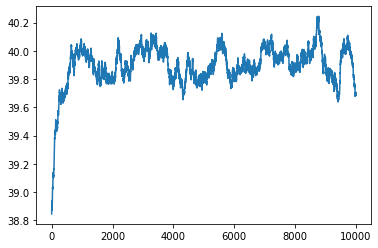

In [443]:
plt.plot(result['points'][0])
# plt.plot(result['points'][1])
# plt.plot(result['points'][2])
plt.show()

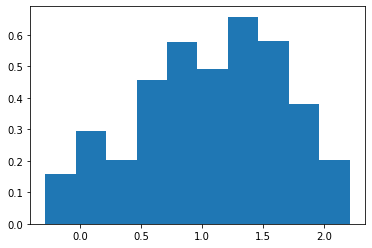

In [11]:
plt.hist(result['points'][0], density = True)
plt.show()

tensor([38.9471])


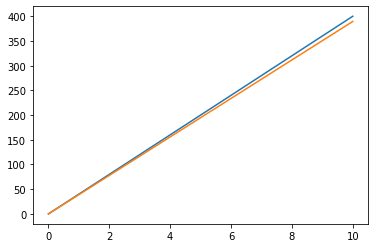

In [438]:
yy = 40 * qq
plt.plot(qq, yy)

# params = torch.from_numpy(np.array([1, .5, 3])).float()

params = torch.from_numpy(np.array(list(zip(*result['points']))[-1])).float()

print(params)

pred = fun(params)(torch.from_numpy(qq))

# yy = result['points'][0][-1] + result['points'][1][-1] * qq + result['points'][2][-1] * qq **2 

plt.plot(qq, pred)

plt.show()